# SARS-CoV-2 data processing

This notebook contains the following analysis:

1. [Data preprocessing, selecting regions, and filtering data](#preprocess)  
2. [Finding groups of linked mutations and classifying mutations as synonymous or nonsynonymous](#link)
3. [Finding frequency trajectories in different regions](#trajectories)
4. [Inferring selection coefficients for various different scenarios](#infer)
5. [Early detection of Alpha, Delta, and Omicron](#early_detection)
6. [Analyzing the effect of travel on inferred coeffficients for EU1 in the UK](#EU1_travel)
7. [Analyzing the effect on inferred coefficients of masking out Alpha mutations](#alpha_mask)
8. [Calculating various statistics](#statistics)
9. [Inferring selection for variants before they actually appeared](#selection_on_date)
10. [Finding the null distribution and analying early detections for groups of SNVs accross regions](#null_distribution)
11. [Early detection of Alpha, Delta, and Omicron trimming data by submission date](#submission_date)
12. [Bootstrapping sequence data to find errors](#bootstrap)
13. [Subsampling regions to find errors](#regional_subsampling)
14. [Making a table of number of detections for major variants](#variant_detection_table)

In [1]:
# REORGANIZE NOTEBOOK

import os, sys
import posixpath as ppath
from imp import reload
import datetime as dt
import shutil
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
import matplotlib.pyplot as plt
print('matplotlib version %s' % matplotlib.__version__)

import scipy
from scipy import linalg
print('scipy version %s' % scipy.__version__)

from tqdm import tqdm

# GLOBAL VARIABLES

# sequence related variables
NUC = ['-', 'A', 'C', 'G', 'T']

# local directories
SARS_DIR     = os.getcwd()
INF_SCRIPTS  = 'inf-scripts'
INF_DIR      = 'data'
DATA_DATE    = '2022-06-09'
DATA_DIR     = os.path.join(SARS_DIR,'data')
SCRIPT_DIR   = os.path.join(SARS_DIR, 'Processing-files')

# cluster directories
USER_NAME  = 'blee098'
EMAIL_EXT  = '@ucr.edu'    # email extension for account attached to cluster
SSH_HOME   = 'blee098@cluster.hpcc.ucr.edu:'
SSH_DATA   = ppath.join('/rhome', USER_NAME, 'bigdata', 'SARS-CoV-2-Data')
SCRATCH    = ppath.join(SSH_DATA, 'scratch')
DATABASE_DIR = ppath.join(SSH_DATA, f'lmdb-{DATA_DATE}')

# metadata variables
METADATA_COLS    = [   'accession', 'virus_name',            'date', 'location',             'location_additional', 'submission_date']
METADATA_OCOLS   = ['Accession ID', 'Virus name', 'Collection date', 'Location', 'Additional location information', 'Submission date']
METADATA_XFORM   = [           str,    str.lower,               str,  str.lower,                         str.lower,               str]
METADATA_COMP    = os.path.join(SARS_DIR, f'metadata_tsv_2022_06_09.tar.xz')
METADATA_FILE    = os.path.join(SARS_DIR, f'metadata-{DATA_DATE}', 'metadata.tsv')
METADATA_DIR     = os.path.join(SARS_DIR, f'metadata-{DATA_DATE}')
MSA_NAME         = 'msa_0608'
METADATA_INTERIM = 'merged-interim.csv'
MERGED_FINAL     = f'metadata-{DATA_DATE}.csv'
REF_TAG          = 'EPI_ISL_402125'
IHME_DATA        = 'ihme-popsize-2022_09_10'
REF_FILE         = f'ref-index-{DATA_DATE}'

# SEQUENCE PROCESSING GLOBAL VARIABLES
MIN_REGIONAL_SEQS = 1000

#START_IDX    = 0
#END_IDX      = -1
#MAX_GAP_NUM  = 20000
#MAX_GAP_FREQ = 0.99
#MIN_SEQS     = 0
#MAX_DT       = 999

python version 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version 1.16.2
pandas version 0.24.2
matplotlib version 3.0.3
scipy version 1.2.1


In [2]:
# Variant definitions

epsilon        = np.unique(['NSP13-260-0-T', 'S-13-1-T', 'S-152-2-T', 'NC-28271-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 
                  'S-452-1-G', 'N-205-1-T', 'ORF3a-57-2-T', 'NSP9-65-0-G']) # Done

alpha          = np.unique(['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',
                  'NSP6-108-1--', 'NSP6-108-2--', 'S-501-0-T', 'NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 
                  'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
                  'S-69-2--', 'S-70-0--', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-570-1-A', 'S-681-1-A', 'S-716-1-T', 'S-982-0-G', 
                  'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T',
                  'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G'])    # Done

# NEED TO ADD S:D138Y
gamma          = np.unique(['NSP9-31-2-T', 'NSP1-156-2-C', 'NSP3-10-2-T', 'NSP3-370-1-T', 'NSP3-977-0-C', 'NSP3-1200-2-G', 'NSP3-1298-2-G', 
                  'NSP12-140-2-T', 'NSP13-341-2-T', 'S-20-1-A', 'S-417-1-C', 'S-1027-1-T', 'ORF3a-253-0-C', 'ORF8-92-0-A', 'N-80-1-G', 
                  'S-190-2-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-501-0-T', 'NSP6-106-0--', 'NSP6-106-1--', 
                  'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--',
                  'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'N-202-0-T', 'N-202-1-C', 'S-18-0-T', 'S-26-0-T', 'S-655-0-T',
                  'S-1176-0-T'])    # Done

twentyE_EU1    = np.unique(['NSP16-199-2-C', 'NSP1-60-2-C', 'NSP3-1189-2-T', 'M-93-2-G', 'N-220-1-T', 'ORF10-30-0-T', 'S-222-1-T',
                  'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G'])    # Done
# This is Pango lineage B.1.177

delta          = np.unique(['NSP12-671-0-A', 'NC-209-T', 'NSP13-77-1-T', 'S-19-1-G', 'S-156-1--', 'S-156-2--', 'S-157-0--', 'S-157-1--', 'S-157-2--', 
                  'S-158-0--', 'S-478-1-A', 'S-681-1-G', 'S-950-0-A', 'ORF3a-26-1-T', 'M-82-1-C', 'ORF7a-82-1-C', 'ORF7a-120-1-T', 
                  'ORF8-119-0--', 'ORF8-119-1--', 'ORF8-119-2--', 'ORF8-120-0--', 'ORF8-120-1--', 'ORF8-120-2--', 'N-63-1-G', 'N-203-1-T', 
                  'N-377-0-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-452-1-G', 'NC-28270--', 'NSP4-492-1-T'])    # Done

beta           = np.unique(['S-80-1-C', 'NSP3-837-2-T', 'S-215-1-G', 'E-71-1-T', 'S-240-2--', 'S-241-0--', 'S-242-1--', 'S-242-2--', 'S-243-0--', 
                  'S-240-1--', 'S-241-1--', 'S-241-2--', 'S-242-0--', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-501-0-T',
                  'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 
                  'NSP6-108-1--', 'NSP6-108-2--', 'S-417-2-T', 'S-484-0-A', 'S-701-1-T', 'ORF3a-57-2-T', 'NSP2-85-1-T', 'NSP5-90-1-G',
                  'N-205-1-T', 'NC-173-T', 'ORF8-120-2-T'])    # Done

lambda_new     = np.unique(['S-246-2--', 'NSP3-1569-0-G', 'S-247-0--', 'S-247-1--', 'S-247-2--', 'S-248-0--', 'S-248-1--', 'S-248-2--', 'S-249-0--', 
                  'S-249-1--', 'S-249-2--', 'S-250-0--', 'S-250-1--', 'S-250-2--', 'S-251-0--', 'S-251-1--', 'S-251-2--', 'S-252-0--', 
                  'S-246-1--', 'S-252-1--', 'S-252-2--', 'S-253-0--', 'N-214-0-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 
                  'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 
                  'NSP6-108-1--', 'NSP6-108-2--', 'S-75-1-T', 'S-76-1-T', 'S-452-1-A', 'S-490-1-C', 'S-859-1-A', 'NSP3-428-1-T',
                  'NSP3-1469-0-T', 'NSP4-438-1-C', 'NSP4-492-1-T', 'NSP5-15-0-A']) # Done

iota           = np.unique(['N-234-2-A', 'S-5-0-T', 'S-95-1-T', 'S-253-1-G', 'S-484-0-A', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G',
                 'S-701-1-T', 'NSP13-88-2-C', 'ORF3a-42-1-T', 'ORF3a-67-2-T', 'NSP2-85-1-T', 'NSP4-438-1-C', 'NSP6-106-0--', 'NSP6-106-1--', 
                 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',  'NSP6-108-1--', 'NSP6-108-2--', 'N-199-1-T',
                 'N-232-2-A', 'ORF8-11-1-T', 'NSP15-214-2-G', 'NC-28270--'])

D614G          = ['NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G']    # Done

B1_1_318       = np.unique(['NSP15-320-0-A', 'S-575-2-C', 'S-1238-2-A', 'ORF7b-44-2--', 'NC-27887--', 'NC-27888--', 'NC-27889--', 'NC-27890--', 
                  'NC-27891--', 'NC-27892--', 'ORF8-1-0--', 'ORF8-1-1--', 'ORF8-1-2--', 'NSP4-173-1-T', 'S-796-0-C', 'ORF8-2-0--', 
                  'ORF8-2-1--', 'ORF8-2-2--', 'ORF8-3-0--', 'ORF8-3-1--', 'NC-28270-G', 'N-208-2--', 'N-209-0--', 'N-208-1--',
                  'NSP3-378-1-T', 'NSP3-1693-2-T', 'NSP5-21-1-T', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 
                  'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--', 'S-95-1-T', 'S-143-2--', 'S-144-0--', 
                  'S-144-1--', 'S-484-0-A', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-681-1-A', 'M-82-1-C',
                  'N-203-1-A', 'N-203-2-A', 'N-204-0-C']) # Add N-234-2-T, Many others

# need to add orf1b-314, 3037
omicron        = np.unique(['NC-240-T', 'NSP3-38-1-G', 'NSP3-106-2-T', 'NSP3-889-2-G', 'NSP3-1265-1--', 'NSP3-1265-2--', 'NSP3-1266-0--', 
                  'NSP3-1892-0-A', 'NSP4-492-1-T', 'NSP5-132-1-A', 'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 
                  'NSP6-105-2--', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-189-0-G', 'NSP10-57-2-C', 
                  'NSP12-323-1-T', 'NSP12-600-2-T', 'S-67-1-T', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
                  'S-69-2--', 'S-70-0--', 'S-95-1-T', 'S-142-1--', 'S-142-2--', 'S-143-0--', 'S-143-1--', 'S-143-2--', 'S-144-0--', 
                  'S-144-1--', 'S-144-2--', 'S-145-0--', 'S-211-1--', 'S-211-2--', 'S-212-0--', 'S-339-1-A', 'S-371-0-C', 
                  'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-446-0-A', 'S-547-1-A', 'S-614-1-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-856-2-A', 'S-954-2-T', 'S-969-2-A', 'S-981-0-T', 
                  'S-1146-2-T', 'ORF3a-64-2-T', 'E-9-1-T', 'M-3-1-G', 'M-19-0-G', 'M-63-0-A', 'ORF6-20-0-C', 
                  'NC-28270-T', 'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 'N-32-1--', 
                  'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'S-375-1-T', 'S-477-1-A', 'S-478-1-A', 
                  'S-484-1-C', 'S-493-1-G', 'S-496-0-A', 'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NSP14-42-0-G',
                  'ORF7b-18-0-T', 'S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 'S-214q-2-A', 'S-214r-2-A', 
                  'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A'])  

# 3037
ba2            = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 'N-32-1--', 
                  'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'NSP4-492-1-T', 'NSP5-132-1-A', 
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'E-9-1-T', 'ORF3a-223-1-T',
                  'M-19-0-G', 'M-63-0-A', 'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C', 'S-493-1-G', 
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'N-413-0-C', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP15-112-1-T', 'ORF6-61-0-C', 'ORF6-61-1-T', 'ORF6-61-2-C', 'S-1146-2-T',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-64-2-T', 'M-112-2-T', 'ORF6-20-0-C', 'ORF7b-18-0-T', 'NC-28270-T', 
                  'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-405-0-A', 'S-214m-2-G', 
                  'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 
                  'S-214t-2-A', 'S-214u-2-A', 'NSP1-135-2-G', 'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 
                  'NSP4-327-1-T'])

# deletion after 29734
ba4            = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--', 'S-452-1-G',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C',
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 
                  'S-614-1-G', 'S-405-0-A', 'S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 
                  'S-214p-2-C', 'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A',
                  'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'NSP1-135-2-G',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 
                  'N-32-1--', 'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C',
                  'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 'NSP4-492-1-T', 'NSP4-327-1-T',
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP5-132-1-A', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP15-145-2-G', 'ORF3a-223-1-T', 'M-19-0-G', 'M-63-0-A', 'E-9-1-T',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-64-2-T', 'M-112-2-T', 'ORF6-20-0-C', 'ORF7b-18-0-T', 'NC-28270-T',
                  'S-1146-2-T', 'ORF7b-11-2-T', 'S-486-0-G', 'NSP8-23-2-A', 'N-151-0-T',
                  'NSP1-141-0--', 'NSP1-141-1--', 'NSP1-141-2--', 'NSP1-142-0--', 'NSP1-142-1--',
                  'NSP1-142-2--', 'NSP1-143-0--', 'NSP1-143-1--', 'NSP1-143-2--', 'N-413-0-C',
                  'ORF6-61-0-C', 'ORF6-61-1-T', 'ORF6-61-2-C'])

# deletion after 29734
ba5            = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--', 'S-452-1-G',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C',
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 
                  'S-614-1-G', 'S-405-0-A','S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 
                  'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A',
                  'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'NSP1-135-2-G',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 
                  'N-32-1--', 'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C',
                  'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 'NSP4-492-1-T', 'NSP4-327-1-T',
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP5-132-1-A', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-223-1-T', 'M-19-0-G', 'M-63-0-A', 'E-9-1-T', 'M-3-0-A', 'S-486-0-G',
                  'NSP8-23-2-A', 'N-413-0-C', 'S-1146-2-T', 'NC-28270-T', 'ORF3a-64-2-T', 'ORF7b-18-0-T'])

ba2121         = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--', 'S-452-1-G',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C',
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 
                  'S-614-1-G', 'S-405-0-A', 'S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 
                  'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A',
                  'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'S-452-1-A',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 'N-32-1--', 
                  'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'NSP4-492-1-T', 'NSP5-132-1-A', 
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-189-0-G', 'E-9-1-T', 'ORF3a-223-1-T',
                  'M-19-0-G', 'M-63-0-A', 'N-413-0-C', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP15-112-1-T', 'ORF6-61-0-C', 'ORF6-61-1-T', 'ORF6-61-2-C', 'S-1146-2-T',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-64-2-T', 'M-112-2-T', 'ORF6-20-0-C', 'ORF7b-18-0-T', 'NC-28270-T',
                  'NSP1-135-2-G', 'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 'NSP4-327-1-T', 
                  'S-704-1-T', 'S-452-1-A'])
 
# synonymous: 9593T
eta            = np.unique(['NSP2-231-2-T', 'NSP2-334-2-G', 'NSP2-618-2-A', 'NSP4-13-2-C', 'NSP16-22-2-G',
                  'S-888-0-C', 'ORF6-2-0--', 'ORF6-2-1--', 'ORF6-2-2--', 'N-2-1--', 'N-2-2--',
                  'N-3-0--', 'N-12-1-G', 'N-142-2-G', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
                  'S-69-2--', 'S-70-0--', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G',
                  'M-82-1-C', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 
                  'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',  'NSP6-108-1--', 'NSP6-108-2--',
                  'S-52-1-G', 'S-67-1-T', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-484-0-A', 
                  'S-677-2-C', 'N-205-1-T', 'E-21-0-T', 'NSP3-1189-1-T',
                  'NSP14-44-2-T', 'S-1062-2-C', 'N-142-2-G', 'NC-29542-T'])

# confused about orf1a-T1567I
kappa           = np.unique(['NSP12-323-1-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G',
                   'S-154-0-A', 'S-1071-2-T', 'S-681-1-G', 'S-484-0-C', 'S-452-1-G', 'NSP13-206-0-T',
                   'NSP13-429-2-T', 'NSP15-259-1-G', 'NSP15-261-0-G', 'N-203-1-T', 'N-377-0-T',
                   'M-82-1-G', 'ORF3a-26-1-T', 'NSP3-749-1-T', 'NSP6-77-0-G', 'ORF7a-82-1-C',
                   'NC-209-T', 'NSP3-246-2-T', 'M-53-2-T', 'NC-28270--'])

# maybe S-144-0-A, S-144-1-C, S-144-2-C, S-145-0-A (actually there is an insertion here)
# not positive about 'NSP3-237-0-G'
mu              = np.unique(['S-346-2-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-95-1-T',
                   'S-484-1-C', 'S-501-0-T', 'S-681-1-A', 'S-950-0-A', 'NSP3-237-0-G', 'NSP3-720-1-T',
                   'NSP4-492-1-T', 'NSP6-160-1-G', 'NSP12-323-1-T', 'NSP13-419-0-T', 'N-205-1-T',
                   'ORF3a-57-2-T', 'ORF3a-256-0--', 'ORF3a-256-1--', 'ORF3a-256-2--', 'ORF3a-257-0--',
                   'ORF3a-257-2-C', 'ORF8-11-1-T', 'ORF8-38-0-T', 'ORF8-67-1-T',
                   'NSP3-1106-2-T', 'NSP10-11-2-T', 'NSP14-280-0-T', 'NSP15-176-2-T', 'NC-26491-T',
                   'NC-28271-T'])

#all_variants   = [epsilon, alpha, beta, gamma, lambda_new, delta, twentyE_EU1, iota, D614G]
all_variants   = [epsilon, alpha, beta, gamma, lambda_new, delta, twentyE_EU1, D614G, omicron, ba2, ba5, ba4, ba2121]
#all_variants    = [epsilon, alpha, beta, gamma, lambda_new, delta, twentyE_EU1, iota, D614G, B1_1_318]
np.save(os.path.join(DATA_DIR, 'variants.npy'), all_variants)

var_dic = {
    'alpha' : alpha, 
    'epsilon' : epsilon, 
    'beta' : beta, 
    'gamma' : gamma, 
    'lambda' : lambda_new, 
    'delta' : delta, 
    '20E\(EU1\)' : twentyE_EU1, 
    'B.1' : D614G,
    'omicron' : omicron,
    'BA.2' : ba2,
    'eta' : eta,
    'iota' : iota,
    'B.1.1.318' : B1_1_318,
    'kappa' : kappa,
    'mu' : mu,
    'BA.4' : ba4,
    'BA.5' : ba5,
    'BA.2.12.1' : ba2121
}

variants_full = [var_dic[i] for i in var_dic]
np.save(os.path.join(DATA_DIR, 'variants-all.npy'), variants_full)

# THE BELOW ARE INCOMPLETE LISTS OF MUTATIONS
b12    = ['NSP5-89-0-T', 'NSP14-129-0-G', 'ORF3a-172-1-T', 'ORF8-24-1-T', 'N-67-0-T']    # this is B.1.2
b11318 = ['NSP15-320-0-A', 'S-575-2-C', 'S-1238-2-A', 'ORF7b-44-2--', 'NC-27887--', 'NC-27888--', 'NC-27889--', 'NC-27890--',     # This is B.1.1.318, S:D796H
          'NC-27891--', 'NC-27892--', 'ORF8-1-0--', 'ORF8-1-1--', 'ORF8-1-2--', 'NSP4-173-1-T', 'S-796-0-C', 'ORF8-2-0--', 
          'ORF8-2-1--', 'ORF8-2-2--', 'ORF8-3-0--', 'ORF8-3-1--', 'NC-28270-G', 'N-208-2--', 'N-209-0--', 'N-208-1--']
b1429  = ['NSP8-3-2-T', 'NSP2-598-0-C', 'NSP4-131-2-T', 'NSP9-65-0-G', 'S-929-2-C', 'NC-27889-T', 'NSP2-530-2-T']

# SHOULD I ADD ZETA, THETA

<a id='preprocess'></a>
# Data Preprocessing

### Extracting the accessions, virus name, date, and location information from metadata file

In [2]:
print(f'mkdir {METADATA_DIR} &&')
print(f'tar -xf {METADATA_COMP} -C {METADATA_DIR}')

mkdir /Users/brianlee/SARS-CoV-2-Data/metadata-2022-06-09 &&
tar -xf /Users/brianlee/SARS-CoV-2-Data/metadata_tsv_2022_06_09.tar.xz -C /Users/brianlee/SARS-CoV-2-Data/metadata-2022-06-09


In [3]:
accessions = set()
header     = ','.join(METADATA_COLS)

use_cols = ['Accession ID', 'Virus name', 'Collection date', 'Location', 
            'Additional location information', 'Submission date', 'Host']
df = pd.read_csv('%s' % METADATA_FILE, sep='\t', usecols=use_cols)
f = open('%s' % METADATA_INTERIM, 'w')
f.write('%s\n' % header)
for df_iter, df_entry in tqdm(df.iterrows(), total=df.shape[0]):
    #if df_iter % 10000 == 0:
    #    print(df_inter / len(df))
    entry = []
    unique_id  = False
    valid_date = False
        
    # check that host is human
    if 'Host' in df_entry:
        if df_entry.Host!='Human' and df_entry.Host!='human':
            continue
        
    # get accession
    acc_idx = METADATA_COLS.index('accession')
    if 'Accession ID' not in df_entry:
        continue
    xformed = METADATA_XFORM[acc_idx](df_entry[METADATA_OCOLS[acc_idx]])
    acc     = METADATA_XFORM[acc_idx](df_entry[METADATA_OCOLS[acc_idx]])

    if xformed not in accessions:
        #accessions.append(xformed)
        accessions.add(xformed)
        entry.append(xformed)
        unique_id = True
    #else:
        #print('Excluding %s (duplicate accession number)' % xformed)
        
    # get virus name 
    if 'Virus name' in df_entry:
        name_idx = METADATA_COLS.index('virus_name')
        xformed  = METADATA_XFORM[name_idx](df_entry[METADATA_OCOLS[name_idx]])
        xformed  = xformed.replace(',', ' ')
        entry.append(xformed)
    else:
        entry.append('NA')
            
    # get date
    if unique_id:
        date_idx = METADATA_COLS.index('date')
        xformed  = METADATA_XFORM[date_idx](df_entry[METADATA_OCOLS[date_idx]])
            
        try:
            dt.date.fromisoformat(xformed)
            valid_date = True
        except:
            valid_date = False
            #print('Excluding %s (date %s is incomplete)' % (entry[0], xformed))
        entry.append(xformed)
            
    # get location 
    if unique_id and valid_date:
        loc_idx = METADATA_COLS.index('location')
        xformed = METADATA_XFORM[loc_idx](df_entry[METADATA_OCOLS[loc_idx]])
        xformed = xformed.replace(',', ' ')
        entry.append(xformed)
        
        loc_add_idx = METADATA_COLS.index('location_additional')
        xformed     = METADATA_XFORM[loc_add_idx](str(df_entry[METADATA_OCOLS[loc_add_idx]]))
        xformed     = xformed.replace(',', ' ')
        entry.append(xformed)
        
    # get submission date
    if unique_id and valid_date:
        sub_idx = METADATA_COLS.index('submission_date')
        xformed = METADATA_XFORM[sub_idx](df_entry[METADATA_OCOLS[sub_idx]])
        
        try:
            dt.date.fromisoformat(xformed)
            valid_sub_date = True
        except:
            valid_sub_date = False
        entry.append(xformed)
        
    # save data
    if unique_id and valid_date and valid_sub_date:
        f.write('%s\n' % ','.join(entry))            

# Add reference if not in the list of accessions
if REF_TAG not in accessions:
    entry = []
    for i in range(len(METADATA_COLS)):
        if METADATA_COLS[i]=='accession':
            entry.append(REF_TAG)
        elif METADATA_COLS[i]=='date' or METADATA_COLS[i]=='submission_date':
            entry.append('2020-01-01')
        else:
            entry.append('reference')
    f.write('%s\n' % ','.join(entry))
f.close()

/Users/brianlee/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 11256004/11256004 [28:22<00:00, 6611.46it/s] 


### Merging sequence data in the GISAID alignment with metadata on the cluster

In [28]:
# Write sequences to lightning-mapped database and extract location information from metadata
msa_name         = MSA_NAME
msa_file         = f'{msa_name}.fasta'
msa_path_cluster = os.path.join(SSH_DATA, msa_name, msa_name + '.fasta')
script_file      = 'merge-metadata-lmdb-parallel.py'
metadata_new     = os.path.join(SSH_DATA, MERGED_FINAL)
msa_file2 = f'{msa_name}.tar.xz'
msa_path2 = os.path.join(SARS_DIR, msa_file2)
num_dirs  = int(11000000 / 500000) + 1

job_file         = 'job-merge-db.sh'
job_str          = f"""#!/bin/bash -l

#SBATCH --time=1-00:00:00
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --job-name=merge
#SBATCH -e ./MPL/out/merge-error-%a
#SBATCH -o ./MPL/out/merge-out-%a
#SBATCH --array=1-{num_dirs}

module unload miniconda2
module load miniconda3
conda activate sars-env
tar -xf {SSH_DATA}/{msa_file2} -C {SSH_DATA}

python {script_file} --meta_file {os.path.join(SSH_DATA, METADATA_INTERIM)} --msa_file {msa_path_cluster} --lmdbDir {DATABASE_DIR} --refFile {REF_FILE} --dbNumber $SLURM_ARRAY_TASK_ID --metaNew {metadata_new}
""" 

f = open(os.path.join(SARS_DIR, job_file), mode='w')
f.write('%s\n' % job_str)
f.close()

msa_path_local = os.path.join(SARS_DIR, msa_file2)
print(f'scp {msa_path_local} {SSH_HOME}/{SSH_DATA} &&')
print('scp %s/%s %s &&' % (SCRIPT_DIR, script_file, SSH_HOME))
print('scp %s/%s %s/%s &&' % (SARS_DIR, METADATA_INTERIM, SSH_HOME, SSH_DATA))
print('scp %s/%s %s &&' % (SCRIPT_DIR, 'data_processing.py', SSH_HOME))
print('scp %s/%s %s '   % (SARS_DIR, job_file, SSH_HOME))
print('')

print('scp %s %s/%s/%s' % (msa_path2, SSH_HOME, SSH_DATA, msa_file2))
print('')

# commands to execute on the cluster
#print('tar -xf %s/%s -C %s &&' % (SSH_DATA, msa_file2, SSH_DATA))
print('mkdir -p ./MPL/out &&')
print('sbatch %s' % job_file)
print('')

scp /Users/brianlee/SARS-CoV-2-Data/msa_0608.tar.xz blee098@cluster.hpcc.ucr.edu://rhome/blee098/bigdata/SARS-CoV-2-Data &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/merge-metadata-lmdb-parallel.py blee098@cluster.hpcc.ucr.edu: &&
scp /Users/brianlee/SARS-CoV-2-Data/merged-interim.csv blee098@cluster.hpcc.ucr.edu://rhome/blee098/bigdata/SARS-CoV-2-Data &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu: &&
scp /Users/brianlee/SARS-CoV-2-Data/job-merge-db.sh blee098@cluster.hpcc.ucr.edu: 

scp /Users/brianlee/SARS-CoV-2-Data/msa_0608.tar.xz blee098@cluster.hpcc.ucr.edu://rhome/blee098/bigdata/SARS-CoV-2-Data/msa_0608.tar.xz

mkdir -p ./MPL/out &&
sbatch job-merge-db.sh



### Checking sampling by region

In [9]:
# finding the number of sequences in each region

out_file      = f'regional-{DATA_DATE}'
script_file   = 'check-regional.py'
job_dir       = SSH_HOME + SSH_DATA
job_file      = 'job-check-regional.sh'
job_str       = f"""#!/bin/bash -l

#SBATCH --time=0-3
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem-per-cpu=100G
#SBATCH --job-name=regional-check
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH -e ./MPL/out/region-error
#SBATCH -o ./MPL/out/region-out
#SBATCH -p batch

module unload miniconda2
module load miniconda3
conda activate sars-env

python {script_file} --alignment {os.path.join(SSH_DATA, METADATA_INTERIM)} -o {os.path.join(SSH_DATA, out_file)}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), mode='w')
f.write('%s\n' % job_str)
f.close()

# transfer data processing scripts and job file to the cluster
print('scp %s/%s %s &&' % (SCRIPT_DIR, script_file, SSH_HOME))
print('scp %s/%s %s' % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

# run the job on the cluster
print('sbatch %s' % job_file)
print('')

# transfer output data back to local directory
print('scp %s/%s %s' % (job_dir, out_file+'.csv', SARS_DIR))

scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/check-regional.py blee098@cluster.hpcc.ucr.edu: &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-check-regional.sh blee098@cluster.hpcc.ucr.edu:

sbatch job-check-regional.sh

scp blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/regional-2022-06-09.csv /Users/brianlee/SARS-CoV-2-Data


### Extracting regions and time series for analysis
<a id='select'></a>

In [11]:
# Regions that are selected manually because either
# 1. They are broken up in an abnormal manner
# 2. For some of the pandemic the case numbers in the region were too low for the model to be reliable 
#(or there was essentially no community transmission)

north_cali = ['santa clara county, alameda county', 'san francisco county', 'sacramento county', 
              'contra costa county', 'humboldt county', 'sonoma county', 'stanislaus county', 
              'san joaquin county', 'solano county', 'merced county', 'santa cruz',
              'madera county', 'southern san joaquin valley', 'placer county',  
              'davis', 'nevada county', 'santa cruz county', 'san mateo county', 'butte county', 
              'mendocino county', 'shasta county', 'tuolumne county', 'napa county',
              'marin county', 'el dorado county', 'lake county', 'san luis obispo', 
              'sutter county', 'contra costa', 'tehama county']

south_cali = ['los angeles', 'los angeles county', 'orange', 'orange county', 'san diego', 
              'san diego county', 'ventura', 'ventura county', 'san luis obispo', 
              'san luis obispo county', 'imperial', 'imperial county', 'san bernardino county', 
              'riverside county', 'kern county', 'imperial county']

regs = [#['europe', 'czech republic', None, None, '2020-07-01', None],
        #['europe', 'denmark', None, None, '2020-08-01', None],
        #['europe', 'finland', None, None, '2020-10-01', None],
        #['europe', 'iceland', None, None, '2021-07-20', None],
        ['europe', 'united kingdom', 'northern ireland', None, None, None],
        ['europe', 'united kingdom', ['england', 'wales', 'scotland'], None, None, None],
        #['oceania', 'australia', None, None, '2020-07-01', '2020-10-01'],
        #['oceania', 'australia', None, None, '2021-07-01', None],
        #['asia', 'china', None, None, None, '2020-03-01'],
        #['asia', 'singapore', None, None, '2020-04-01', '2020-08-20'],
        #['asia', 'singapore', None, None, '2021-07-15', None],
        #['asia', 'south korea', None, None, '2020-08-14', None], 
        ['north america', 'usa', 'california', south_cali, None, None],
        ['north america', 'usa', 'california', north_cali, None, None]]

state_elim   = ['california']
country_elim = []
for entry in regs:
    if entry[1]!='usa':
        country_elim.append(entry[1])

# Large countries or states, that must be broken up into smaller regions
use_subregions  = [          'usa',        'mexico',        'canada', 'turkey', 'india',        'brazil', 'russia',     'argentina',         'chile']
cont_subregions = ['north america', 'north america', 'north america',   'asia',  'asia', 'south america', 'europe', 'south america', 'south america']

In [12]:
df = pd.read_csv(os.path.join(SARS_DIR, f'regional-{DATA_DATE}.csv'))
#pd.set_option('max_rows', 300)
continent = [str(i) for i in list(df['continent'])]
country   = [str(i) for i in list(df['country'])]
combined  = [continent[i] + '-' + country[i] for i in range(len(continent))]
df['combined'] = combined
data    = df['combined'].value_counts()

regions = np.array(list(data.axes[0]))
counts  = np.array(list(data))
mask    = counts > MIN_REGIONAL_SEQS
regions = regions[mask]
counts  = counts[mask]

regions    = [i.split('-') for i in regions]
continents = [i[0] for i in regions]
countries  = [i[1] for i in regions]

for i in range(len(regions)):
    if countries[i] not in use_subregions and countries[i] not in country_elim:
        regs.append([continents[i], countries[i], None, None, None, None])

"""
df_usa = df[df['country']=='usa']
data   = df_usa['region'].value_counts()

states = np.array(list(data.axes[0]))
counts = np.array(list(data))
mask   = counts > 1000

states = states[mask]
counts = counts[mask]

for i in range(len(states)):
    if states[i] not in state_elim:
        regs.append(['north america', 'usa', states[i], None, None, None])
"""
for i in range(len(use_subregions)):
    continent = cont_subregions[i]
    country   = use_subregions[i]
    df_temp   = df[(df['continent']==continent) & (df['country']==country)]
    data      = df_temp['region'].value_counts()
    states    = np.array(list(data.axes[0]))
    counts    = np.array(list(data))
    
    mask      = counts > 1000
    states    = states[mask]
    counts    = counts[mask]
    
    for j in range(len(states)):
        if states[j] not in state_elim:
            regs.append([continent, country, states[j], None, None, None]) 

regs.sort(key = lambda x: x[:2])      
            
#for reg in regs:
#    print(reg)

selected = regs

### Find number of infected individuals in each region over time using the IHME data

In [17]:
est_dir = os.path.join(SARS_DIR, IHME_DATA)
file1   = os.path.join(est_dir, 'data_download_file_reference_2020.csv')
data1   = pd.read_csv(file1)
data1   = data1[data1['version_name']=='reference']
for year in ['2021', '2022']:
    df2 = pd.read_csv(os.path.join(est_dir, f'data_download_file_reference_{year}.csv'))
    df2 = df2[df2['version_name']=='reference']
    data1 = pd.concat([data1, df2])
popsize = list(data1.inf_mean)
dates_all = list(data1.date)
locs      = [i.lower() for i in list(data1.location_name)]
#print(len(popsize), len(locs))
#print(np.unique(locs))

#regions = []
regions = selected
#for file in os.listdir(os.path.join(SARS_DIR, f'regional-{DATA_DATE}')):
#    regions.append(np.load(os.path.join(SARS_DIR, f'regional-{DATA_DATE}', file), allow_pickle=True)[0])
new_regions = [list(np.array(i)[np.array(i)!=None]) for i in regions]
#print(new_regions[:10])
#for reg in new_regions:
#    if '2' in reg[-1] and '2' in reg[-2]:
#        last_loc = reg[-3]
#    elif '2' in reg[-1]:
#        last_loc = reg[-2]
#    else: 
#        last_loc = reg[-1]
#    if last_loc not in locs:
#        print(reg)

#print('')
eliminated = []
full_regs  = []    # the full region name including continent, country, etc.
new_regs   = []    # the name of the smallest scale of region used
for i in range(len(new_regions)):
    reg = new_regions[i]
    if '2' in reg[-1] and '2' in reg[-2]:
        last_loc = reg[-3]
    elif '2' in reg[-1]:
        last_loc = reg[-2]
    else: 
        last_loc = reg[-1]
    if last_loc not in locs and not isinstance(last_loc, list):
        if last_loc=='czech republic':
            full_regs.append(regions[i])
            new_regs.append('czechia')
        else:
            print(reg)
            eliminated.append(reg)
    else:
        new_regs.append(last_loc)
        full_regs.append(regions[i])
#new_regs.append('czechia')

dates_excluded = []
for loc in new_regs:
    if isinstance(loc, list):
        dates_excluded.append([])
        continue
    pop   = np.array(popsize)[np.array(locs)==loc]
    dates = np.array(dates_all)[np.array(locs)==loc]
    dates = dates[~np.isnan(pop)]
    pop   = pop[~np.isnan(pop)]
    
    window = 5
    pop_smooth     = [np.mean(pop[i:i+window]) for i in range(len(pop)-window)]
    dates_smooth   = dates[window:]
    dates_smallpop = dates_smooth[np.array(pop_smooth)<100]
    dates_temp     = np.array([(dt.date.fromisoformat(i) - dt.date.fromisoformat('2020-01-01')).days for i in dates_smallpop])
    
    new_dates  = []
    dates_diff = np.diff(dates_temp) - 1
    idxs       = [-1] + list(np.nonzero(dates_diff)[0]) + [-1]
    if len(dates_temp)==0:
        dates_excluded.append(None)
        continue
    #intervals  = [(start_date + dt.timedelta(int(dates_temp[idxs[i] + 1]))).isoformat() + '-' + (start_date + dt.timedelta(int(dates_temp[idxs[i+1]]))).isoformat() for i in range(0, len(idxs)-1)]
    intervals  = [dates_smallpop[idxs[i]+1] + '---' + dates_smallpop[idxs[i+1]] for i in range(len(idxs)-1)]
    dates_excluded.append(intervals)
    #print(dates_temp)
    #print(dates_diff)
    #print(intervals)
mask = [True if i is not None else False for i in dates_excluded]
dates_excluded = np.array(dates_excluded)[mask]
full_regs      = np.array(full_regs)[mask]
new_regs       = np.array(new_regs)[mask]

['africa', 'mauritius']
['africa', 'reunion']
['africa', 'seychelles']
['asia', 'brunei']
['asia', 'hong kong']
['asia', 'india', 'jammu and kashmir']
['asia', 'india', 'puducherry']
['asia', 'iran']
['asia', 'south korea']
['asia', 'vietnam']
['europe', 'gibraltar']
['europe', 'kosovo']
['europe', 'liechtenstein']
['europe', 'russia', 'moscow']
['europe', 'russia', 'saint petersburg']
['north america', 'canada', 'new brunswick']
['north america', 'canada', 'newfoundland and labrador']
['north america', 'martinique']
['north america', 'mexico', 'state of mexico']
['north america', 'mexico', 'yucatan']
['north america', 'mexico', 'nuevo leon']
['north america', 'mexico', 'veracruz']
['north america', 'mexico', 'queretaro']
['north america', 'sint maarten']
['north america', 'u.s. virgin islands']
['oceania', 'northern mariana islands']
['south america', 'argentina', 'buenos aires']
['south america', 'argentina', 'santa fe']
['south america', 'argentina', 'ciudad autonoma de buenos aires

In [18]:
def make_new_regions(reg, dates_excluded):
    #print(reg)
    if any([isinstance(i, list) for i in reg]):
        new_regs = [reg]
        return new_regs
    new_regs = []
    for i in range(len(dates_excluded)):
        new_reg = [j for j in reg]
        if i==0:
            new_reg[-1] = dates_excluded[i].split('---')[0]
        else:
            new_reg[-1] = dates_excluded[i].split('---')[0]
            new_reg[-2] = dates_excluded[i-1].split('---')[1]
        new_regs.append(new_reg)
    last_reg = [i for i in reg]
    last_reg[-2] = dates_excluded[-1].split('---')[1]
    new_regs.append(last_reg)
    return new_regs

selected = []
for i in range(len(full_regs)):
    new_regs = make_new_regions(full_regs[i], dates_excluded[i])
    for reg in new_regs:
        selected.append(reg)

In [19]:
for i in selected:
    if i[1]=='croatia':
        print(i)

['europe', 'croatia', None, None, None, '2020-02-09']
['europe', 'croatia', None, None, '2020-03-01', '2020-05-17']
['europe', 'croatia', None, None, '2020-06-05', None]


__need to also take into account days that are present in the sequence data but not the IHME data, and regions not in the IHME data.__

In [20]:
regions_dir = os.path.join(SARS_DIR, f'regions-{DATA_DATE}')
if not os.path.exists(regions_dir):
    os.mkdir(regions_dir)

for group in selected:
    new = np.array(group)[np.array(group)!=None]
    #new           = group
    contains_list = False
    for i in new:
        if not isinstance(i, str):
            contains_list = True
    if contains_list:
        label = ''
        for i in new:
            if isinstance(i, str):
                label += i
            #elif isinstance(i, type(None)):
            #    label += 'None'
            else:
                if len(i) > 4:
                    #print(i)
                    if new[2]=='california':
                        if 'riverside county' in new[3]:
                            label += 'south'
                        else:
                            label += 'north'
                else:
                    label += '_'.join(i)
            if i!=new[-1]:
                label += '-'
    else:
        #label = []
        #for i in new:
        #    label.append(i)
        label = '-'.join(new)
    f = open(os.path.join(regions_dir, label + '.npy'), mode='wb')
    np.save(f, [group])
    f.close()

In [21]:
# Transfer scripts, run processing, and extract files
# Processing clips the time series in different regions according to set rules regarding the distribution of the number of sampled genomes over time
data_module   = 'data_processing.py'
data_mod_path = os.path.join(SCRIPT_DIR, data_module)
out_folder    = os.path.join(SSH_DATA, 'regions-times-' + DATA_DATE)
script_file   = 'find-region-times-parallel.py'
region_data   = f'regions-{DATA_DATE}'

job_file      = 'job-find-regions-parallel.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=50G
#SBATCH --time=1-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/region-error-%a
#SBATCH -o ./MPL/out/region-out-%a
#SBATCH --array=0-{len(selected) - 1}

regions=({region_data}/*)
module unload miniconda2
module load miniconda3
conda activate sars-env
mkdir {out_folder}

region=${{regions[$SLURM_ARRAY_TASK_ID]}}
python {script_file} --input_file {os.path.join(SSH_DATA, METADATA_INTERIM)} -o {out_folder} --regions \"$region\" 
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

print('scp %s/%s/%s %s. &&' % (SARS_DIR, 'processing-new', script_file, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, data_module, SSH_HOME))
print('scp -r %s %s. &&' % (regions_dir, SSH_HOME))
print('scp %s/%s %s.'    % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print(f'mkdir {out_folder}')
print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s' % (SSH_HOME, out_folder, SARS_DIR))

#print(job_str)

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/find-region-times-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/SARS-CoV-2-Data/regions-2022-06-09 blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-regions-parallel.sh blee098@cluster.hpcc.ucr.edu:.

mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/regions-times-2022-06-09
sbatch job-find-regions-parallel.sh

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/regions-times-2022-06-09 /Users/brianlee/SARS-CoV-2-Data


In [30]:
# Processing with multiple lightning mapped databases storing the sequences
data_module   = 'data_processing.py'
data_mod_path = os.path.join(SCRIPT_DIR, data_module)
out_folder    = os.path.join(SSH_DATA, DATA_DATE, 'msa-reg')
script_file   = 'extract-seqs.py'
region_dir    = os.path.join(SSH_DATA, f'regions-times-{DATA_DATE}')
lmdb_dir      = os.path.join(SSH_DATA, f'lmdb-{DATA_DATE}')

# run on cluster
print(f'ls {region_dir} | wc -l')
num_regions = 500

job_file      = 'job-extract.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/genome-error-%a
#SBATCH -o ./MPL/out/genome-out-%a
#SBATCH --array=0-{num_regions - 1}

module unload miniconda2
module load miniconda3
conda activate sars-env

regions=({region_dir}/*)
region=${{regions[$SLURM_ARRAY_TASK_ID]}}
python {script_file} --input_file {metadata_new} -o {out_folder} --regions \"$region\"  --lmdb {lmdb_dir}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

print('scp %s/%s/%s %s. &&' % (SARS_DIR, 'processing-new', script_file, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, data_module, SSH_HOME))
#print('scp %s/%s %s. &&' % (SARS_DIR, identifier + '.npy', SSH_HOME))
print('scp %s/%s %s.'    % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s &&' % (SSH_HOME, out_folder, SARS_DIR))
print('scp -r %s%s %s' % (SSH_HOME, REF_TAG + '.fasta', SARS_DIR))

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/regions-times-2022-06-09 | wc -l
scp /Users/brianlee/SARS-CoV-2-Data/processing-new/extract-seqs.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-extract.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-extract.sh

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/msa-reg /Users/brianlee/SARS-CoV-2-Data &&
scp -r blee098@cluster.hpcc.ucr.edu:EPI_ISL_402125.fasta /Users/brianlee/SARS-CoV-2-Data


In [27]:
# Processing with multiple lightning mapped databases storing the sequences
data_module   = 'data_processing.py'
data_mod_path = os.path.join(SCRIPT_DIR, data_module)
out_folder    = os.path.join(SSH_DATA, DATA_DATE, 'genome-data')
input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'msa-reg')
script_file   = 'process-threaded.py'
threads       = 20

# run on cluster
print(f'ls {input_dir} | wc -l')
num_regions = 527

job_file      = 'job-process.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --cpus-per-task={threads}
#SBATCH --mem=150G
#SBATCH --time=12:00:00
#SBATCH -e ./MPL/out/genome-error-%a
#SBATCH -o ./MPL/out/genome-out-%a
#SBATCH --array=0-{num_regions - 1}

module unload miniconda2
module load miniconda3
conda activate sars-env

files=({input_dir}/*)
file=${{files[$SLURM_ARRAY_TASK_ID]}}
python {script_file} --input_file \"$file\" -o {out_folder} --refFile {REF_FILE + '.csv'} --threads {threads}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

gap_path    = os.path.join(SARS_DIR, 'gap-list.npy')
script_path = os.path.join(SARS_DIR, 'processing-new', script_file)
print('scp %s %s. &&' % (script_path, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, data_module, SSH_HOME))
#print('scp %s/%s %s. &&' % (SARS_DIR, identifier + '.npy', SSH_HOME))
print('scp %s/%s %s.'    % (SCRIPT_DIR, job_file, SSH_HOME))
print(f'scp {gap_path} {SSH_HOME}')

print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s &&' % (SSH_HOME, out_folder, SARS_DIR))
print('scp -r %s%s %s' % (SSH_HOME, REF_TAG + '.fasta', SARS_DIR))

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/msa-reg | wc -l
scp /Users/brianlee/SARS-CoV-2-Data/processing-new/process-threaded.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-process.sh blee098@cluster.hpcc.ucr.edu:.
scp /Users/brianlee/SARS-CoV-2-Data/gap-list.npy blee098@cluster.hpcc.ucr.edu:
sbatch job-process.sh

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-data /Users/brianlee/SARS-CoV-2-Data &&
scp -r blee098@cluster.hpcc.ucr.edu:EPI_ISL_402125.fasta /Users/brianlee/SARS-CoV-2-Data


### Finding time series with good sampling in each region

In [4]:
# Finding time series with good sampling

input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-data')
output_dir    = os.path.join(SSH_DATA, DATA_DATE)
script_file   = 'trim-intervals-sd.py'

print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")
print('echo ${#files[*]}')
print('')

job_file      = 'job-trim-intervals.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=20:00:00
#SBATCH -e ./MPL/out/sampling-error-%a
#SBATCH -o ./MPL/out/sampling-out-%a
#SBATCH --array=1-370

module unload miniconda2 
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
file=${{files[$SLURM_ARRAY_TASK_ID]}}

python {script_file} --input \"$file\" -o {output_dir} --trimDir genome-trimmed
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()


print('scp %s/%s/%s %s. &&'   % (SARS_DIR, 'processing-new', script_file, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s' % (SSH_HOME, output_dir, SARS_DIR))

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-data ! -name "*sites*" -print0)
echo ${#files[*]}

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/trim-intervals-sd.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-trim-intervals.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-trim-intervals.sh

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09 /Users/brianlee/SARS-CoV-2-Data


### Eliminating sites that never rise to a very high frequency or have a mutation only in a few sequences in a region

In [7]:
# Finding maximum frequencies in each region

input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-trimmed')
output_dir    = os.path.join(SSH_DATA, DATA_DATE, 'max-freqs')
script_file   = 'find-max-frequencies.py'

# run on cluster to find number of files
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print('')

num_files     = 518   # the number of data files 

job_file      = 'job-max-freqs.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=12:00:00
#SBATCH -e ./MPL/out/freqs-error-%a
#SBATCH -o ./MPL/out/freqs-out-%a
#SBATCH --array=1-{num_files-1}

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)

module unload miniconda2
module load miniconda3
conda activate sars-env

file=${{files[$SLURM_ARRAY_TASK_ID]}}
python {script_file} --input_file \"$file\" -o {output_dir} --refFile {REF_FILE + '.csv'}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', script_file)
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s.'   % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-trimmed ! -name "*sites*" -print0)
echo ${#files[*]}

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/find-max-frequencies.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-max-freqs.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-max-freqs.sh


In [8]:
# eliminate sites from a time-series if there are less than min_seqs total mutations at this site in all sequences in the time-series
min_seqs  = 5
min_freq  = 0.01
max_dir   = os.path.join(SSH_DATA, DATA_DATE, 'max-freqs')
out_dir   = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
input_dir = os.path.join(SSH_DATA, DATA_DATE, 'genome-trimmed')
script    = 'filter-sites-parallel.py'

#print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")
#print('echo ${#files[*]}')
#print('')
#num_files = 461

job_file  = 'job-filter-counts.sh'
job_str   = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=3:00:00
#SBATCH -e ./MPL/out/filter-counts-error-%a
#SBATCH -o ./MPL/out/filter-counts-out-%a
#SBATCH --array=1-{num_files-1}

module unload miniconda2 
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
file=${{files[$SLURM_ARRAY_TASK_ID]}}

python {script} --input \"$file\" -o {out_dir} --max_dir {max_dir} --min_count {min_seqs} --refFile {REF_FILE + '.csv'}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', script)
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/filter-sites-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-filter-counts.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-filter-counts.sh


In [14]:
# Combining maximum frequencies in different regions

input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'max-freqs')
out_dir       = os.path.join(SSH_DATA, DATA_DATE)
script_file   = 'combine-max-freqs.py'

job_file      = 'job-combine-max-freqs.sh'
job_str       = f"""#!/bin/bash -l
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=20:00:00
#SBATCH -e ./MPL/out/freqs-combine-error
#SBATCH -o ./MPL/out/freqs-combine-out
#SBATCH -p highmem

module unload miniconda2 
module load miniconda3
conda activate sars-env

python {script_file} --input_dir {input_dir} -o {out_dir} --refFile {REF_FILE + '.csv'}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', script_file)
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print(f'scp {SSH_HOME}{out_dir}/nucleotide-counts.npz {DATA_DIR}')

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/combine-max-freqs.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-combine-max-freqs.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-combine-max-freqs.sh

scp blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/nucleotide-counts.npz /Users/brianlee/SARS-CoV-2-Data/2022-06-09


<a id='link'></a>
# Finding linked sites and classifying mutations as synonymous or nonsynonymous

### Finding linked sites on cluster

In [30]:
# Finding single and double site counts in each region

input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
count_script  = 'epi-covar.py'
link_script   = 'epi-find-linked-parallel.py'
archive_loc   = os.path.join(INF_DIR, 'Archive-alt-vector')
out_dir       = os.path.join(SSH_DATA, DATA_DATE)
temp_dir      = os.path.join(SSH_DATA, DATA_DATE, 'counts')

# run on cluster to find number of files
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print('cd ./Archive-alt-vector')
print('g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11')
print('')
num_files = 520   # the number of data files 

job_file1 = 'job-find-counts.sh'
job_str1  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/counts-error-%a
#SBATCH -o ./MPL/out/counts-out-%a
#SBATCH --array=1-{num_files - 1}

module unload miniconda2
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
cd ./Archive-alt-vector
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
echo "$file"
python ../{count_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --find_counts
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

# combining single and double site counts from the different regions to find linked sites

job_file2 = 'job-find-linked.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=150G
#SBATCH --time=1-00:00:00
#SBATCH -e ./MPL/out/linked-error-%a
#SBATCH -o ./MPL/out/linked-out-%a
#SBATCH --array=0

tols=(0.8)
module unload miniconda2
module load miniconda3
conda activate sars-env

outfile={out_dir}/linked-sites
python {link_script} --data {temp_dir} -o $outfile --timed 1 --multisite -q 5 --link_tol ${{tols[$SLURM_ARRAY_TASK_ID]}} --refFile {REF_FILE + '.csv'}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
script_path = os.path.join(SARS_DIR, 'processing-new', 'epi-covar.py')
link_path   = os.path.join(SARS_DIR, 'processing-new', 'epi-find-linked-parallel.py')
print('scp %s %s. &&'      % (script_path, SSH_HOME))
print('scp %s %s. &&'      % (link_path, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s' % job_file1)
print('sbatch %s' % job_file2)
print('')

# transfer files from cluster
print('scp %s%s/linked-sites.npy %s &&'               % (SSH_HOME, out_dir, DATA_DIR))
print('scp %s%s/linked-sites-alleles.npy %s &&'       % (SSH_HOME, out_dir, DATA_DIR))
print('scp %s%s/linked-sites-anywhere.npy %s &&'      % (SSH_HOME, out_dir, DATA_DIR))
print('scp %s%s/nucleotide-counts.npz %s' % (SSH_HOME, out_dir, DATA_DIR))

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered ! -name "*sites*" -print0)
echo ${#files[*]}
cd ./Archive-alt-vector
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-covar.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-find-linked-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-alt-vector blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-counts.sh blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-linked.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-find-counts.sh
sbatch job-find-linked.sh

scp blee098@cluster.hpcc.ucr.edu:/rhome/blee0

In [228]:
print(dp.orf_to_nsp('orf1a-141'))
print(dp.get_noncanonical_orfs(28290))

NSP1-141-2
['ORF9b-3-1']


In [202]:
site = 28310
noncanon = dp.get_noncanonical_orfs(site)
print(noncanon)
print(dp.get_label(site))

['ORF9b-10-0']
N-13-1


In [219]:
dp.get_label(12159)

'NSP8-23-2'

In [752]:
traj_dir  = os.path.join(DATA_DIR, 'trajectories')
sites_all = []
times_all = []
files_all = []
for file in os.listdir(traj_dir):
    try:
        df = pd.read_csv(os.path.join(traj_dir, file))
    except:
        print(file)
    sites_all.append(df.columns.values)
    times_all.append(list(df['time']))
    files_all.append(os.path.join(traj_dir, file))
nucs_all  = [i[1:] for i in sites_all]
sites_all = [[dp.get_label_new(nucs_all[i][j]) for j in range(len(nucs_all[i]))] for i in range(len(nucs_all))]
short_all = [[sites_all[i][j][:-2] for j in range(len(sites_all[i]))] for i in range(len(sites_all))]
regions   = [os.path.split(i)[-1] for i in files_all]

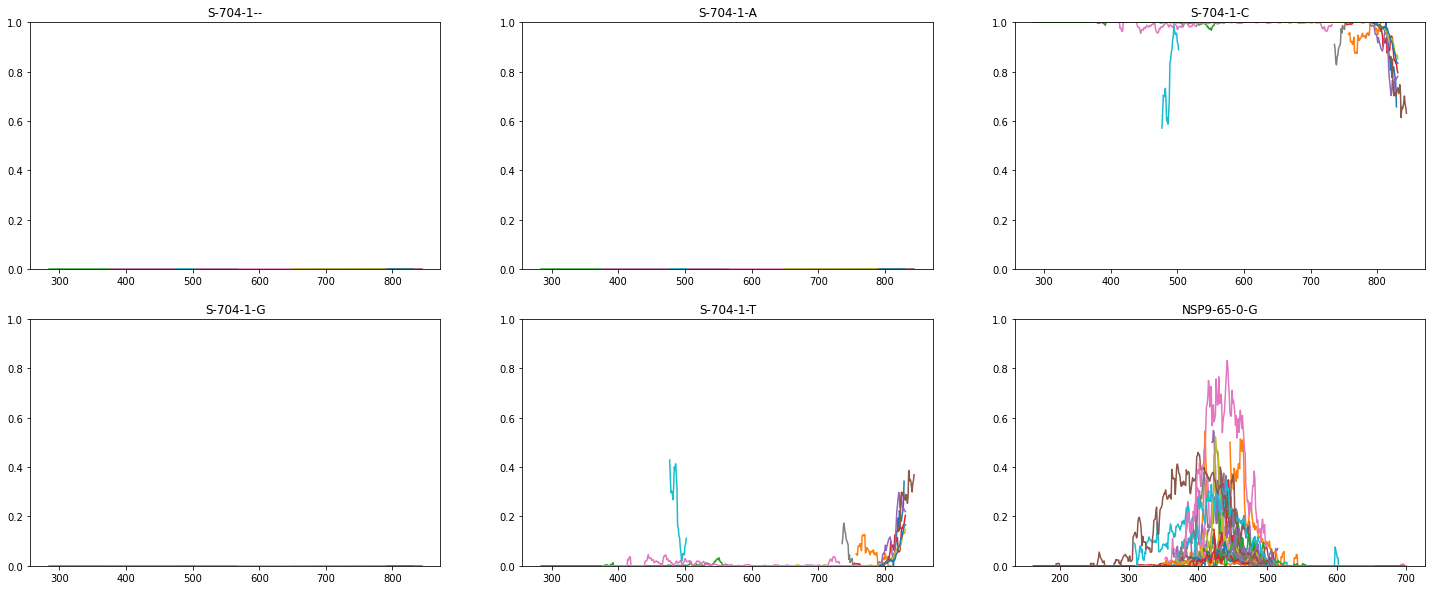

In [757]:
known_site = 'NSP9-65-0-G'    # the site that we know is a defining site of the variant.
site       = 'S-704-1'      # the site that we are interested in looking at the trajectories for, for different mutations.

fig, axes  = plt.subplots(2, 3, figsize=[25,10])

locs_known = []
ax1 = axes[-1, -1]
ax1.set_title(known_site)
ax1.set_ylim(0,1)
for i in range(len(sites_all)):
    if known_site in sites_all[i]:
        #print(times[i])
        site_nuc = nucs_all[i][sites_all[i].index(known_site)]
        col = list(pd.read_csv(files_all[i], usecols=[site_nuc])[site_nuc])
        ax1.plot(times_all[i], col)
        #locs_known.append(locations[i])
        #if np.amax(traj[i][:, list(sites_all[i]).index(known_site)])>0.4:
        #    print(locs[i])
sites_present = [site in short_all[i] for i in range(len(short_all))]
locs_present  = np.array([i for i, x in enumerate(sites_present) if x])
#print(locs_present)
site_idxs     = [short_all[i].index(site) for i in locs_present]
times_present = np.array(times_all)[locs_present]
#locs_unknown  = locations[locs_present]
for j in range(2):
    for i in range(3):
        if j * 3 + i < 5:
            idx = j * 3 + i
            ax  = axes[j, i]
            ax.set_ylim(0,1)
            ax.set_title(site + '-' + NUC[idx])
            new_site = site + '-' + NUC[idx]
            for k in range(len(locs_present)):
                site_nuc = nucs_all[locs_present[k]][sites_all[locs_present[k]].index(new_site)]
                times = times_all[locs_present[k]]
                col   = list(pd.read_csv(files_all[locs_present[k]], usecols=[site_nuc])[site_nuc])
                ax.plot(times, col)
                #ax.plot(times, col, label=np.array(regions)[locs_present[k]])
                #if 'slovenia' in regions[locs_present[k]]:
                #if 'australia' in regions[locs_present[k]]:
                #    ax.plot(times, col) 
                    #if 'greece' in locations[locs_present[k]]:
                    #    ax.plot(np.arange(times_present[k][0], times_present[k][0] + len(traj[locs_present[k]])), traj[locs_present[k]][:, site_idxs[k] + idx], label=locations[locs_present[k]]) 
                    
                    #if locations[locs_present[k]]=='north america-usa-arizona---2020-8-20-2022-2-5':
                    #    print(traj[locs_present[k]][:, site_idxs[k] + idx])
                    #if locations[locs_present[k]].split('-')[1] in ['sweden', 'netherlands']:
                    #    ax.plot(np.arange(times_present[k][0], times_present[k][0] + len(traj[locs_present[k]])), traj[locs_present[k]][:, site_idxs[k] + idx], label=locations[locs_present[k]]) 
                    #if site + '-' + NUC[idx] == 'S-681-1--' and np.amax(traj[locs_present[k]][:, site_idxs[k] + idx])>0.05:
                    #    print(locations[locs_present[k]])
                    #    print(times[locs_present[k]])
                    #    print(traj[locs_present[k]][:, site_idxs[k] + idx])
                #ax.legend()
            #ax.legend()

In [697]:
print(np.array(regions)[locs_present])

['europe-croatia---2021-7-4-2022-2-19.csv'
 'europe-estonia---2021-7-14-2021-8-26.csv'
 'europe-bulgaria---2021-7-18-2021-12-9.csv'
 'europe-estonia---2021-9-15-2021-10-15.csv']


In [611]:
print(dp.codon2aa('ACT'))
print(dp.codon2aa('TCT'))

P
S


In [54]:
# check M-82-1--, S-681-0--, S-681-1--, S-681-2--, ORF7b-18--

['traj', 'times', 'times_full', 'traj_nosmooth', 'allele_number', 'ref_sites', 'counts']
29
33


In [ ]:
# find list of known gaps
ref_df    = pd.read_csv(os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv'))
ref_index = list(ref_df['ref_index'])
ref_sites = [dp.get_label_new(str(i) + '-A')[:-2] for i in ref_index]
variants  = [epsilon, alpha, beta, gamma, lambda_new, delta, twentyE_EU1, D614G, omicron, ba2, ba5, ba4, ba2121, kappa, mu, b12, b11318, b1429, B1_1_318]
gap_sites = []
for var in variants:
    for site in var:
        if site[-1]=='-':
            gap_sites.append(ref_index[ref_sites.index(site[:-2])])
for i in list('abcdefghijklmnopqrstuvwxyz'):
    gap_sites.append(f'22203{i}')
print([dp.get_label_new(i + '-A')[:-2] for i in gap_sites])
np.save(os.path.join(SARS_DIR, 'gap-list.npy'), gap_sites)

### Classifying mutations as synonymous or nonsynonymous on the cluster

In [ ]:
script_file   = 'find-nonsynonymous.py'
out_dir       = os.path.join(SSH_DATA, DATA_DATE)

job_file      = 'job-find-nonsynonymous.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=300G
#SBATCH --time=1-0
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/error-synonymous
#SBATCH -o ./MPL/out/out-synonymous

module purge
module load anaconda3

python {script_file} --data {out_dir} --multisite
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

print('scp %s/%s %s. &&'    % (SCRIPT_DIR, script_file, SSH_HOME))
print('scp %s/%s %s. &&'    % (SCRIPT_DIR, 'data_processing.py', SSH_HOME))
#print('scp %s/%s %s/%s &&'  % (SARS_DIR, 'EPI_ISL_402125.fasta', SSH_HOME, SSH_DATA))
print('scp %s/%s %s.'       % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print('scp %s%s/%s %s &&' % (SSH_HOME, out_dir, 'synonymous.npz', DATA_DIR))
print('scp %s%s/%s %s &&' % (SSH_HOME, out_dir, 'synonymous-prot.npz', DATA_DIR))
print('scp %s%s/%s %s'    % (SSH_HOME, out_dir, 'protein-changes', DATA_DIR))

In [334]:
new_groups = [['ORF6-61-0-G', 'ORF6-61-1-T', 'ORF6-61-2-C'], ['S-142-1-A', 'S-142-2-T']]
linked = np.load(os.path.join(DATA_DIR, 'linked-sites.npy'), allow_pickle=True)
linked = list(linked)
for i in new_groups:
    linked.append(i)
np.save(os.path.join(DATA_DIR, 'linked-sites.npy'), linked)
#print(linked)

In [335]:
# Changing the amino acid for nucleotide mutations that are linked to other nucleotide mutations in the same codon
dp.fix_aa_changes(os.path.join(DATA_DIR, 'synonymous-prot.npz'),
                  os.path.join(DATA_DIR, 'linked-sites.npy'),
                  os.path.join(DATA_DIR, 'synonymous-prot-test'))

NSP5-47-0-A NSP5-47-2-T
NSP2-88-0-- NSP2-88-1--
S-144-0-- S-144-1--
S-68-1-- S-68-2--
NSP6-197-1-C NSP6-197-2-A
NSP7-33-0-T NSP7-33-1-G
S-136-0-- S-136-1--
NSP12-671-0-- NSP12-671-1--
S-1101-0-- S-1101-2--
NSP12-185-0-C NSP12-185-1-A
NSP12-185-0-- NSP12-185-1--
NSP12-261-1-G NSP12-261-2-C
NSP15-206-1-- NSP15-206-2--
N-2-1-- N-2-2--
S-156-1-- S-156-2--
NSP13-443-0-G NSP13-443-1-A
NSP15-232-1-C NSP15-232-2-G
S-218-0-- S-218-2--
NSP15-215-0-A NSP15-215-1-T
NSP15-222-0-T NSP15-222-1-C
N-208-1-- N-208-2--
ORF8-3-0-- ORF8-3-1--
NSP16-293-0-T NSP16-293-1-C
S-240-1-- S-240-2--
S-91-0-G S-91-1-G
S-104-1-T S-104-2-T
S-385-1-A S-385-2-C
NSP2-493-0-C NSP2-493-2-C
S-943-0-C S-943-1-C
ORF3a-163-0-A ORF3a-163-2-T
ORF3a-219-0-A ORF3a-219-1-A
ORF6-61-0-C ORF6-61-1-T
ORF8-1-0-C ORF8-1-1-A
ORF8-14-0-C ORF8-14-2-G
ORF8-80-0-G ORF8-80-1-A
ORF8-108-0-A ORF8-108-1-A
N-1-0-G N-1-2-C
N-202-0-T N-202-1-C
N-203-1-A N-203-2-A
N-361-0-T N-361-1-C
N-420-0-C N-420-1-T
NSP1-39-0-A NSP1-39-1-A
NSP1-77-0-G NSP1-77-2-T


<a id='trajectories'></a>
# Finding frequency trajectories

In [28]:
# Finding frequency trajectories
input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
freq_script   = 'epi-traj-parallel.py'
temp_dir      = os.path.join(SSH_DATA, DATA_DATE, 'trajectories')

# run on cluster
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print('')

num_files     = 518   # the number of data files that must be read from the directory

job_file1     = 'job-find-traj.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=12:00:00
#SBATCH -e ./MPL/out/traj-error-%a
#SBATCH -o ./MPL/out/traj-out-%a
#SBATCH --array=1-{num_files}
#SBATCH -p highmem

module unload miniconda2
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
python {freq_script} --data \"$file\" -o $tempout -q 5 --timed 1 --window 5
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()


# transfer files to cluster
script_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
print('scp %s %s. &&'    % (script_path, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, job_file1, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('')

# transfer files from cluster
print(f'scp -r {SSH_HOME}{temp_dir} {DATA_DIR}')

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered ! -name "*sites*" -print0)
echo ${#files[*]}

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-traj-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-traj.sh blee098@cluster.hpcc.ucr.edu:. &&

sbatch job-find-traj.sh &&

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/trajectories /Users/brianlee/SARS-CoV-2-Data/2022-06-09


In [11]:
# Finding frequency trajectories
input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
freq_script   = 'epi-traj-parallel.py'
temp_dir      = os.path.join(SSH_DATA, DATA_DATE, 'trajectories-nosmooth')

# run on cluster
print(f'ls {input_dir} | wc -l')    # in order to find the number of files in the input directory
print('')

num_files     = 518   # the number of data files that must be read from the directory

job_file1     = 'job-find-traj-nosmooth.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=12:00:00
#SBATCH -e ./MPL/out/traj-error-%a
#SBATCH -o ./MPL/out/traj-out-%a
#SBATCH --array=1-{num_files}

module unload miniconda2
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
python {freq_script} --data \"$file\" -o $tempout -q 5 --timed 1 --window 0
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()


# transfer files to cluster
script_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
print('scp %s %s. &&'    % (script_path, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, job_file1, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('')

# transfer files from cluster
print(f'scp -r {SSH_HOME}{temp_dir} {DATA_DIR}')

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered | wc -l

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-traj-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-traj-nosmooth.sh blee098@cluster.hpcc.ucr.edu:. &&

sbatch job-find-traj-nosmooth.sh &&

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/trajectories-nosmooth /Users/brianlee/SARS-CoV-2-Data/2022-06-09


In [158]:
# Find delta trajectories
# Finding frequency trajectories
input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
freq_script   = 'epi-traj-variant.py'
out_file1     = os.path.join(SSH_DATA, DATA_DATE, 'delta-traj')
out_file2     = os.path.join(SSH_DATA, DATA_DATE, 'ba2-traj')
out_file3     = os.path.join(SSH_DATA, DATA_DATE, 'lambda-traj')

job_file1     = 'job-find-traj-variant.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=12:00:00
#SBATCH -e ./MPL/out/traj-delta-error
#SBATCH -o ./MPL/out/traj-delta-out
#SBATCH -p highmem

module unload miniconda2
module load miniconda3
conda activate sars-env

python {freq_script} --data {input_dir} -o {out_file1}  -q 5 --timed 1 --window 15
python {freq_script} --data {input_dir} -o {out_file2} -q 5 --timed 1 --window 15 --variant BA.2
python {freq_script} --data {input_dir} -o {out_file3} -q 5 --timed 1 --window 15 --variant Lambda
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()


# transfer files to cluster
script_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
print('scp %s %s. &&'    % (script_path, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, job_file1, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('')

# transfer files from cluster
print(f'scp -r {SSH_HOME}{out_file1} {DATA_DIR} &&')
print(f'scp -r {SSH_HOME}{out_file2} {DATA_DIR}')
print(f'scp -r {SSH_HOME}{out_file3} {DATA_DIR}')

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-traj-variant.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-traj-delta.sh blee098@cluster.hpcc.ucr.edu:. &&

sbatch job-find-traj-delta.sh &&

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-south-africa-sd /Users/brianlee/SARS-CoV-2-Data/2022-06-09


<a id='infer'></a>
# Inferring selection coefficients

### Inferring the selection coefficients for all of the sites using all of the regions

In [22]:
# infering the selection coefficients using a cutoff frequency of 5%
input_dir      = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
freq_script    = 'epi-covar.py'
inf_script     = 'epi-inf-parallel.py'
archive_loc    = os.path.join(INF_DIR, 'Archive-test')
temp_dir       = os.path.join(SSH_DATA, DATA_DATE, 'freqs')
out_file       = os.path.join(SSH_DATA, f'infer-{DATA_DATE}')

# run on cluster
print(f'ls {input_dir} | wc -l')    # in order to find the number of files in the input directory
print('cd Archive-test')
print('g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11')
print('')

num_files     = 518   # the number of data files that must be read from the directory

job_file1     = 'job-find-freqs.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-error-%a
#SBATCH -o ./MPL/out/freq-out-%a
#SBATCH --array=1-{num_files-1}

module unload miniconda2
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
cd ./Archive-test
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
echo "$file"
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2 = 'job-infer.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=10:00:00
#SBATCH -e ./MPL/out/inf-error-%a
#SBATCH -o ./MPL/out/inf-out-%a
#SBATCH --array=0-10
#SBATCH -p batch

module unload miniconda2 
module load miniconda3
conda activate sars-env

regs=(1 5 10 20 30 40 50 60 70 80)
outfile={out_file}/infer-g-${{regs[$SLURM_ARRAY_TASK_ID]}}
python {inf_script} --data {temp_dir} --timed 1 -o $outfile -q 5 --g1 ${{regs[$SLURM_ARRAY_TASK_ID]}} --refFile {REF_FILE + '.csv'} --saveCovar
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

freq_script_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
inf_script_path  = os.path.join(SARS_DIR, 'processing-new', 'epi-inf-parallel.py')
# transfer files to cluster
print('scp %s %s. &&'   % (freq_script_path, SSH_HOME))
print('scp %s %s. &&'   % (inf_script_path, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file2)
print('mkdir %s &&'  % os.path.join(SSH_DATA, f'inf-{DATA_DATE}'))
print('mv %s %s'     % (os.path.join(SSH_DATA, f'infer-{DATA_DATE}-*'), os.path.join(SSH_DATA, f'infer-{DATA_DATE}')))
print('')

# transfer files from cluster
print('scp -r %s%s %s' % (SSH_HOME, out_file, DATA_DIR))
#for r in regularization:
#    print('scp %s%s %s &&' % (SSH_HOME, out_file +  f'-g-{r}.npz', INF_DIR))

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered | wc -l
cd Archive-test
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-covar.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-inf-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-test blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-freqs.sh blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-find-freqs.sh &&
sbatch job-infer.sh &&
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/inf-2022-06-09 &&
mv /rhome/blee098/bigdata/SARS-CoV-2-Data/infer-2022-06-09-* /rhome/blee098/bi

### Eliminating mutations that are not observed and reference nucleotides

In [ ]:
# Find trajectories for 20E-EU1 (OLD, NEEDS TO BE UPDATED)
os.chdir(SCRIPT_DIR)
import data_processing as dp
reload(dp)
os.chdir(SARS_DIR)
times    = []
traj     = []
data_dir = os.path.join(DATA_DIR, 'freq_0.05')
for file in os.listdir(data_dir):
    loc_split = file.split('-')
    if loc_split[0]=='europe' and loc_split[1]=='united kingdom' and loc_split[2]=='england_wales_scotland':
        filepath = os.path.join(data_dir, file)
        data     = np.load(filepath, allow_pickle=True)
        nVec     = data['nVec']
        sVec     = data['sVec']
        t_temp   = data['times']
        muts     = data['mutant_sites']
        muts     = [dp.get_label(i) for i in muts]
        traj_temp= dp.trajectory_calc_20e_eu1(nVec, sVec, muts, d=5)
        traj_temp= dp.moving_average(traj_temp, window=10)
        traj.append(traj_temp)
        times.append(t_temp[9:])

f = open(os.path.join(DATA_DIR, '20E-EU1-trajectory.csv'), mode='w')
f.write('time,frequency\n')
for i in range(len(times)):
    for j in range(len(times[i])):
        f.write(f'{times[i][j]},{traj[i][j]:0.8f}\n')
f.close()

In [15]:
# Eliminating sites that are infrequently observed (frequency never about 5% in any region and total observations > 5)
window    = 5
count_min = 40
cutoff    = 0.05

# determining which sites pass the 2 cutoff criteria
traj_dir  = os.path.join(DATA_DIR, 'trajectories-nosmooth')
traj_muts = []
for file in os.listdir(traj_dir):
    traj_file = os.path.join(traj_dir, file)
    df        = pd.read_csv(traj_file)
    df        = df.drop(columns=['time'])
    muts_temp = df.columns.values
    #print(muts_temp)
    #del muts_temp['time']
    traj_muts.append(muts_temp)
traj_muts = list(np.unique([traj_muts[i][j] for i in range(len(traj_muts)) for j in range(len(traj_muts[i]))]))
freq_mask = [False for i in range(len(traj_muts))]
for file in os.listdir(traj_dir):
    traj_file = os.path.join(traj_dir, file)
    df        = pd.read_csv(traj_file)
    df        = df.drop(columns=['time'])
    muts_temp = df.columns.values
    for site in muts_temp:
        mut_traj = list(df[site])
        mut_mask = np.any([np.all(mut_traj[i:i+window]) for i in range(len(mut_traj)-window+1)])
        if mut_mask:
            freq_mask[traj_muts.index(site)] = True
            
regs = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80]
for reg in regs:
    inf_data  = np.load(os.path.join(DATA_DIR, f'infer-{DATA_DATE}', f'infer-g-{reg}.npz'), allow_pickle=True)
    alleles   = inf_data['allele_number']
    selection = inf_data['selection']
    errors    = inf_data['error_bars']
    s_ind     = inf_data['selection_independent']
    locations = inf_data['locations']
    times     = inf_data['times']
            
    mask_new  = [i for i in range(len(alleles)) if freq_mask[traj_muts.index(alleles[i])]]
    selection = selection[mask_new]
    s_ind     = s_ind[mask_new]
    errors    = errors[mask_new]
    alleles   = alleles[mask_new]
        
    mask      = selection!=0

    selection = selection[mask]
    alleles   = alleles[mask]
    errors    = errors[mask]
    s_ind     = s_ind[mask]

    count_data = np.load(os.path.join(DATA_DIR, 'nucleotide-counts.npz'), allow_pickle=True)
    counts     = count_data['mutant_counts']
    alleles2   = count_data['allele_number']

    mask1      = np.isin(alleles2, alleles)
    alleles2   = np.array(alleles2)[mask1]
    counts     = counts[mask1]

    mask2      = np.isin(alleles, alleles2)
    alleles    = alleles[mask2]
    selection  = selection[mask2]
    s_ind      = s_ind[mask2]
    errors     = errors[mask2]

    mask3      = np.nonzero(counts>count_min)[0]
    alleles    = alleles[mask3]
    selection  = selection[mask3]
    s_ind      = s_ind[mask3]
    errors     = errors[mask3]
    
    np.savez_compressed(os.path.join(INF_DIR, f'infer-{DATA_DATE}-observed-g-{reg}.npz'),
                        selection=selection, selection_independent=s_ind, error_bars=errors,
                        allele_number=alleles)

In [4]:
ref_file = os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
dp.website_file2(os.path.join(INF_DIR, f'infer-{DATA_DATE}-observed.npz'),
                 os.path.join(DATA_DIR, 'synonymous-prot.npz'),
                 os.path.join(DATA_DIR, 'linked-sites.npy'), 
                 os.path.join(DATA_DIR, f'selection-observed.csv'),
                 ref_file=ref_file)

site NSP14-93-2-T already found in a different group
site ORF8-68-2-C already found in a different group
all fields calculated, putting data into dataframe...
nucleotide number 10398
protein 10398
amino acid number in protein 10398
amino acid number in reading frame 10398
synonymous 10398
amino acid mutation 10398
nucleotide 10398
reference nucleotide 10398
selection coefficient 10398
error 10398
independent model coefficient 10398
linked sites 10398
type of linked group 10398
total coefficient for linked group 10398
error for linked group 10398


__Finding coefficients for variants__

In [67]:
ref_file = os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
inf_file = os.path.join(DATA_DIR, f'infer-{DATA_DATE}', 'infer-g-40.npz')
#bootstrap_dir = os.path.join(DATA_DIR, 'infer-bs')
dp.linked_analysis_alt(inf_file,
                       os.path.join(DATA_DIR, 'linked-sites.npy'), 
                       os.path.join(DATA_DIR, 'synonymous-prot.npz'),
                       os.path.join(SARS_DIR, 'variants-all.npy'),
                       os.path.join(DATA_DIR, 'linked-coefficients.csv'),
                       #bootstrap_dir=bootstrap_dir,
                       ref_file=ref_file)

N-232-2-A
ORF7b-44-1--


In [118]:
ref_file = os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
inf_file = os.path.join(DATA_DIR, f'infer-{DATA_DATE}', 'infer-g-40.npz')
#bootstrap_dir = os.path.join(DATA_DIR, 'infer-bs')
dp.linked_analysis_alt(inf_file,
                       os.path.join(DATA_DIR, 'linked-sites.npy'), 
                       os.path.join(DATA_DIR, 'synonymous-prot.npz'),
                       os.path.join(SARS_DIR, 'variants.npy'),
                       os.path.join(DATA_DIR, 'linked-coefficients-main.csv'),
                       #bootstrap_dir=bootstrap_dir,
                       ref_file=ref_file)

In [119]:
# Make a csv file containing the frequency trajectories for the different variants in different regions
dp.linked_traj_csv(os.path.join(DATA_DIR, 'linked-coefficients-main.csv'), 
                   os.path.join(DATA_DIR, 'trajectories'), 
                   os.path.join(DATA_DIR, 'linked-trajectories-main'))

In [62]:
dp.linked_traj_csv(os.path.join(DATA_DIR, 'linked-coefficients.csv'), 
                   os.path.join(DATA_DIR, 'trajectories'), 
                   os.path.join(DATA_DIR, 'linked-trajectories'))

In [ ]:
# Change nucleotide mutations so they are indexed at 1 instead of 0
os.path.join(DATA_DIR, 'ref-index.csv')
df = pd.read_csv(os.path.join(DATA_DIR, 'linked-coefficients.csv'), index_col=False)
nucs = list(df['nucleotides'])
nucs = [i.split('/') for i in nucs]
nucs_new = []
for i in nucs:
    nucs_temp = []
    for j in i:
        if j!='not_present':
            new_nuc = str(int(j) + 1)
        else:
            new_nuc = j
        nucs_temp.append(new_nuc)
    nucs_new.append(nucs_temp)
nucs = ['/'.join(i) for i in nucs_new]
df['nucleotides'] = nucs
df.to_csv(os.path.join(DATA_DIR, 'linked-coefficients-paper.csv'), index=False)

### Nonsynonymous inference

In [134]:
# Inferring the selection coefficients only for nonsynonymous sites 
inf_script    = 'epi-inf-fast.py'
count_file    = 'nucleotide-counts.npz'
input_file    = f'infer-{DATA_DATE}/infer-g-40.npz'
inf_file      = f'infer-{DATA_DATE}/infer-g-40.npz'
syn_file      = 'synonymous-prot.npz'
out_file      = os.path.join(SSH_DATA, f'infer-{DATA_DATE}-nonsyn')

job_file2 = 'job-infer-nonsyn.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=12:00:00
#SBATCH -e ./MPL/out/inf-nonsyn-error
#SBATCH -o ./MPL/out/inf-nonsyn-out

module unload miniconda2
module load miniconda3
conda activate sars-env


python {inf_script} --data {SSH_DATA}/{input_file} -k 0.1 -R 2 --pop_size 10000 --timed 1 --g1 40  -o {out_file} --syn_data {syn_file} --count_data {SSH_DATA}/{DATA_DATE}/{count_file} --infFile {SSH_DATA}/{inf_file} --eliminateNS --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print(f'scp {INF_DIR}/{input_file} {SSH_HOME}{SSH_DATA} &&')
print(f'scp {SARS_DIR}/{DATA_DATE}/{count_file} {SSH_HOME}{SSH_DATA} &&')
print(f'scp {SARS_DIR}/{DATA_DATE}/{syn_file} {SSH_HOME} &&')
print(f'scp {os.path.join(SCRIPT_DIR, job_file2)} {SSH_HOME} ')
print('')
print(f'scp {SSH_HOME}{out_file}.npz {INF_DIR} &&')
print(f'scp {SSH_HOME}{out_file}-unmasked.npz {INF_DIR} &&')
print(f'scp {SSH_HOME}{SSH_DATA}/{DATA_DATE}/nucleotide-counts.npz {DATA_DIR}')

scp /Users/brianlee/Python/MPL/epi-inf-fast.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/Python/MPL/6-29-20-epidemiological/infer-2022-06-09/infer-g-40.npz blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data &&
scp /Users/brianlee/SARS-CoV-2-Data/2022-06-09/nucleotide-counts.npz blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data &&
scp /Users/brianlee/SARS-CoV-2-Data/2022-06-09/synonymous-prot.npz blee098@cluster.hpcc.ucr.edu: &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer-nonsyn.sh blee098@cluster.hpcc.ucr.edu: 

scp blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/infer-2022-06-09-nonsyn.npz /Users/brianlee/Python/MPL/6-29-20-epidemiological &&
scp blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/infer-2022-06-09-nonsyn-unmasked.npz /Users/brianlee/Python/MPL/6-29-20-epidemiological &&
scp blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/nucleotide-count

In [2]:
# Masking out the rest of the synonymous and unobserved mutations
cutoff      = 50

count_data = np.load(os.path.join(DATA_DIR, 'nucleotide-counts.npz'), allow_pickle=True)
counts     = count_data['mutant_counts']
alleles2   = count_data['allele_number']

inf_data  = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-nonsyn-unmasked.npz'), allow_pickle=True)
alleles   = inf_data['allele_number']
selection = inf_data['selection']
errors    = inf_data['error_bars']
s_ind     = inf_data['selection_independent']

### DELETE THE BELOW ###
print(len(alleles), len(selection))
mask2     = np.isin(alleles, alleles2)
alleles   = alleles[mask2]
selection = selection[mask2]
s_ind     = s_ind[mask2]
errors    = errors[mask2]
### DELETE THE ABOVE

mask2     = np.isin(alleles2, alleles)
counts    = counts[mask2]
alleles2  = alleles2[mask2]

syn_data  = np.load(os.path.join(DATA_DIR, 'synonymous-prot.npz'))
syn_muts  = syn_data['nuc_index']
types     = syn_data['types']
types     = types[np.isin(syn_muts, alleles)]
syn_muts  = syn_muts[np.isin(syn_muts, alleles)]
new_muts  = []
new_types = []
for i in range(len(alleles)):
    if alleles[i] not in syn_muts:
        if alleles[i][-1]=='-':
            new_types.append('S')
        else:
            new_types.append('NS')
    else:
        new_types.append(types[list(syn_muts).index(alleles[i])])
    new_muts.append(alleles[i])
types = new_types
assert all(np.array(new_muts)==alleles)
assert all(np.array(alleles2)==alleles)

idxs_keep = np.logical_and(np.array(types)=='NS', counts>cutoff)

alleles   = alleles[idxs_keep]
counts    = counts[idxs_keep]
selection = selection[idxs_keep]
s_ind     = s_ind[idxs_keep]
errors    = errors[idxs_keep]

39500 39500


In [3]:
# eliminating sites that don't rise above 5% frequency for at least "window" consecutive time points in at least 1 region
window      = 5
freq_cutoff = 0.05

traj_dir  = os.path.join(DATA_DIR, 'trajectories-nosmooth')
traj_muts = []
for file in os.listdir(traj_dir):
    traj_file = os.path.join(traj_dir, file)
    df        = pd.read_csv(traj_file)
    df        = df.drop(columns=['time'])
    muts_temp = df.columns.values
    #print(muts_temp)
    #del muts_temp['time']
    traj_muts.append(muts_temp)
traj_muts   = list(np.unique([traj_muts[i][j] for i in range(len(traj_muts)) for j in range(len(traj_muts[i]))]))
freq_mask   = [False for i in range(len(traj_muts))]
mask_counts = np.zeros(len(traj_muts))
for file in os.listdir(traj_dir):
    traj_file = os.path.join(traj_dir, file)
    df        = pd.read_csv(traj_file)
    df        = df.drop(columns=['time'])
    muts_temp = df.columns.values
    #print(file)
    for site in muts_temp:
        mut_traj = list(df[site])
        mut_mask = np.array(mut_traj) > freq_cutoff
        mut_mask = np.any([np.all(mut_mask[i:i+window]) for i in range(len(mut_traj)-window+1)])
        if mut_mask:
            mask_counts[traj_muts.index(site)] += 1
            #freq_mask[traj_muts.index(site)] = True
for i in range(len(mask_counts)):
    if mask_counts[i] >= 2:
        freq_mask[i] = True


mask_new  = [i for i in range(len(alleles)) if freq_mask[traj_muts.index(alleles[i])]]
selection = selection[mask_new]
s_ind     = s_ind[mask_new]
errors    = errors[mask_new]
alleles   = alleles[mask_new]

"""
short = [dp.get_label_new(i).split('-') for i in alleles]
prots = [i[0] for i in short]
codon = [i[1] for i in short]
for i in range(len(short)):
    if prots[i]=='ORF7b' and codon[i]=='18':
        print(short[i], selection[i], counts[i])
"""

np.savez_compressed(os.path.join(INF_DIR, f'inf-data-nonsynonymous-{DATA_DATE}.npz'), allele_number=alleles, 
                    selection=selection, error_bars=errors, selection_independent=s_ind)

<ipython-input-3-1b00c599459e>:26: RuntimeWarning: invalid value encountered in greater
  mut_mask = np.array(mut_traj) > freq_cutoff


In [34]:
g = 40   
ref_file = os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
dp.website_file2(os.path.join(INF_DIR, f'inf-data-nonsynonymous-{DATA_DATE}.npz'),
                 os.path.join(DATA_DIR, 'synonymous-prot.npz'),
                 os.path.join(DATA_DIR, 'linked-sites.npy'), 
                 os.path.join(DATA_DIR, f'selection-nonsyn-observed.csv'),
                 ref_file=ref_file)

all fields calculated, putting data into dataframe...
index 1259
nucleotide number 1259
protein 1259
amino acid number in protein 1259
amino acid number in reading frame 1259
synonymous 1259
amino acid mutation 1259
nucleotide 1259
reference nucleotide 1259
selection coefficient 1259
error 1259
independent model coefficient 1259
linked sites 1259
type of linked group 1259
total coefficient for linked group 1259
error for linked group 1259


In [49]:
df  = pd.read_csv(os.path.join(DATA_DIR, f'selection-nonsyn-observed.csv'))
df2 = df[df['selection coefficient'] > 0.01]
print(len(df2))
df3  = df[(df['protein']!='S') & (df['selection coefficient'] > 0.01)]
print(len(df3))
df4  = df[(df['protein']=='S') & (df['selection coefficient'] > 0.01)]
print(len(df4))

1276
1008
268


In [35]:
# Change nucleotide indices to be indexed starting with 1 instead of 0 for publishing
df = pd.read_csv(os.path.join(DATA_DIR, f'selection-nonsyn-observed.csv'), index_col=False)
nucs = list(df['nucleotide number'])
new_nucs = []
for i in nucs:
    num, letters = dp.separate_label_idx(str(i))
    if letters=='':
        new_nucs.append(str(int(num) + 1))
    else:
        new_nucs.append(str(int(num) + 1) + letters)
nucs = new_nucs
df['nucleotide number'] = nucs
df.to_csv(os.path.join(DATA_DIR, f'selection-nonsyn-paper.csv'), index=False)

In [99]:
# Find number of spike and non-spike mutations with selection coefficient above 1%
df  = pd.read_csv(os.path.join(DATA_DIR, f'selection-nonsyn-observed.csv'))
df2 = df[df['selection coefficient'] > 0.01]
print(len(df2))
df3  = df[(df['protein']!='S') & (df['selection coefficient'] > 0.01)]
print(len(df3))
df4  = df[(df['protein']=='S') & (df['selection coefficient'] > 0.01)]
print(len(df4))

355
243
112


In [36]:
# collapse identical mutations and sum contributions
g = 40
df_sel = pd.read_csv(os.path.join(DATA_DIR, f'selection-nonsyn-observed.csv'), memory_map=True)

f = open(os.path.join(DATA_DIR, f'selection_coefficients.csv'), 'w')

headers = list(df_sel.columns)
f.write('%s\n' % ','.join(headers))

print('name\tn dupes\ttotal s')

dup_names = []
for iter, entry in df_sel.iterrows():
    if entry['protein']=='NC':
        continue
    loc      = str(entry['amino acid number in protein'])
    anc      = entry['amino acid mutation'][0]
    mut      = entry['amino acid mutation'][-1]
    var_name = str(entry['protein']) + '-' + anc + loc + mut
    if var_name in dup_names:
        continue
    
    df_same = df_sel[(df_sel['protein']==entry['protein']) 
                     & (df_sel['amino acid number in protein']==entry['amino acid number in protein'])
                     & (df_sel['amino acid mutation']==entry['amino acid mutation'])]
    
    s = entry['selection coefficient']
    if len(df_same)>1:
        s = np.sum(df_same['selection coefficient'])
        if var_name[-1]!='-':
            s = np.max(df_same['selection coefficient'])
        dup_names.append(var_name)
        if np.fabs(s)>0.03:
            print('%s\t%d\t%.3f' % (var_name, len(df_same), s))
        
    for i in range(len(headers)):
        if headers[i]=='selection coefficient':
            f.write('%s' % str(s))
        elif headers[i]=='linked sites':
            f.write('"%s"' % str(entry[headers[i]]))
#         elif headers[i]=='nucleotide number':
#             f.write('%s' % entry[headers[i]][:-2])
        else:
            f.write('%s' % str(entry[headers[i]]))
        if i!=len(headers)-1:
            f.write(',')
    f.write('\n')

f.close()

name	n dupes	total s
NSP6-L105-	3	-0.097
NSP6-S106-	3	0.150
S-P25-	3	0.040
S-G142-	2	0.135
S-G142D	2	0.064
S-V143-	3	0.087
S-Y144-	3	-0.052
S-F157-	3	0.036
S-N440K	2	0.078
S-N679K	2	0.049
ORF8-F120-	3	0.044
N-D3L	3	0.033
N-E31-	3	0.073
N-R32-	3	0.072
N-R203K	2	0.092


In [37]:
# Find mutations that are in the same codon and strongly linked to one another and sum their selection coefficients
data  = np.load(os.path.join(DATA_DIR, 'linked-sites.npy'), allow_pickle=True)
nucs  = [np.array([data[i][j][-1] for j in range(len(data[i]))]) for i in range(len(data))]
idxs  = []
for i in range(len(data)):
    if len(np.array(nucs[i])[nucs[i]=='-']) != len(nucs[i]):
        idxs.append(i)
data = data[idxs]
#for i in data:
    #print(np.sort(i))
split = [[data[i][j].split('-') for j in range(len(data[i]))] for i in range(len(data))]
cods  = [[split[i][j][1] for j in range(len(split[i]))] for i in range(len(split))]
prots = [[split[i][j][0] for j in range(len(split[i]))] for i in range(len(split))]
    
#linked_same_codon = []
linked_groups     = []
for i in range(len(data)):
    group   = data[i]
    #g_nucs  = nucs[i]
    g_cods  = cods[i]
    g_prots = prots[i]
    prot_unique = np.unique(g_prots)
    for j in range(len(prot_unique)):
        temp_cods   = np.array(g_cods)[np.array(g_prots)==prot_unique[j]]
        temp_labs   = np.array(group)[np.array(g_prots)==prot_unique[j]]
        cods_unique = np.unique(temp_cods)
        for k in range(len(cods_unique)):
            labs_same_cod = temp_labs[temp_cods==cods_unique[k]]
            if len(labs_same_cod)>1:
                linked_groups.append(labs_same_cod)
                #for l in labs_same_cod:
                    #linked_same_codon.append(l)
#linked_same_codon = [i for i in linked_same_codon if i[-1]!='-']
linked_groups     = [[linked_groups[i][j] for j in range(len(linked_groups[i])) if linked_groups[i][j][-1]!='-'] for i in range(len(linked_groups))]
linked_groups     = [i for i in linked_groups if len(i)!=0]


inf_data = np.load(os.path.join(INF_DIR, f'inf-data-nonsynonymous-{DATA_DATE}.npz'), allow_pickle=True)
muts     = inf_data['allele_number']
muts     = [dp.get_label_new(i) for i in muts]
s        = inf_data['selection']

#s_linked = [s[muts.index(i)] for i in linked_same_codon if i in muts]
s_groups = [np.sum([s[muts.index(linked_groups[i][j])] for j in range(len(linked_groups[i])) if linked_groups[i][j] in muts]) for i in range(len(linked_groups))]

mask          = np.nonzero(np.array(s_groups)!=0)[0]

s_groups      = np.array(s_groups)[mask]
linked_groups = np.array(linked_groups)[mask]

labs     = [linked_groups[i][j] for i in range(len(linked_groups)) for j in range(len(linked_groups[i]))]
s_groups = [s_groups[i] for i in range(len(linked_groups)) for j in range(len(linked_groups[i]))]

In [38]:
# Replace mutations in the collapsed file that have multiple linked mutations in the same amino acid codon with the above summed coefficients
df      = pd.read_csv(os.path.join(DATA_DIR, f'selection_coefficients.csv'), index_col=False)
prots   = list(df['protein'])
aa_idx  = list(df['amino acid number in protein'])
aa_muts = list(df['amino acid mutation'])
nucs    = list(df['nucleotide'])
nuc_num = list(df['nucleotide number'])
labels  = [dp.get_label_new(str(nuc_num[i]) + '-' + nucs[i]) for i in range(len(nucs))]
sel     = list(df['selection coefficient'])

new_labels = labs
for i in range(len(new_labels)):
    if new_labels[i] in labels:
        sel[labels.index(new_labels[i])] = s_groups[i]
        if np.abs(s_groups[i])>=0.03:
            print(new_labels[i], s_groups[i])
    
df['selection coefficient'] = sel
df.to_csv(os.path.join(DATA_DIR, f'selection_coefficients_corrected.csv'), index=False)

ORF6-61-0-C -0.05243669980658653
N-3-0-C 0.08418528721281873
N-203-1-A 0.04720316286153155


In [39]:
# Change nucleotide indices to be indexed starting with 1 instead of 0 for publishing
df = pd.read_csv(os.path.join(DATA_DIR, f'selection_coefficients_corrected.csv'), index_col=False)
nucs = list(df['nucleotide number'])
new_nucs = []
for i in nucs:
    num, letters = dp.separate_label_idx(str(i))
    if letters=='':
        new_nucs.append(str(int(num) + 1))
    else:
        new_nucs.append(str(int(num) + 1) + letters)
nucs = new_nucs
df['nucleotide number'] = nucs
df.to_csv(os.path.join(DATA_DIR, f'selection_coefficients_corrected_paper.csv'), index=False)

In [522]:
# relabel gaps
def replace_item(sites, replace, replace_with):
    return [replace_with if i == replace else i for i in sites]
df = pd.read_csv(os.path.join(DATA_DIR, f'selection_coefficients_corrected_paper.csv'), index_col=False)
nuc_num = list(df['nucleotide number'])
mapper  = {
    '22204ad' : '22204a',
    '22204ae' : '22204b',
    '22204af' : '22204c',
    '22204ag' : '22204d',
    '22204ah' : '22204e',
    '22204ai' : '22204f',
    '22204aj' : '22204g',
    '22204ak' : '22204h',
    '22204al' : '22204i',
}
for j in mapper:
    nuc_num = replace_item(nuc_num, j, mapper[j])
df['nucleotide number'] = nuc_num
df.to_csv(os.path.join(DATA_DIR, f'selection_coefficients_corrected_paper.csv'), index=False)
#old_nucs = list(df['nucleotide number'])
#for i in range(len(old_nucs)):
#    if old_nucs[i]!=nuc_num[i]:
#        print(old_nucs[i], nuc_num[i])

In [11]:
import epi_figs as ef
reload(ef)
# Table 1 -- selection coefficients for mutations
#cwd = os.getcwd()
#os.chdir('/Users/brianlee/Python/MPL')
out = os.path.join(DATA_DIR, f'selection-table-{DATA_DATE}')
ef.selection_table(os.path.join(DATA_DIR, 'selection_coefficients_corrected_paper.csv'), old=True, out=out)
#os.chdir(cwd)

\setlength{\tabcolsep}{12pt}
\begin{table}
\centering
\begin{tabular}{lllllll}
\toprule
 Rank   & Protein   & Mutation (nt)   & Mutation (aa)   & Selection (\%)   & Location   & Phenotypic effect   \\
\midrule
 1      & NSP4      & C10029T         & T492I           & 15.5            &            &                     \\
 2      & NSP6      & T11288-         & S106-           & 15              &            &                     \\
 3      & S         & G21987-         & G142-           & 13.5            &            &                     \\
 4      & S         & C23604G         & P681R           & 12.1            &            &                     \\
 5      & S         & G22599A         & R346K           & 12.1            &            &                     \\
 6      & S         & A23055G         & Q498R           & 11.7            &            &                     \\
 7      & S         & T22917A         & L452Q           & 10.4            &            &                     \\
 8    

__Nextstrain__

In [131]:
['NSP3-1243', 'NSP3-1244', 'NSP3-1237', 'NSP3-1238', 'NSP3-1252', 'NSP3-1255', 'NSP3-1244', 'NSP3-1248', 'NSP3-1242']
print(dp.get_label_orf('6443'))
print(dp.get_label_orf('6479'))

ORF1ab-2060-1
ORF1ab-2072-1


In [241]:
# Instead of summing contributions from linked mutations that result in the same amino acid, leave these alone
# But for non-linked mutations resulting in the same amino acid change, use the largest inferred mutation for all of them, 
# since this is probably the most reliable estimate

# Find mutations that are in the same codon and strongly linked to one another and sum their selection coefficients
data  = np.load(os.path.join(DATA_DIR, 'linked-sites.npy'), allow_pickle=True)
nucs  = [np.array([data[i][j][-1] for j in range(len(data[i]))]) for i in range(len(data))]
idxs  = []
for i in range(len(data)):
    if len(np.array(nucs[i])[nucs[i]=='-']) != len(nucs[i]):
        idxs.append(i)
data = data[idxs]
split = [[data[i][j].split('-') for j in range(len(data[i]))] for i in range(len(data))]
cods  = [[split[i][j][1] for j in range(len(split[i]))] for i in range(len(split))]
prots = [[split[i][j][0] for j in range(len(split[i]))] for i in range(len(split))]

linked_groups     = []
for i in range(len(data)):
    group   = data[i]
    g_cods  = cods[i]
    g_prots = prots[i]
    prot_unique = np.unique(g_prots)
    for j in range(len(prot_unique)):
        temp_cods   = np.array(g_cods)[np.array(g_prots)==prot_unique[j]]
        temp_labs   = np.array(group)[np.array(g_prots)==prot_unique[j]]
        cods_unique = np.unique(temp_cods)
        for k in range(len(cods_unique)):
            labs_same_cod = temp_labs[temp_cods==cods_unique[k]]
            if len(labs_same_cod)>1:
                linked_groups.append(labs_same_cod)
                
linked_groups     = [[linked_groups[i][j] for j in range(len(linked_groups[i])) if linked_groups[i][j][-1]!='-'] for i in range(len(linked_groups))]
linked_groups     = [i for i in linked_groups if len(i)!=0]
linked_all        = np.unique([linked_groups[i][j] for i in range(len(linked_groups)) for j in range(len(linked_groups[i]))])

# replacing coefficients for mutations that lead to the same amino acid
g = 40
df_sel = pd.read_csv(os.path.join(DATA_DIR, f'selection-nonsyn-observed.csv'))

f = open(os.path.join(DATA_DIR, f'selection_coefficients_nextstrain.csv'), 'w')

headers = list(df_sel.columns)
f.write('%s\n' % ','.join(headers))

print('name\tn dupes\ttotal s')

#dup_names = []
for iter, entry in df_sel.iterrows():
    if entry['protein']=='NC':
        continue
    loc      = str(entry['amino acid number in protein'])
    anc      = entry['amino acid mutation'][0]
    mut      = entry['amino acid mutation'][-1]
    var_name = str(entry['protein']) + '-' + anc + loc + mut
    label    = dp.get_label_new(str(entry['nucleotide number']) + '-' + entry['nucleotide'])
    #if var_name in dup_names:
    #    continue
    
    df_same = df_sel[(df_sel['protein']==entry['protein']) 
                     & (df_sel['amino acid number in protein']==entry['amino acid number in protein'])
                     & (df_sel['amino acid mutation']==entry['amino acid mutation'])]
    
    s = entry['selection coefficient']
    if len(df_same)>1:
        if var_name[-1]!='-' and label not in linked_all:
            s = np.max(df_same['selection coefficient'])
        #dup_names.append(var_name)
        if np.fabs(s)>0.001:
            print('%s\t%d\t%.3f' % (var_name, len(df_same), s))
            #print(df_same['selection coefficient'])
        
    for i in range(len(headers)):
        if headers[i]=='selection coefficient':
            f.write('%s' % str(s))
        elif headers[i]=='linked sites':
            f.write('"%s"' % str(entry[headers[i]]))
        elif headers[i]=='nucleotide number':
            num, letters = dp.separate_label_idx(str(entry[headers[i]]))
            new_nuc = str(int(num) + 1) + letters
            f.write('%s' % new_nuc)
        else:
            f.write('%s' % str(entry[headers[i]]))
        if i!=len(headers)-1:
            f.write(',')
    f.write('\n')

f.close()

name	n dupes	total s
NSP1-K141-	3	0.001
NSP1-K141-	3	0.001
NSP1-K141-	3	0.001
NSP1-S142-	3	-0.004
NSP1-S142-	3	0.001
NSP1-S142-	3	0.001
NSP1-F143-	3	0.005
NSP1-F143-	3	0.004
NSP3-S1265-	2	-0.004
NSP6-S104-	2	-0.013
NSP6-S104-	2	-0.012
NSP6-L105-	3	-0.013
NSP6-L105-	3	-0.044
NSP6-L105-	3	-0.040
NSP6-S106-	3	0.060
NSP6-S106-	3	0.069
NSP6-S106-	3	0.021
NSP6-G107-	3	0.039
NSP6-G107-	3	-0.007
NSP6-G107-	3	-0.008
NSP6-F108-	3	-0.005
NSP6-F108-	3	-0.007
NSP6-F108-	3	0.028
NSP14-E204D	2	0.013
NSP14-E204D	2	0.013
S-L24-	2	0.013
S-L24-	2	0.013
S-P25-	3	0.045
S-P25-	3	-0.002
S-P25-	3	-0.003
S-P26-	3	-0.002
S-P26-	3	-0.001
S-P26-	3	-0.012
S-A27S	2	-0.013
S-A27S	2	-0.013
S-I68-	2	0.003
S-I68-	2	0.005
S-H69-	3	-0.010
S-H69-	3	-0.012
S-G142-	2	0.111
S-G142D	2	0.064
S-G142-	2	0.024
S-G142D	2	0.064
S-V143-	3	0.032
S-V143-	3	0.050
S-V143-	3	0.005
S-Y144-	3	0.002
S-Y144-	3	-0.010
S-Y144-	3	-0.044
S-E156-	2	0.004
S-E156-	2	0.003
S-F157-	3	-0.005
S-F157-	3	0.019
S-F157-	3	0.023
S-R158G	2	-0.010
S-R158G	2	-

In [ ]:
# Number of different mutations in files

df = pd.read_csv(os.path.join(DATA_DIR, f'selection-g-40-1pct-observed.csv'))
#df = df[df['selection coefficient']>0.01]
print(df['nucleotide'].value_counts())
print('')
df = pd.read_csv(os.path.join(DATA_DIR, f'selection-g-40-1pct-observed.csv'))
df = df[df['selection coefficient']>0.01]
v  = np.array(df['nucleotide'].value_counts()) / np.sum(df['nucleotide'].value_counts())
print(df['nucleotide'].value_counts())
print(v)
print('')
df = pd.read_csv(os.path.join(DATA_DIR, f'selection-g-40-nonsyn-observed-1pct.csv'))
df = df[df['selection coefficient']>0.01]
v  = np.array(df['nucleotide'].value_counts()) / np.sum(df['nucleotide'].value_counts())
print(df['nucleotide'].value_counts())
print(v)

In [523]:
# relabel gaps
def replace_item(sites, replace, replace_with):
    return [replace_with if i == replace else i for i in sites]
df = pd.read_csv(os.path.join(DATA_DIR, f'selection_coefficients_nextstrain.csv'), index_col=False)
nuc_num = list(df['nucleotide number'])
mapper  = {
    '22204ad' : '22204a',
    '22204ae' : '22204b',
    '22204af' : '22204c',
    '22204ag' : '22204d',
    '22204ah' : '22204e',
    '22204ai' : '22204f',
    '22204aj' : '22204g',
    '22204ak' : '22204h',
    '22204al' : '22204i',
}
for j in mapper:
    nuc_num = replace_item(nuc_num, j, mapper[j])
df['nucleotide number'] = nuc_num
df.to_csv(os.path.join(DATA_DIR, f'selection_coefficients_nextstrain.csv'), index=False)
#old_nucs = list(df['nucleotide number'])
#for i in range(len(old_nucs)):
#    if old_nucs[i]!=nuc_num[i]:
#        print(old_nucs[i], nuc_num[i])

In [ ]:
#

In [ ]:
# checking inferred coefficients for different sites in 20E-EU1
EU1 = ['NSP16-199-2-C', 'NSP1-60-2-C', 'NSP3-1189-2-T',   'M-93-2-G', 'N-220-1-T', 'ORF10-30-0-T', 'S-222-1-T']
s   = [   'synonymous',  'synonymous',         0.00814, 'synonymous',      0.0185,        0.01147,     0.03757]
print(np.sum([i for i in s if type(i)!=str]))

### Inferring selection coefficients using a cutoff of 0.5% or 5%

In [205]:
# eliminate sites from a time-series if there are less than min_seqs total mutations at this site in all sequences in the time-series
min_seqs  = 5
max_dir   = os.path.join(SSH_DATA, DATA_DATE, 'max-freqs')
out_dir1  = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-5pct')
out_dir2  = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-0.5pct')
input_dir = os.path.join(SSH_DATA, DATA_DATE, 'genome-trimmed')
script    = 'filter-sites-parallel.py'

print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")
print('echo ${#files[*]}')
print('')
num_files = 518

job_file  = 'job-filter-sensitivity.sh'
job_str   = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=3:00:00
#SBATCH -e ./MPL/out/filter-sens-error-%a
#SBATCH -o ./MPL/out/filter-sens-out-%a
#SBATCH --array=1-{num_files-1}

module unload miniconda2 
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
file=${{files[$SLURM_ARRAY_TASK_ID]}}

python {script} --input \"$file\" -o {out_dir1} --max_dir {max_dir} --min_count {min_seqs} --refFile {REF_FILE + '.csv'} --min_freq 0.05 
python {script} --input \"$file\" -o {out_dir2} --max_dir {max_dir} --min_count {min_seqs} --refFile {REF_FILE + '.csv'} --min_freq 0.005 
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', script)
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-trimmed ! -name "*sites*" -print0)
echo ${#files[*]}

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/filter-sites-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-filter-sensitivity.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-filter-sensitivity.sh


In [233]:
# infering the selection coefficients using a cutoff frequency of 5%
input_dir1     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-5pct')
input_dir2     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-0.5pct')
freq_script    = 'epi-covar.py'
inf_script     = 'epi-inf-parallel.py'
archive_loc    = os.path.join(INF_DIR, 'Archive-test')
temp_dir1      = os.path.join(SSH_DATA, DATA_DATE, 'freqs-5pct')
temp_dir2      = os.path.join(SSH_DATA, DATA_DATE, 'freqs-0.5pct')

out_file1      = os.path.join(SSH_DATA, f'infer-{DATA_DATE}-5pct')
out_file2      = os.path.join(SSH_DATA, f'infer-{DATA_DATE}-0.5pct')

# run on cluster
print(f"""readarray -d '' files < <(find {input_dir1} ! -name "*sites*" -print0)""")
print('echo ${#files[*]}')
num_files1 = 518
print(f"""readarray -d '' files < <(find {input_dir2} ! -name "*sites*" -print0)""")
print('echo ${#files[*]}')
num_files2 = 518
print('cd Archive-test')
print('g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11')
print('')

job_file1     = 'job-find-freqs-5pct.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-5-error-%a
#SBATCH -o ./MPL/out/freq-5-out-%a
#SBATCH --array=1-{num_files1-1}

module unload miniconda2
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir1} ! -name "*sites*" -print0)
cd ./Archive-test
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir1}
echo "$file"
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2     = 'job-find-freqs-0.5pct.sh'
job_str2      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-0.5-error-%a
#SBATCH -o ./MPL/out/freq-0.5-out-%a
#SBATCH --array=1-{num_files2-1}

module unload miniconda2
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir2} ! -name "*sites*" -print0)
cd ./Archive-test
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir2}
echo "$file"
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1
""" 

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

job_file3 = 'job-infer-sensitivity.sh'
job_str3  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/inf-sens-error
#SBATCH -o ./MPL/out/inf-sens-out

module unload miniconda2 
module load miniconda3
conda activate sars-env

python {inf_script} --data {temp_dir1} --timed 1 -o {out_file1} -q 5 --g1 40 --refFile {REF_FILE + '.csv'}
python {inf_script} --data {temp_dir2} --timed 1 -o {out_file2} -q 5 --g1 40 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file3), 'w')
f.write('%s\n' % job_str3)
f.close()

freq_script_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
inf_script_path  = os.path.join(SARS_DIR, 'processing-new', 'epi-inf-parallel.py')
# transfer files to cluster
print('scp %s %s. &&'    % (freq_script_path, SSH_HOME))
print('scp %s %s. &&'    % (inf_script_path, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, job_file2, SSH_HOME))
print('scp %s/%s %s.'    % (SCRIPT_DIR, job_file3, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file2)
print('sbatch %s &&' % job_file3)
print('')

# transfer files from cluster
print('scp %s%s %s &&' % (SSH_HOME, out_file1, DATA_DIR))
print('scp %s%s %s'    % (SSH_HOME, out_file2, DATA_DIR))

SyntaxError: invalid syntax (<ipython-input-233-e82491299f2a>, line 16)

__Check sensitivity of inferred coefficients when using different delta_t__

In [26]:
# infering the selection coefficients using a cutoff frequency of 5%
input_dir      = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
freq_script    = 'epi-covar.py'
inf_script     = 'epi-inf-parallel.py'
archive_loc    = os.path.join(INF_DIR, 'Archive-test')
temp_dir       = os.path.join(SSH_DATA, DATA_DATE, 'freqs')
out_file       = os.path.join(SSH_DATA, f'infer-{DATA_DATE}')

# run on cluster
print(f'mkdir {temp_dir}-dt-10 &&')
print(f'mkdir {temp_dir}-dt-20')
print('cd Archive-test')
print('g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11')
print('')

num_files     = 519   # the number of data files that must be read from the directory

job_file1     = 'job-find-freqs-dt.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-error-%a
#SBATCH -o ./MPL/out/freq-out-%a
#SBATCH --array=1-{num_files-1}

module unload miniconda2
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
cd ./Archive-test
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}

tempout1={temp_dir}-dt-10
python ../{freq_script} --data \"$file\" -o $tempout1 -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --delta_t 10

tempout2={temp_dir}-dt-20
python ../{freq_script} --data \"$file\" -o $tempout2 -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --delta_t 20
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2 = 'job-infer-dt.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=10:00:00
#SBATCH -e ./MPL/out/inf-error-%a
#SBATCH -o ./MPL/out/inf-out-%a
#SBATCH --array=0-1

delta_t=(10 20)
module unload miniconda2 
module load miniconda3
conda activate sars-env

outfile={out_file}-dt-${{delta_t[$SLURM_ARRAY_TASK_ID]}}
python {inf_script} --data {temp_dir}-dt-${{delta_t[$SLURM_ARRAY_TASK_ID]}} --timed 1 -o $outfile -q 5 --g1 40 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('mkdir %s &&'  % os.path.join(SSH_DATA, f'inf-{DATA_DATE}'))
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file2)
print('mv %s %s'     % (os.path.join(SSH_DATA, f'infer-{DATA_DATE}-*'), os.path.join(SSH_DATA, f'infer-{DATA_DATE}')))
print('')

# transfer files from cluster
print('scp -r %s%s %s &&' % (SSH_HOME, out_file + '-dt-10.npz', DATA_DIR))
print('scp -r %s%s %s'    % (SSH_HOME, out_file + '-dt-20.npz', DATA_DIR))

mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-dt-10 &&
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-dt-20
cd Archive-test
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-covar.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-inf-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-test blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-freqs-dt.sh blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer-dt.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-find-freqs-dt.sh &&
sbatch job-infer-dt.sh &&
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/inf-2022-06-09 &&
mv /

<a id=‘early_detection’></a>
# Early Detection

In [ ]:
# infering the selection coefficients using a cutoff frequency of 5% in the UK
### ADD CODE THAT CREATES THE UK DIRECTORY ###
input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'uk')
freq_script   = 'epi-covar-parallel.py'
inf_script    = 'epi-inf-parallel-tv.py'
archive_loc   = os.path.join(INF_DIR, 'Archive-tv-int')
temp_dir      = os.path.join(SSH_DATA, DATA_DATE, 'freqs-tv')
out_file      = os.path.join(SSH_DATA, f'infer-tv-uk-{DATA_DATE}')
uk_dir        = os.path.join(SSH_DATA, DATA_DATE, 'uk')
freqs_dir     = os.path.join(SSH_DATA, DATA_DATE, 'freq_0.05')

# run on cluster
print(f'ls {input_dir} | wc -l')    # in order to find the number of files in the input directory
print(f'mkdir {uk_dir}')
print(f'cp \"{freqs_dir}/europe-united kingdom-england_wales_scotland*\" \"{uk_dir}\"')
print('')

num_files     = 3    # the number of data files that must be read from the directory

job_file1     = 'job-find-freqs-tv.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=450G
#SBATCH --time=7-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/freq-tv-error-%a
#SBATCH -o ./MPL/out/freq-tv-out-%a
#SBATCH -p highmem
#SBATCH --array=0-{num_files - 1}

files=({input_dir}/*)
module purge
module load anaconda3

cd ./Archive-tv-int
g++ src/main-test.cpp src/inf-test.cpp src/io-test.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --tv_inference --delta_t 5
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, freq_script, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s' % job_file2)
print(f'mkdir {SSH_DATA}/inf-{DATA_DATE}-uk-tv')
print(f'mv {out_file}---* {SSH_DATA}/inf-{DATA_DATE}-uk-tv')
print('')

# transfer files from cluster
print('scp %s%s %s'      % (SSH_HOME, out_file + '.npz', INF_DIR))
print(f'scp -r {SSH_HOME}{SSH_DATA}/inf-{DATA_DATE}-uk-tv {INF_DIR}')

In [ ]:
inf_script    = 'epi-inf-parallel-tv.py'
temp_dir      = os.path.join(SSH_DATA, DATA_DATE, 'freqs-tv')
out_file      = os.path.join(SSH_DATA, f'infer-tv-uk-{DATA_DATE}')
# Break into time intervals so inference on different dates can be run in parallel
start_times   = np.arange(60, 570, 10)
end_times     = np.arange(69, 579, 10)

s_times       = ' '.join([str(i) for i in start_times])
e_times       = ' '.join([str(i) for i in end_times])
#print(s_times)
#print(e_times)

job_file2 = 'job-infer-tv.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=50G
#SBATCH --time=2-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/inf-tv2-error-%a
#SBATCH -o ./MPL/out/inf-tv2-out-%a
#SBATCH --array=0-{len(start_times) - 1}
s_times=(60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560)
e_times=(69 79 89 99 109 119 129 139 149 159 169 179 189 199 209 219 229 239 249 259 269 279 289 299 309 319 329 339 349 359 369 379 389 399 409 419 429 439 449 459 469 479 489 499 509 519 529 539 549 559 569)

module purge
module load anaconda3

init_time=${{s_times[$SLURM_ARRAY_TASK_ID]}}
final_time=${{e_times[$SLURM_ARRAY_TASK_ID]}}
python {inf_script} --data {temp_dir} --timed 1 -o {out_file} -q 5 --g1 10 --delta_t 5 --start_time $init_time --end_time $final_time --no_traj
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
print(f'mkdir {SSH_DATA}/inf-{DATA_DATE}-uk-tv2')
print(f'mv {out_file}---* {SSH_DATA}/inf-{DATA_DATE}-uk-tv2')
print('')
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file2, SSH_HOME))
print(f'scp -r {SSH_HOME}{SSH_DATA}/inf-{DATA_DATE}-uk-tv2 {INF_DIR}')

In [ ]:
alleles   = []
selection = []
times     = np.arange(64, 570)
for i in times:
    data_temp = np.load(os.path.join(INF_DIR, f'inf-{DATA_DATE}-uk-tv', f'infer-tv-uk-{DATA_DATE}---{i}.npz'))
    if 'allele_number' in data_temp:
        alleles = data_temp['allele_number']
    selection.append(data_temp['selection'].flatten())
np.savez_compressed(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-tv.npz'), selection=selection, allele_number=alleles, times=times)
inf_times = times

In [ ]:
mutant_sites = []
traj         = []
traj_full    = []
locs         = []
times_full   = []
times        = []
locations    = []
for file in os.listdir('/Users/brianlee/SARS-CoV-2-Data/2021-08-14/freqs-uk'):
    loc  = file[:-4]
    data = np.load(os.path.join('/Users/brianlee/SARS-CoV-2-Data/2021-08-14/freqs-uk', file), allow_pickle=True)
    traj.append(data['traj'])
    mutant_sites.append(data['allele_number'])
    traj_full.append(data['traj_nosmooth'])
    times_full.append(data['times_full'])
    times.append(data['times'])
    locations.append(loc)
    traj_times = data['times']
    if inf_times[-1] in traj_times:
        traj_times = traj_times[:list(traj_times).index(inf_times[-1])]

np.savez_compressed('/Users/brianlee/Python/MPL/6-29-20-epidemiological/uk-trajectories.npz', traj=traj, 
                    traj_nosmooth=traj_full, times=times, times_full=times_full, mutant_sites=mutant_sites,
                    locations=locations)

inf_data  = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-tv.npz'))
selection = inf_data['selection']
alleles   = inf_data['allele_number']
times_inf = inf_data['times']

np.savez_compressed('/Users/brianlee/Python/MPL/6-29-20-epidemiological/infer-2021-08-14-uk-tv-traj.npz',
                    selection=selection, allele_number=alleles, traj=traj, mutant_sites=mutant_sites, traj_nosmooth=traj_full,
                    times=times, times_full=times_full, times_inf=times_inf, locations=locations)
times = times_inf

In [ ]:
os.chdir(SCRIPT_DIR)
reload(dp)
os.chdir(SARS_DIR)
twentyE_EU1 = ['NSP16-199-2-C', 'NSP1-60-2-C', 'NSP3-1189-2-T', 'M-93-2-G', 'N-220-1-T', 'ORF10-30-0-T', 'S-222-1-T']    # Done

delta       = ['NSP12-671-0-A', 'NC-209-T', 'NSP13-77-1-T', 'S-19-1-G', 'S-156-1--', 'S-156-2--', 'S-157-0--', 'S-157-1--', 'S-157-2--', 
               'S-158-0--', 'S-478-1-A', 'S-950-0-A', 'ORF3a-26-1-T', 'M-82-1-C', 'ORF7a-82-1-C', 'ORF7a-120-1-T', 
               'ORF8-119-0--', 'ORF8-119-1--', 'ORF8-119-2--', 'ORF8-120-0--', 'ORF8-120-1--', 'ORF8-120-2--', 'N-63-1-G', 
               'N-377-0-T', 'S-452-1-G', 'S-681-1-G']  
# Eliminated 'N-203-1-T' and 'NC-28270--' 

tv_inf_file = os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-tv-traj.npz')
out_file    = os.path.join(DATA_DIR, 'delta-tv-s2')
dp.save_traj_selection(tv_inf_file, group=delta, traj_site='S-19-1-G', out_file=out_file)

out_file    = os.path.join(DATA_DIR, '20E-EU1-tv-s')
dp.save_traj_selection(tv_inf_file, group=twentyE_EU1, traj_site='S-222-1-T', out_file=out_file)

out_file    = os.path.join(DATA_DIR, '20E-EU1-tv-s-alt')
dp.save_traj_selection(tv_inf_file, group=twentyE_EU1, traj_site='M-93-2-G', out_file=out_file)

out_file    = os.path.join(DATA_DIR, 'S-A222V')
dp.save_traj_selection(tv_inf_file, group=['S-222-1-T'], traj_site='S-222-1-T', out_file=out_file)

__Early Detection in London__

In [ ]:
# extracting only the data in the United Kingdom in London
identifier_uk = f'regions-{DATA_DATE}-lond'

selected_uk   =  [['europe', 'united kingdom', 'england', 'lond', None, None]]

f = open(os.path.join(SARS_DIR, identifier_uk + '.npy'), mode='w+b')
np.save(f, selected_uk)
f.close()


# Transfer scripts, run processing, and extract files
# Processing clips the time series in different regions according to set rules regarding the distribution of the number of sampled genomes over time
data_module   = 'data_processing.py'
data_mod_path = os.path.join(SCRIPT_DIR, data_module)
out_folder    = os.path.join(SSH_DATA, DATA_DATE + '-lond')
input_file    = 'merged-final.csv'
script_file   = 'processing-multiallele.py'

job_file      = 'job-processing-uk.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=10:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/genome-uk-error
#SBATCH -o ./MPL/out/genome-uk-out
#SBATCH -p highmem

module purge
module load anaconda3

python {script_file} --input_file {os.path.join(SSH_DATA, input_file)} -o {out_folder} --regions {identifier_uk + '.npy'} --find_syn_off
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

print('scp %s/%s %s. &&' % (SCRIPT_DIR, script_file, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, data_module, SSH_HOME))
print('scp %s/%s %s. &&' % (SARS_DIR, identifier_uk + '.npy', SSH_HOME))
print('scp %s/%s %s.'    % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s' % (SSH_HOME, out_folder, SARS_DIR))

In [ ]:
# Finding time series with good sampling in London
input_dir     = os.path.join(SSH_DATA, DATA_DATE + '-lond')
output_dir    = input_dir
script_file   = 'trim-sampling-intervals.py'
trim_dir      = 'genome-trimmed'

job_file      = 'job-trim-intervals-uk.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=20:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/sampling-uk-error
#SBATCH -o ./MPL/out/sampling-uk-out
#SBATCH -p batch

module purge
module load anaconda3

python {script_file} --input_dir {input_dir} -o {output_dir} --freq_cutoff --trim_dir {trim_dir} --min_seqs 20 --window 7
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()


print('scp %s/%s %s. &&'   % (SCRIPT_DIR, script_file, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s' % (SSH_HOME, output_dir, DATA_DIR))

In [ ]:
# Trim the data file in London
# infering the selection coefficients using a cutoff frequency of 5% in London
input_dir     = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'freq_0.05', 'europe-united kingdom-england-lond---2020-10-18-2021-4-5.npz')
freq_script   = 'cut-file.py'
out_file      = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'freq_0.05', 'europe-united kingdom-england-lond---2020-10-23-2021-4-5.npz')


job_file1     = 'job-cut-series.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=4-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/cut-lond-error
#SBATCH -o ./MPL/out/cut-lond-out
#SBATCH -p batch

module purge
module load anaconda3

python {freq_script} --input_dir \"{input_dir}\" -o \"{out_file}\" --days 5
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()
print(f'scp {SCRIPT_DIR}/{freq_script} {SSH_HOME} &&')
print(f'scp {SCRIPT_DIR}/{job_file1} {SSH_HOME}')

In [ ]:
# infering the selection coefficients using a cutoff frequency of 5% in London
input_dir     = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'freq_0.05')
freq_script   = 'epi-covar-parallel.py'
inf_script    = 'epi-inf-parallel-tv.py'
archive_loc   = os.path.join(INF_DIR, 'Archive-tv-int')
temp_dir      = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'freqs-tv')
out_file      = os.path.join(SSH_DATA, f'infer-lond-tv-{DATA_DATE}')

# run on cluster
print(f'ls {input_dir} | wc -l')    # in order to find the number of files in the input directory
print('')

num_files     = 2    # the number of data files that must be read from the directory

job_file1     = 'job-find-freqs-tv-lond.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=4-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/freq-tv-lond-error-%a
#SBATCH -o ./MPL/out/freq-tv-lond-out-%a
#SBATCH --array=0-{num_files - 1}
#SBATCH -p batch

files=({input_dir}/*)
shein
module purge
module load anaconda3


cd ./Archive-tv-int
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --tv_inference --window 15 --delta_t 15
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2 = 'job-infer-tv-lond.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/inf-tv-lond-error-%a
#SBATCH -o ./MPL/out/inf-tv-lond-out-%a
#SBATCH --array=0-17
#SBATCH -p batch
s_times=(300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450)
e_times=(309 319 329 339 349 359 369 379 389 399 409 419 429 439 449 459)

module purge
module load anaconda3

init_time=${{s_times[$SLURM_ARRAY_TASK_ID]}}
final_time=${{e_times[$SLURM_ARRAY_TASK_ID]}}
python {inf_script} --data {temp_dir} --timed 2 -o {out_file} -q 5 --g1 10 --start_time $init_time --end_time $final_time --delta_t 15
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, freq_script, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print(f'mkdir {SSH_DATA}/infer-lond-tv-{DATA_DATE}')
print(f'mv {out_file}---* {SSH_DATA}/infer-lond-tv-{DATA_DATE}')
print('sbatch %s &&' % job_file1)
print('sbatch %s' % job_file2)
print('')

# transfer files from cluster
print('scp -r %s%s %s'      % (SSH_HOME, out_file, INF_DIR))

In [ ]:
### TRAJECTORIES (unnormalized) ###

input_dir     = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'freq_0.05_new')
count_script  = 'epi-traj-parallel.py'
temp_dir      = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'traj')

# run on cluster to find number of files
print(f'ls {input_dir} | wc -l')    # in order to find the number of files in the input directory
num_files = 2    # the number of data files 

job_file1 = 'job-traj-lond.sh'
job_str1  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/traj-lond-error-%a
#SBATCH -o ./MPL/out/traj-lond-out-%a
#SBATCH --array=0-{num_files - 1}
#SBATCH -p batch

files=({input_dir}/*)

module purge
module load anaconda3

pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
python {count_script} --data \"$file\" -o $tempout --timed 1 --window 15
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()


# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, 'epi-traj-parallel.py', SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('')

# run on cluster
print('sbatch %s' % job_file1)
print('')

print(f'scp -r {SSH_HOME}{temp_dir} {SARS_DIR}/{DATA_DATE}-lond')

In [ ]:
alleles   = []
selection = []
times     = np.arange(309, 460)
for i in times:
    data_temp = np.load(os.path.join(INF_DIR, f'infer-lond-tv-{DATA_DATE}', f'infer-lond-tv-{DATA_DATE}---{i}.npz'))
    if 'allele_number' in data_temp:
        alleles = data_temp['allele_number']
    selection.append(data_temp['selection'].flatten())
np.savez_compressed(os.path.join(INF_DIR, f'infer-lond-tv-{DATA_DATE}-new2.npz'), selection=selection, allele_number=alleles, times=times)
print(np.shape(selection))
inf_times = times

In [ ]:
# Combine trajectory files
traj      = []
muts      = []
times     = []
locs      = []
t_full    = []
traj_full = []
traj_dir  = os.path.join(SARS_DIR, DATA_DATE + '-lond', 'traj')
for file in os.listdir(traj_dir):
    data = np.load(os.path.join(traj_dir, file), allow_pickle=True)
    #print([i for i in data])
    times.append(data['times'])
    muts.append(data['allele_number'])
    traj.append(data['traj'])
    locs.append(file[:-4])
    print(np.shape(data['traj']))

np.savez_compressed(os.path.join(SARS_DIR, DATA_DATE + '-lond', 'trajectories.npz'),
                    times=times, mutant_sites=muts, traj=traj, locations=locs, 
                    times_nosmooth=t_full, traj_nosmooth=traj_full)

inf_data  = np.load(os.path.join(INF_DIR, f'infer-lond-tv-{DATA_DATE}-new2.npz'), allow_pickle=True)
alleles   = inf_data['allele_number']
selection = inf_data['selection']
inf_times = inf_data['times']

np.savez_compressed(os.path.join(INF_DIR, f'infer-lond-tv-{DATA_DATE}-traj-new2.npz'), allele_number=alleles,
                    selection=selection, traj=traj, locations=locs, times=times, mutant_sites=muts,
                    times_inf=inf_times)

In [ ]:
alpha          = ['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',
                  'NSP6-108-1--', 'NSP6-108-2--', 'S-501-0-T', 'NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 
                  'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
                  'S-69-2--', 'S-70-0--', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-570-1-A', 'S-681-1-A', 'S-716-1-T', 'S-982-0-G', 
                  'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T']
tv_inf_file = os.path.join(INF_DIR, f'infer-lond-tv-{DATA_DATE}-traj-new2.npz')
out_file    = os.path.join(DATA_DIR, 'alpha-tv-s')
dp.save_traj_selection(tv_inf_file, group=alpha, traj_site='S-570-1-A', out_file=out_file)
#dp.save_traj_selection(tv_inf_file, group=alpha, traj_site='S-68-1--',  out_file=out_file)

__Early detection in South Africa__

In [10]:
### FUTURE (ELIMINATED THE NEED TO MOVE FILES TO NEW DIRECTORIES, I THINK)
input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-sa')
freq_script   = 'epi-covar.py'
move_script   = 'make-dirs-tv-inf.py'
inf_script    = 'epi-inf-parallel-tv.py'
archive_loc   = os.path.join(INF_DIR, 'Archive-tv-int')
temp_dir      = os.path.join(SSH_DATA, DATA_DATE, 'freqs-tv-sa')
out_file      = os.path.join(SSH_DATA, f'infer-tv-sa-{DATA_DATE}')
#inf_out_dir   = os.path.join(SSH_DATA, f'infer-tv-{DATA_DATE}')
freqs_dir     = temp_dir

# run on cluster
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print(f'mkdir {temp_dir}')
print(f'mkdir {out_file}')
print(f'chdir Archive-tv-int')
print('g++ src/main-test.cpp src/inf-test.cpp src/io-test.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11')
print('')

num_files     = 7    # the number of data files that must be read from the directory

job_file1     = 'job-find-freqs-tv-sa.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-tv-sa-error-%a
#SBATCH -o ./MPL/out/freq-tv-sa-out-%a
#SBATCH --array=1-{num_files-1}
#SBATCH -p highmem

module unload miniconda2
module load miniconda3
conda activate sars-env

cd ./Archive-tv-int
sleep $((SLURM_ARRAY_TASK_ID*60))
g++ src/main-test.cpp src/inf-test.cpp src/io-test.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
file=${{files[$SLURM_ARRAY_TASK_ID]}}
outfile={temp_dir}

python ../{freq_script} --data \"$file\" -o $outfile -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --tv_inference --delta_t 15
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file3 = 'job-move-data-sa.sh'
job_str3  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2:00:00
#SBATCH -e ./MPL/out/move-sa-error
#SBATCH -o ./MPL/out/move-sa-out

module unload miniconda2
module load miniconda3
conda activate sars-env

python ./{move_script} --input {temp_dir} -o {freqs_dir} 
""" 

f = open(os.path.join(SCRIPT_DIR, job_file3), 'w')
f.write('%s\n' % job_str3)
f.close()

print(f'ls {freqs_dir} | wc -l') 


job_file2 = 'job-infer-tv-sa.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=5-00:00:00
#SBATCH -e ./MPL/out/inf-tv-sa-error-%a
#SBATCH -o ./MPL/out/inf-tv-sa-out-%a
#SBATCH --array=0-115

module unload miniconda2
module load miniconda3
conda activate sars-env

dirs=({freqs_dir}/*)
dir=${{dirs[$SLURM_ARRAY_TASK_ID]}}

tempout1=$(basename "$dir")
tempout2={out_file}/
outfile="$tempout2$tempout1"

python {inf_script} --data \"$dir\" --timed 1 -o \"$outfile\" -q 5 --g1 10 --delta_t 15 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, freq_script, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script,  SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s. &&'      % (SCRIPT_DIR, job_file3, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file3)
print('sbatch %s &&' % job_file2)
#print(f'mkdir {inf_out_dir}')
#print(f'mv {out_file}* {inf_out_dir}')
print('')

# transfer files from cluster
#print('scp %s %s' % (inf_out_dir, INF_DIR))
print('scp %s %s' % (out_file, INF_DIR))

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered-sa ! -name "*sites*" -print0)
echo ${#files[*]}
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-tv-sa
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/infer-tv-sa-2022-06-09
chdir Archive-tv-int
g++ src/main-test.cpp src/inf-test.cpp src/io-test.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-tv-sa | wc -l
scp /Users/brianlee/Python/MPL/epi-covar.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/Python/MPL/epi-inf-parallel-tv.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-tv-int blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-freqs-tv-sa.sh blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SA

In [70]:
# making a file containing the trajectories and the inferred selection over time
omicron = ['NSP3-38-1-G', 'NSP3-889-2-G', 'NSP3-1265-1--', 'NSP3-1265-2--', 'NSP3-1266-0--', 
           'NSP3-1892-0-A', 'NSP5-132-1-A', 'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 
           'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-189-0-G', 'NSP10-57-2-C', 'NSP14-42-0-G', 
           'S-67-1-T', 'S-142-1--', 'S-142-2--', 'S-143-0--', 'S-143-1--', 'S-144-2--', 
           'S-145-0--', 'S-211-1--', 'S-211-2--', 'S-212-0--', 'S-446-0-A', 'S-547-1-A', 
           'S-856-2-A', 'S-954-2-T', 'S-969-2-A', 'S-981-0-T', 'S-1146-2-T', 'ORF3a-64-2-T', 
           'E-9-1-T', 'M-3-1-G', 'M-19-0-G', 'M-63-0-A', 'ORF6-20-0-C', 'ORF7b-18-0-T', 
           'NC-28270-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 
           'N-32-1--', 'N-32-2--', 'N-33-0--', 'S-484-1-C', 'S-375-1-T', 'S-477-1-A', 'S-493-1-G', 
           'S-496-0-A', 'S-498-1-G', 'S-505-0-C', 'S-547-1-A']
#site = 'S-446-0-A'
site = 'S-67-1-T'

traj     = []
times    = []
traj_dir = os.path.join(DATA_DIR, 'trajectories-sa')
for file in os.listdir(traj_dir):
    if 'south africa' in file:
        df     = pd.read_csv(os.path.join(traj_dir, file))
        muts   = list(df.columns)[1:]
        sites  = [dp.get_label_new(str(i)) for i in muts]
        t_temp = list(df['time'])
        if site in sites:
            L = len(df)
            traj_temp = list(df[muts[sites.index(site)]])
            for i in range(len(t_temp)):
                times.append(t_temp[i])
                traj.append(traj_temp[i])
        else:
            for i in range(len(t_temp)):
                times.append(t_temp[i])
                traj.append(0)
sorter = np.argsort(times)
times  = np.array(times)[sorter]
traj   = np.array(traj)[sorter]

inf_data  = np.load(os.path.join(DATA_DIR, f'infer-tv-sa-2022-06-09', 'south-africa.npz'), allow_pickle=True)
selection = inf_data['selection']
alleles   = [dp.get_label_new(i) for i in inf_data['allele_number']]
t_infer   = inf_data['time_infer']
idxs      = np.array([alleles.index(i) for i in omicron])
s_omicron = np.sum(selection[:, idxs], axis=1)
#print(times)
#print(t_infer)
t_common  = [i for i in t_infer if i in times]
s_omicron = np.array(s_omicron)[np.isin(t_infer, t_common)]
traj      = traj[np.isin(times, t_common)]

sel_traj_file = os.path.join(DATA_DIR, 'omicron-tv-s-south-africa.csv')
f = open(sel_traj_file, 'w')
f.write('time,frequency,selection\n')
for i in range(len(t_common)):
    f.write(f'{t_common[i]},{traj[i]},{s_omicron[i]}\n')
f.close()

658


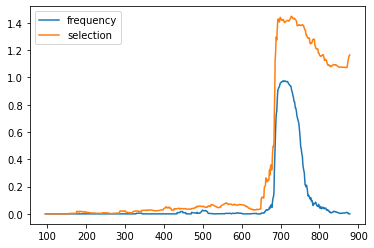

In [71]:
fig, ax = plt.subplots(1,1)
print(np.array(t_common)[s_omicron>0.135][0])
ax.plot(t_common, traj, label='frequency')
ax.plot(t_common, s_omicron, label='selection')
ax.legend()

In [131]:
# making a file containing the trajectories and the inferred selection over time
omicron = ['NSP3-38-1-G', 'NSP3-889-2-G', 'NSP3-1265-1--', 'NSP3-1265-2--', 'NSP3-1266-0--', 
           'NSP3-1892-0-A', 'NSP5-132-1-A', 'NSP6-189-0-G', 'NSP10-57-2-C', 'NSP14-42-0-G', 
           'S-211-1--', 'S-211-2--', 'S-212-0--', 'S-446-0-A', 'S-547-1-A', 
           'S-856-2-A', 'S-954-2-T', 'S-969-2-A', 'S-981-0-T', 'ORF3a-64-2-T', 
           'E-9-1-T', 'M-19-0-G', 'M-63-0-A', 'ORF6-20-0-C', 'ORF7b-18-0-T', 
           'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 
           'N-32-1--', 'N-32-2--', 'N-33-0--', 'S-484-1-C', 'S-375-1-T', 'S-493-1-G', 
           'S-496-0-A', 'S-498-1-G', 'S-505-0-C', 'S-547-1-A']
# removed: 'S-142-2--', 'S-143-0--', 'S-143-1--', 'S-144-2--', 'S-145-0--'
#site = 'S-446-0-A'
#site = 'S-67-1-T'
site = 'NSP3-38-1-G'

traj     = []
times    = []
traj_dir = os.path.join(DATA_DIR, 'trajectories-sa')
for file in os.listdir(traj_dir):
    if 'south africa' in file:
        df     = pd.read_csv(os.path.join(traj_dir, file))
        muts   = list(df.columns)[1:]
        sites  = [dp.get_label_new(str(i)) for i in muts]
        t_temp = list(df['time'])
        if site in sites:
            L = len(df)
            traj_temp = list(df[muts[sites.index(site)]])
            for i in range(len(t_temp)):
                times.append(t_temp[i])
                traj.append(traj_temp[i])
        else:
            for i in range(len(t_temp)):
                times.append(t_temp[i])
                traj.append(0)
sorter = np.argsort(times)
times  = np.array(times)[sorter]
traj   = np.array(traj)[sorter]

inf_data  = np.load(os.path.join(DATA_DIR, f'infer-tv-sa-2022-06-09', 'south-africa.npz'), allow_pickle=True)
selection = inf_data['selection']
alleles   = [dp.get_label_new(i) for i in inf_data['allele_number']]
t_infer   = inf_data['time_infer']
idxs      = np.array([alleles.index(i) for i in omicron])
s_omicron = np.sum(selection[:, idxs], axis=1)
#print(times)
#print(t_infer)
t_common  = [i for i in t_infer if i in times]
s_omicron = np.array(s_omicron)[np.isin(t_infer, t_common)]
traj      = traj[np.isin(times, t_common)]

sel_traj_file = os.path.join(DATA_DIR, 'omicron-tv-s-south-africa-muts.csv')
f = open(sel_traj_file, 'w')
f.write('time,frequency,selection\n')
for i in range(len(t_common)):
    f.write(f'{t_common[i]},{traj[i]},{s_omicron[i]}\n')
f.close()

662


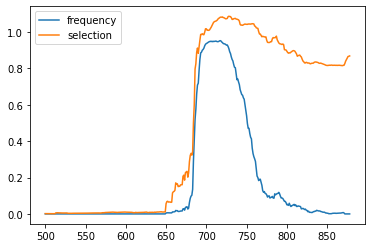

In [132]:
fig, ax = plt.subplots(1,1)
print(np.array(t_common)[s_omicron>0.135][0])
idxs_start = t_common.index(500)
ax.plot(t_common[idxs_start:], traj[idxs_start:], label='frequency')
ax.plot(t_common[idxs_start:], s_omicron[idxs_start:], label='selection')
ax.legend()

In [82]:
#print(times)
print('')
#print(t_infer)
print(np.array(times)[~np.isin(times, t_infer)])
print(np.array(t_infer)[~np.isin(t_infer, times)])


[93 94]
[108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123]


<a id=‘EU1_travel’></a>
# Inferring the selection coefficients in the United Kingdom including migration

In [ ]:
# Extracting an estimate for the time-varying number of infected in the United Kingdom
uk_filepath = []
uk_filename = []
for file in sorted(os.listdir(os.path.join(DATA_DIR, 'freqs'))):
    file_split = file.split('-')
    if file_split[1] == 'united kingdom' and file_split[2] == 'england_wales_scotland':
        year_end  = int(file_split[-3])
        month_end = int(file_split[-2])
        day_end   = int(file_split[-1][:-4])  
        if (dt.date(year_end, month_end, day_end) - dt.date(2021, 5, 5)).days < 0:  # take only data before the middle of may
            uk_filepath.append(os.path.join(DATA_DIR, 'freqs', file))
            uk_filename.append(file)
uk_dir = os.path.join(DATA_DIR, 'genome-uk')
if not os.path.exists(uk_dir):
    os.mkdir(uk_dir)
for path in uk_filepath:
    shutil.copy(path, uk_dir)

print(f'scp -r {uk_dir} {SSH_HOME}/{SSH_DATA}')

In [ ]:
# Finding selection coefficients in the uk only (up to may 1st 2021)
out_file   = 'infer-2021-08-14--2021-05-01-uk-g-10'
data       = os.path.join(SSH_DATA, DATA_DATE, 'genome-uk')
inf_script = 'epi-inf-parallel.py'

job_file  = 'job-infer-uk.sh'
job_str   = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=20:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/inf-error
#SBATCH -o ./MPL/out/inf-out

module purge
module load anaconda3

outfile={out_file}
python {inf_script} --data {data} --timed 1 -o $outfile -q 5 --g1 10
"""

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file)
print('')

print('scp %s%s %s' % (SSH_HOME, out_file + '.npz', INF_DIR))

In [ ]:
# finding all uk files and transferring them to their own directory
uk_filepath = []
uk_filename = []
for file in sorted(os.listdir(os.path.join(DATA_DIR, 'freqs'))):
    file_split = file.split('-')
    if file_split[1] == 'united kingdom' and file_split[2] == 'england_wales_scotland':
        year_end  = int(file_split[-3])
        month_end = int(file_split[-2])
        day_end   = int(file_split[-1][:-4])  
        uk_filepath.append(os.path.join(DATA_DIR, 'freqs', file))
        uk_filename.append(file)
uk_dir = os.path.join(DATA_DIR, 'genome-uk-full')
if not os.path.exists(uk_dir):
    os.mkdir(uk_dir)
for path in uk_filepath:
    shutil.copy(path, uk_dir)
    
print(f'scp -r {uk_dir} {SSH_HOME}{SSH_DATA}/{DATA_DATE}')

In [ ]:
# Finding selection coefficients in the uk only 
out_file2  = 'infer-2021-08-14-uk-g-10'
data       = os.path.join(SSH_DATA, DATA_DATE, 'genome-uk-full')
inf_script = 'epi-inf-parallel.py'

job_file  = 'job-infer-uk2.sh'
job_str   = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=10:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/inf-error
#SBATCH -o ./MPL/out/inf-out

module purge
module load anaconda3

outfile={out_file2}
python {inf_script} --data {data} --timed 1 -o $outfile -q 5 --g1 10
"""

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file)
print('')

print('scp %s%s %s' % (SSH_HOME, out_file2 + '.npz', INF_DIR))

In [ ]:
cutoff    = 0

data      = np.load(os.path.join(DATA_DIR, 'nucleotide-counts.npz'), allow_pickle=True)
muts      = data['allele_number']
counts    = data['counts']
regs      = [10]
for reg in regs:

    inf_data  = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-g-{reg}.npz'), allow_pickle=True)
    alleles   = inf_data['allele_number']
    selection = inf_data['selection']
    errors    = inf_data['error_bars']
    s_ind     = inf_data['selection_independent']
    numerator = inf_data['numerator']
    covar_int = inf_data['covar_int']
    locations = inf_data['locations']
    times     = inf_data['times']
    
    mask   = np.isin(muts, alleles)
    muts   = muts[mask]
    counts = counts[mask]

    print('data loaded')
    clip_start= 150
    nucs      = np.array([i[:-2] for i in alleles], dtype=int)

    mask      = np.nonzero(np.logical_and(np.logical_and(counts>cutoff, selection!=0), nucs > clip_start))[0]

    selection = selection[mask]
    alleles   = alleles[mask]
    errors    = errors[mask]
    s_ind     = s_ind[mask]
    numerator = numerator[mask]
    covar_int = covar_int[mask][:, mask]

    print('selection data filtered')

    traj      = inf_data['traj']
    mutants   = inf_data['mutant_sites']
    for i in range(len(mutants)):
        idxs_keep  = np.array([j for j in range(len(mutants[i])) if mutants[i][j] in alleles])
        mutants[i] = np.array(mutants[i])[idxs_keep]
        traj[i]    = np.array([traj[i][:, j] for j in range(len(traj[i][0])) if j in idxs_keep])
        traj[i]    = np.swapaxes(traj[i], 0, 1)
        #print(f'trajectory data filtered for  region {i} out of {len(mutants)}')
    
    np.savez_compressed(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-g-{reg}-observed.npz'), covar_int=covar_int, 
                       selection=selection, selection_independent=s_ind, error_bars=errors, numerator=numerator,
                       allele_number=alleles, traj=traj, mutant_sites=mutants, locations=locations, times=times)
    
    dp.website_file(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-g-{reg}-observed.npz'),
                    os.path.join(DATA_DIR, 'synonymous-test.npz'),
                    os.path.join(DATA_DIR, 'linked-sites.npy'), 
                    os.path.join(DATA_DIR, 'protein-changes'), 
                    os.path.join(DATA_DIR, f'selection-g-40-observed.csv'))

In [ ]:
# sites linked to S-222 mutation
NUC = ['-', 'A', 'C', 'G', 'T']
infer_data = np.load(os.path.join(INF_DIR, out_file + '.npz'), allow_pickle=True)
allele_num = infer_data['allele_number']
labels     = [dp.get_label(i[:-2]) + '-' + i[-1] for i in allele_num]

freq_data  = np.load(os.path.join(DATA_DIR, 'freq_0.05', 
                     'europe-united kingdom-england_wales_scotland-2020-01-01-2021-01-01.n---2020-2-24-2021-1-1.npz'),
                     allow_pickle=True)
nVec       = freq_data['nVec']
sVec       = freq_data['sVec']
times      = freq_data['times']
mutants    = freq_data['mutant_sites']
mask       = np.nonzero(mutants<29700)[0]
#mask       = np.nonzero(np.logical_and(mutants<29700), mutants>150)[0]
mutants    = mutants[mask]
sVec_temp  = []
for t in sVec:
    sVec_t = []
    for i in t:
        sVec_t.append(i[mask])
    sVec_temp.append(sVec_t)
sVec = sVec_temp
nuc_nums   = [dp.get_label(i) for i in mutants]
loc_sites  = []
for site in mutants:
    for j in range(5):
        loc_sites.append(dp.get_label(site) + '-' + NUC[j])

link_sites = ['ORF10-30-0-T', 'N-220-1-T', 'M-93-2-G', 'S-222-1-T', 'NSP16-199-2-C', 'NSP3-1189-2-T', 'NSP1-60-2-C']    # The linked mutations that will inflow
sites      = [allele_num[labels.index(i)] for i in link_sites]

# Find a sequence containing the desired list of mutations
inflow_seq = None
seq_found  = False
for i in range(len(sVec)):
    for j in range(len(sVec[i])):
        muts = True
        for k in range(len(link_sites)):
            if sVec[i][j][nuc_nums.index(link_sites[k][:-2])] != NUC.index(link_sites[k][-1]):
                muts = False
        if muts:
            inflow_seq = sVec[i][j]
            seq_found  = True
            break
    if seq_found:
        break
print(inflow_seq)        

In [ ]:
os.chdir(SCRIPT_DIR)
reload(dp)
os.chdir(SARS_DIR)

# Running the inference with different numbers of infected individuals migrating into the United Kingdom
est_dir = os.path.join(SARS_DIR, IHME_DATA)
file1   = os.path.join(est_dir, 'reference_hospitalization_all_locs.csv')
data1   = pd.read_csv(file1)
popsize = list(data1.est_infections_mean)
dates   = list(data1.date)
locs    = [i.lower() for i in list(data1.location_name)]
uk_popsize  = np.array(popsize)[np.array(locs)=='united kingdom']
uk_dates    = np.array(dates)[np.array(locs)=='united kingdom']
uk_dates    = uk_dates[~np.isnan(uk_popsize)]
uk_times    = [(dt.date.fromisoformat(uk_dates[i]) - dt.date(2020,1,1)).days for i in range(len(uk_dates))]
uk_popsize  = uk_popsize[~np.isnan(uk_popsize)]

inf_data  = np.load(os.path.join(INF_DIR, 'infer-2021-08-14--2021-05-01-uk-g-10' + '.npz'), allow_pickle=True)
alleles   = inf_data['allele_number']
numerator = inf_data['numerator']
covar_int = inf_data['covar_int']
traj      = inf_data['traj']
mutants   = inf_data['mutant_sites']
locs      = inf_data['locations']
dates     = inf_data['times']
idx       = list(locs).index('europe-united kingdom-england_wales_scotland-2020-01-01-2021-01-01.n---2020-2-24-2021-1-1')
traj_uk   = traj[idx]
muts_uk   = mutants[idx]
time      = dates[idx]

q   = 5
N   = 10000
k   = 0.1
R   = 2
g   = 10
g  *= (N * k) / (1 + (k / R))

for i in range(len(covar_int)):
    covar_int[i, i] += g
    
start_t    = 188    # number of days after february 24th 2020 that the individuals infected with 20E-EU1 start migrating
end_t      = 288
T          = end_t - start_t + 1
uk_popsize = uk_popsize[uk_times.index(start_t):uk_times.index(end_t)+1]
traj_uk    = traj_uk[list(time).index(start_t):list(time).index(end_t)+1]

ref_seq, ref_tag  = dp.get_MSA(REF_TAG +'.fasta')
ref_seq       = list(ref_seq[0])
allele_number = pd.unique([int(i[:-2]) for i in alleles])
mut_number    = pd.unique([int(i[:-2]) for i in muts_uk])
ref_poly      = np.array(ref_seq)[allele_number]

alleles_sorted = np.argsort(allele_number)
positions      = np.searchsorted(allele_number[alleles_sorted], mut_number)

counts     = [0, 4, 8, 10, 20, 50, 100, 500, 1000]
s_tot      = []
for i in range(len(counts)):
    count = counts[i]
    inflow_seqs   = [[inflow_seq] for i in range(T)]
    inflow_counts = [[count] for i in range(T)]
    pop_in        = [np.sum(i) for i in inflow_counts]
    inflow_term   = dp.allele_counter_in(inflow_seqs, inflow_counts, traj_uk, pop_in, uk_popsize, k, R, T, d=5)
    inflow_tot    = np.zeros(len(alleles))
    for j in range(len(mut_number)):
        inflow_tot[positions[j] * 5 : (positions[j] + 1) * 5] += inflow_term[j * 5 : (j + 1) * 5]
    A = covar_int
    b = numerator - inflow_tot
    
    s = linalg.solve(A, b, assume_a='sym')

    # normalize reference nucleotide to zero
    L = int(len(s) / 5)
    selection  = np.reshape(s, (L, 5))

    s_new = []
    for i in range(L):
        idx = NUC.index(ref_poly[i])
        temp_s    = selection[i]
        temp_s    = temp_s - temp_s[idx]
        s_new.append(temp_s)
    selection = s_new
    selection = np.array(selection).flatten()
    s_tot.append(selection)
    np.savez_compressed(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-inflow{count}.npz'), 
                        selection=selection, allele_number=allele_number)

In [ ]:
EU1 = [['NSP16-199-2-C', 'NSP1-60-2-C', 'NSP3-1189-2-T', 'M-93-2-G', 'N-220-1-T', 'ORF10-30-0-T', 'S-222-1-T']]
np.save(os.path.join(DATA_DIR, '20E-EU1'), EU1)

In [ ]:
if not os.path.exists(os.path.join(INF_DIR, 'inflow-uk')):
    os.mkdir(os.path.join(INF_DIR, 'inflow-uk'))
for count in counts:
    shutil.copy(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-inflow{count}.npz'), 
                os.path.join(INF_DIR, 'inflow-uk', f'infer-{DATA_DATE}-uk-inflow{count}.npz'))
    

In [ ]:
if not os.path.exists(os.path.join(INF_DIR, 'inflow-uk')):
    os.mkdir(os.path.join(INF_DIR, 'inflow-uk'))
inf_data  = np.load(os.path.join(INF_DIR, 'infer-2021-08-14--2021-05-01-uk-g-10' + '.npz'), allow_pickle=True)
alleles   = inf_data['allele_number']
counts     = [0, 4, 8, 10, 20, 50, 100, 500, 1000]
for count in counts:
    data = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk-inflow{count}.npz.npy'), allow_pickle=True)
    np.savez_compressed(os.path.join(INF_DIR, 'inflow-uk', f'infer-{DATA_DATE}-uk-inflow{count}.npz'),
                        selection=data, allele_number=alleles)


In [ ]:
sites    = [dp.get_label(i[:-2]) + '-' + i[-1] for i in alleles]
var_idxs = np.array([sites.index(site) for site in link_sites])
s_var    = np.zeros(len(s_tot))
for i in range(len(var_idxs)):
    for j in range(len(s_tot)):
        s_var[j] += s_tot[j][var_idxs[i]]
slope  = (s_var[4] - s_var[0]) / (counts[4] - counts[0])
x_zero = - s_var[0] / slope
print('number of migrating individuals per day in order for 20E-EU1 variant to be zero', x_zero)

<a id=‘alpha_mask’></a>
# Inferring the effect of Alpha on selection coefficients

In [ ]:
alpha = ['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',
         'NSP6-108-1--', 'NSP6-108-2--', 'S-501-0-T', 'NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 
         'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
         'S-69-2--', 'S-70-0--', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-570-1-A', 'S-681-1-A', 'S-716-1-T', 'S-982-0-G', 
         'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T',
         'N-203-1-A', 'N-203-2-A', 'N-204-0-C']
np.save(os.path.join(SARS_DIR, 'b117-muts.npy'), alpha)

cutoff     = 0

count_data = np.load(os.path.join(DATA_DIR, 'nucleotide-counts.npz'), allow_pickle=True)
muts       = count_data['allele_number']
counts     = count_data['counts']

# Same as above but for a single file
syn_data  = np.load(os.path.join(DATA_DIR, 'synonymous-prot.npz'), allow_pickle=True)
data      = np.load(os.path.join(INF_DIR, 'inf-2021-08-14', 'infer-2021-08-14-g-40.npz'), allow_pickle=True)

NUC = ['-', 'A', 'C', 'G', 'T']
q   = 5
N   = 10000
k   = 0.1
R   = 2
g   = 40
alleles   = data['allele_number']
numerator = data['numerator']
covar_int = data['covar_int']
syn_muts  = syn_data['nuc_index']
types     = syn_data['types']
types     = types[np.isin(syn_muts, alleles)]
g1 = np.array(g, dtype=float) * (N * k) / (1 + (k / R))
for i in range(len(covar_int)):
    covar_int[i, i] += g1
    
# Mask out sites that have mutations in alpha
alpha_short = np.array([i[:-2] for i in alpha])
muts_short  = np.array([dp.get_label2(i)[:-2] for i in alleles])
mask        = np.isin(muts_short, alpha_short, invert=True)
alleles     = alleles[mask]
numerator   = numerator[mask]
covar_int   = covar_int[mask][:, mask]
types       = types[mask]
counts      = counts[mask]

# infer selection coefficients
s      = linalg.solve(covar_int, numerator, assume_a='sym')
s_ind  = numerator / np.diag(covar_int)
errors = 1 / np.sqrt(np.absolute(np.diag(covar_int)))

print('selection coefficients found')

# normalize reference nucleotide to zero
L = int(len(s) / 5)
selection  = np.reshape(s, (L, q))
selection_nocovar = np.reshape(s_ind, (L, q))
ref_seq, ref_tag  = dp.get_MSA(REF_TAG +'.fasta')
ref_seq  = list(ref_seq[0])
allele_number = np.unique([int(i[:-2]) for i in alleles])
ref_poly = np.array(ref_seq)[allele_number]

s_new = []
s_SL  = []
for i in range(L):
    idx = NUC.index(ref_poly[i])
    temp_s    = selection[i]
    temp_s    = temp_s - temp_s[idx]
    temp_s_SL = selection_nocovar[i]
    temp_s_SL = temp_s_SL - temp_s_SL[idx]
    s_new.append(temp_s)
    s_SL.append(temp_s_SL)
selection         = s_new
selection_nocovar = s_SL

selection         = np.array(selection).flatten()
selection_nocovar = np.array(selection_nocovar).flatten()
error_bars        = errors

# Eliminate reference nucleotides and mutations that aren't observed

mask      = np.nonzero(np.logical_and(selection!=0, counts>cutoff))[0]
alleles   = alleles[mask]
selection = selection[mask]
s_ind     = selection_nocovar[mask]
errors    = error_bars[mask]

In [ ]:
traj      = data['traj']
mutants   = data['mutant_sites']
for i in range(len(mutants)):
    idxs_keep  = np.array([j for j in range(len(mutants[i])) if mutants[i][j] in alleles])
    mutants[i] = np.array(mutants[i])[idxs_keep]
    traj[i]    = np.array([traj[i][:, j] for j in range(len(traj[i][0])) if j in idxs_keep])
    traj[i]    = np.swapaxes(traj[i], 0, 1)

np.savez_compressed(os.path.join(INF_DIR, f'infer-{DATA_DATE}-g-{g}-observed-mask-alpha.npz'),
                    selection=selection, selection_independent=s_ind, error_bars=errors,
                    allele_number=alleles, traj=traj, mutant_sites=mutants)
    
dp.website_file2(os.path.join(INF_DIR,  f'infer-{DATA_DATE}-g-{g}-observed-mask-alpha.npz'),
                 os.path.join(DATA_DIR,  'synonymous-test.npz'),
                 os.path.join(DATA_DIR,  'linked-sites.npy'), 
                 os.path.join(DATA_DIR,  'protein-changes-test'), 
                 os.path.join(DATA_DIR, f'selection-g-40-observed-mask-alpha.csv'))

In [ ]:
unmasked    = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-g-40-observed.npz'), allow_pickle=True)
masked      = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-g-{g}-observed-mask-alpha.npz'), allow_pickle=True)
s_unmask    = unmasked['selection']
s_mask      = masked['selection']
muts_mask   = [dp.get_label2(i) for i in masked['allele_number']]
muts_unmask = [dp.get_label2(i) for i in unmasked['allele_number']]
link_sites  = ['ORF10-30-0-T', 'N-220-1-T', 'M-93-2-G', 'S-222-1-T', 'NSP16-199-2-C', 'NSP3-1189-2-T', 'NSP1-60-2-C']

sel_mask    = np.sum(s_mask[np.isin(muts_mask, link_sites)])
sel_unmask  = np.sum(s_unmask[np.isin(muts_unmask, link_sites)])
print('selection coefficient for 20E-EU1 when alpha is kept in the data:                               ', sel_unmask)
print('selection coefficient for 20E-EU1 when alpha mutations are reverted to the reference nucleotide:', sel_mask)

In [90]:
unmasked    = np.load(os.path.join(INF_DIR, f'infer-2021-08-14-g-40-observed.npz'), allow_pickle=True)
masked      = np.load(os.path.join(INF_DIR, f'infer-2021-08-14-g-40-observed-mask-alpha.npz'), allow_pickle=True)
s_unmask    = unmasked['selection']
s_mask      = masked['selection']
muts_mask   = [dp.get_label2(i) for i in masked['allele_number']]
muts_unmask = [dp.get_label2(i) for i in unmasked['allele_number']]
link_sites  = ['ORF10-30-0-T', 'N-220-1-T', 'M-93-2-G', 'S-222-1-T', 'NSP16-199-2-C', 'NSP3-1189-2-T', 'NSP1-60-2-C']

sel_mask    = np.sum(s_mask[np.isin(muts_mask, link_sites)])
sel_unmask  = np.sum(s_unmask[np.isin(muts_unmask, link_sites)])
print('selection coefficient for 20E-EU1 when alpha is kept in the data:                               ', sel_unmask)
print('selection coefficient for 20E-EU1 when alpha mutations are reverted to the reference nucleotide:', sel_mask)

selection coefficient for 20E-EU1 when alpha is kept in the data:                                0.10225873676301382
selection coefficient for 20E-EU1 when alpha mutations are reverted to the reference nucleotide: -0.01673100542328889


In [ ]:
# Finding the opposite: the inferred coefficient for 20E-EU1 when Alpha is masked
EU1 = ['ORF10-30-0-T', 'N-220-1-T', 'M-93-2-G', 'S-222-1-T', 'NSP16-199-2-C', 'NSP3-1189-2-T', 'NSP1-60-2-C']
np.save(os.path.join(SARS_DIR, 'eu1-muts.npy'), EU1)

cutoff     = 0

count_data = np.load(os.path.join(DATA_DIR, 'nucleotide-counts.npz'), allow_pickle=True)
muts       = count_data['allele_number']
counts     = count_data['counts']

# Same as above but for a single file
syn_data  = np.load(os.path.join(DATA_DIR, 'synonymous-prot-test.npz'), allow_pickle=True)
data      = np.load(os.path.join(INF_DIR, f'inf-{DATA_DATE}', f'infer-{DATA_DATE}-g-40.npz'), allow_pickle=True)

NUC = ['-', 'A', 'C', 'G', 'T']
q   = 5
N   = 10000
k   = 0.1
R   = 2
g   = 40
alleles   = data['allele_number']
numerator = data['numerator']
covar_int = data['covar_int']
syn_muts  = syn_data['nuc_index']
types     = syn_data['types']
types     = types[np.isin(syn_muts, alleles)]
g1 = np.array(g, dtype=float) * (N * k) / (1 + (k / R))
for i in range(len(covar_int)):
    covar_int[i, i] += g1
    
# Mask out sites that have mutations in alpha
EU1_short   = np.array([i[:-2] for i in EU1])
muts_short  = np.array([dp.get_label2(i)[:-2] for i in alleles])
mask        = np.isin(muts_short, EU1_short, invert=True)
alleles     = alleles[mask]
numerator   = numerator[mask]
covar_int   = covar_int[mask][:, mask]
types       = types[mask]
counts      = counts[mask]

# infer selection coefficients
s      = linalg.solve(covar_int, numerator, assume_a='sym')
s_ind  = numerator / np.diag(covar_int)
errors = 1 / np.sqrt(np.absolute(np.diag(covar_int)))

print('selection coefficients found')

# normalize reference nucleotide to zero
L = int(len(s) / 5)
selection  = np.reshape(s, (L, q))
selection_nocovar = np.reshape(s_ind, (L, q))
ref_seq, ref_tag  = dp.get_MSA(REF_TAG +'.fasta')
ref_seq  = list(ref_seq[0])
allele_number = np.unique([int(i[:-2]) for i in alleles])
ref_poly = np.array(ref_seq)[allele_number]

s_new = []statisticsne
s_SL  = []
for i in range(L):
    idx = NUC.index(ref_poly[i])
    temp_s    = selection[i]
    temp_s    = temp_s - temp_s[idx]
    temp_s_SL = selection_nocovar[i]
    temp_s_SL = temp_s_SL - temp_s_SL[idx]
    s_new.append(temp_s)
    s_SL.append(temp_s_SL)
selection         = s_new
selection_nocovar = s_SL

selection         = np.array(selection).flatten()
selection_nocovar = np.array(selection_nocovar).flatten()
error_bars        = errors

# Eliminate reference nucleotides and mutations that aren't observed

mask      = np.nonzero(np.logical_and(selection!=0, counts>cutoff))[0]
alleles   = alleles[mask]
selection = selection[mask]
s_ind     = selection_nocovar[mask]
errors    = error_bars[mask]

traj      = data['traj']
mutants   = data['mutant_sites']
for i in range(len(mutants)):
    idxs_keep  = np.array([j for j in range(len(mutants[i])) if mutants[i][j] in alleles])
    mutants[i] = np.array(mutants[i])[idxs_keep]
    traj[i]    = np.array([traj[i][:, j] for j in range(len(traj[i][0])) if j in idxs_keep])
    traj[i]    = np.swapaxes(traj[i], 0, 1)

np.savez_compressed(os.path.join(INF_DIR, f'infer-{DATA_DATE}-g-{g}-observed-mask-eu1.npz'),
                    selection=selection, selection_independent=s_ind, error_bars=errors,
                    allele_number=alleles, traj=traj, mutant_sites=mutants)

dp.website_file2(os.path.join(INF_DIR, f'infer-{DATA_DATE}-g-{g}-observed-mask-eu1.npz'),
                 os.path.join(DATA_DIR, 'synonymous-prot-test.npz'),
                 os.path.join(DATA_DIR, 'linked-sites.npy'), 
                 os.path.join(DATA_DIR, f'selection-g-40-observed-mask-eu1.csv'))

unmasked    = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-g-40-observed.npz'), allow_pickle=True)
masked      = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}-g-{g}-observed-mask-eu1.npz'), allow_pickle=True)
s_unmask    = unmasked['selection']
s_mask      = masked['selection']
muts_mask   = [dp.get_label2(i) for i in masked['allele_number']]
muts_unmask = [dp.get_label2(i) for i in unmasked['allele_number']]
link_sites  = ['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',
               'NSP6-108-1--', 'NSP6-108-2--', 'S-501-0-T', 'NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 
               'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
               'S-69-2--', 'S-70-0--', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-570-1-A', 'S-681-1-A', 'S-716-1-T', 'S-982-0-G', 
               'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T',
               'N-203-1-A', 'N-203-2-A', 'N-204-0-C']

sel_mask    = np.sum(s_mask[np.isin(muts_mask, link_sites)])
sel_unmask  = np.sum(s_unmask[np.isin(muts_unmask, link_sites)])
print('selection coefficient for Alpha when EU1 is kept in the data:                               ', sel_unmask)
print('selection coefficient for Alpha when EU1 mutations are reverted to the reference nucleotide:', sel_mask)

<a id='statistics'></a>
# Calculating Statistics  

In [ ]:
# Finding the correlation between frequency changes for B.1.1.7 and 20E-EU1
traj_file = os.path.join(DATA_DIR, 'linked-trajectories.csv')
cwd = os.getcwd()
os.chdir(SCRIPT_DIR)
reload(dp)
os.chdir(cwd)
print('correlation of frequency changes:', dp.freq_change_correlation(traj_file, 'alpha', '20E_EU1'))

cwd = os.getcwd()
os.chdir(SCRIPT_DIR)
reload(dp)
os.chdir(cwd)
print('correlation of frequency changes in UK:', dp.freq_change_correlation(traj_file, 'alpha', '20E_EU1', 
                                                                            region='europe-united kingdom-england_wales_scotland-2020-01-01-2021-01-01.n---2020-2-24-2021-1-1'))

print('correlation of frequency changes in UK:', dp.freq_change_correlation(traj_file, 'alpha', '20E_EU1', 
                                                                            region=['europe-united kingdom-england_wales_scotland-2020-01-01-2021-01-01.n---2020-2-24-2021-1-1',
                                                                                    'europe-united kingdom-england_wales_scotland-2021-01-01-2021-05-01.n---2020-12-29-2021-5-1']))


In [ ]:
counts = 0
for file in os.listdir(os.path.join(DATA_DIR, 'genome-filtered')):
    if 'sites' in file:
        continue
    df = pd.read_csv(os.path.join(DATA_DIR, 'genome-filtered', file))
    counts += len(df)
print(f'total number of sequences used = {counts}')

lengths = []
for file in os.listdir(os.path.join(DATA_DIR, 'genome-filtered')):
    if 'sites' not in file:
        continue
    lengths.append(len(pd.read_csv(os.path.join(DATA_DIR, 'genome-filtered', file))))
L = np.amax(lengths)
print(f'longest sequence in any region is {L}, which is approximately {L / 29900} percent of sites')

In [286]:
# Counting the number of ambiguous nucleotides in the sequences used for analysis
regions_dir   = os.path.join(SSH_DATA, f'regions-times-{DATA_DATE}')
script        = 'count-ambiguous.py'
out_file      = os.path.join(SSH_DATA, DATA_DATE, 'number-ambiguous')
msa_file      = os.path.join(SSH_DATA, MERGED_FINAL)


job_file1     = 'job-count-ambiguous.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=700G
#SBATCH --time=18:00:00
#SBATCH -e ./MPL/out/count-ambiguous-error
#SBATCH -o ./MPL/out/count-ambiguous-out
#SBATCH -p highmem

module unload miniconda2 
module load miniconda3

conda activate sars-env

python {script} --regions {regions_dir} -o {out_file} --input_file {msa_file}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

print(f'scp {SCRIPT_DIR}/{script} {SSH_HOME} &&')
print(f'scp {SCRIPT_DIR}/{job_file1} {SSH_HOME}')

scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/count-ambiguous.py blee098@secure.hpcc.ucr.edu: &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-count-ambiguous.sh blee098@secure.hpcc.ucr.edu:


In [411]:
data = np.load(os.path.join(DATA_DIR, 'number-ambiguous.npz'), allow_pickle=True)
print([i for i in data])
num_ambig = data['number_ambiguous']
num_ns    = data['number_ns']
num_seqs  = data['number_sequences']
genome_length = 29903 - (29903 - 29690) - 150 + 9
print(f'There are {num_ambig} ambiguous nucleotides in the used sequences')
print(f'There are {num_ns} Ns in the used sequences')
print(f'There are a total of {num_seqs * genome_length} sites in all of the used data')
print(f'Percentage of sites that are ambiguous is {num_ambig / (num_seqs * genome_length)}')

['number_ambiguous', 'number_ns', 'number_sequences']
There are 868790107 ambiguous nucleotides in the used sequences
There are 867716835 Ns in the used sequences
There are a total of 133558938786 sites in all of the used data
Percentage of sites that are ambiguous is 0.006504919213172641


['number_ambiguous', 'number_ns', 'number_sequences', 'ns_sequence']
There are 1346553 sequences in the analysis
There are 200899091 ambiguous nucleotides in the used sequences
There are 200476507 Ns in the used sequences
There are a total of 39789294597 sites in all of the used data
Percentage of sites that are ambiguous is 0.005049073954056658

number of sequences with more than 1000 Ns is 48097
number of sequences with more than 300 Ns is 215780
number of sequences with more than 100 Ns is 398532
number of sequences with more than 0 Ns is 600715


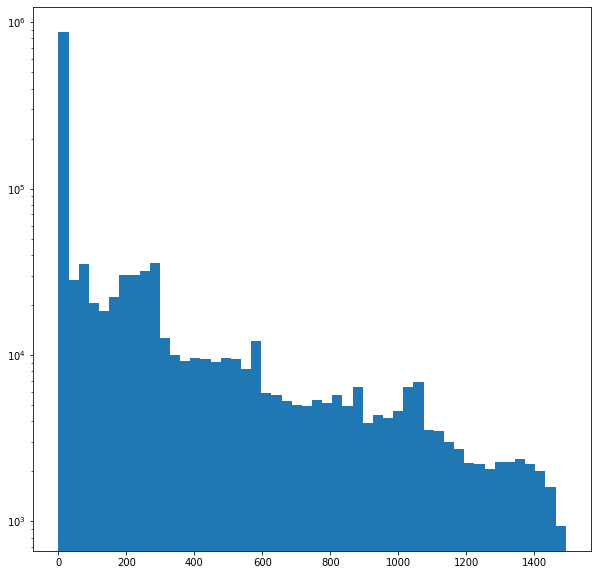

In [145]:
data = np.load(os.path.join(SARS_DIR, old_date, 'number-ambiguous.npz'), allow_pickle=True)
print([i for i in data])
num_ambig = data['number_ambiguous']
num_ns    = data['number_ns']
num_seqs  = data['number_sequences']
genome_length = 29903 - (29903 - 29690) - 150 + 9
print(f'There are {num_seqs} sequences in the analysis')
print(f'There are {num_ambig} ambiguous nucleotides in the used sequences')
print(f'There are {num_ns} Ns in the used sequences')
print(f'There are a total of {num_seqs * genome_length} sites in all of the used data')
print(f'Percentage of sites that are ambiguous is {num_ambig / (num_seqs * genome_length)}')
print('')
ns_sequence = data['ns_sequence']

fig, ax = plt.subplots(1,1, figsize=[10,10])
_ = ax.hist(ns_sequence, log=True, bins=50)
print(f'number of sequences with more than 1000 Ns is {np.count_nonzero(ns_sequence>1000)}')
print(f'number of sequences with more than 300 Ns is {np.count_nonzero(ns_sequence>300)}')
print(f'number of sequences with more than 100 Ns is {np.count_nonzero(ns_sequence>100)}')
print(f'number of sequences with more than 0 Ns is {np.count_nonzero(ns_sequence>0)}')

In [23]:
# Looking at integrated partial correlations
data_date = DATA_DATE

def normalizer(m, g):
    """given a covariance matrix m and a regularization g, 
    return the maximum value that the correlation matrix should have if sites were fully linked"""
    return 1 / (1 - (g / np.mean(m)) - len(m))

alpha = ['S-501-0-T', 'NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 
         'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C',
         'S-570-1-A', 'S-716-1-T', 'S-982-0-G', 
         'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T'] 
# 'NSP4-492-1-T'
delta = ['NSP12-671-0-A', 'NC-209-T', 'NSP13-77-1-T', 'S-19-1-G', 'S-478-1-A', 'S-681-1-G', 'S-950-0-A', 
         'ORF3a-26-1-T', 'M-82-1-C', 'ORF7a-82-1-C', 'ORF7a-120-1-T', 'N-63-1-G', 'N-203-1-T', 
         'N-377-0-T', 'S-452-1-G']  

omicron = ['NSP3-38-1-G', 'NSP3-889-2-G', 
           'NSP3-1892-0-A', 'NSP4-492-1-T', 'NSP5-132-1-A', 'NSP6-189-0-G', 'NSP10-57-2-C', 
           'NSP12-600-2-T', 'S-67-1-T', 'S-339-1-A', 'S-371-0-C', 
           'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-446-0-A', 'S-547-1-A', 'S-655-0-T', 
           'S-679-2-G', 'S-764-2-A', 'S-796-0-T', 'S-856-2-A', 'S-954-2-T', 'S-969-2-A', 'S-981-0-T', 
           'S-1146-2-T', 'ORF3a-64-2-T', 'E-9-1-T', 'M-3-1-G', 'M-19-0-G', 'M-63-0-A', 'ORF6-20-0-C', 
           'N-13-1-T', 'S-375-1-T', 'S-477-1-A', 'S-478-1-A', 
           'S-484-1-C', 'S-493-1-G', 'S-496-0-A', 'S-498-1-G', 'S-505-0-C', 'NSP14-42-0-G'] 

n = 10000
k = 0.1
R = 2
g = 40
c = (n * k * R) / (k + R)
#g *= c
data  = np.load(os.path.join(INF_DIR, f'infer-{data_date}.npz'), allow_pickle=True)
muts  = [dp.get_label_new(i) for i in data['allele_number']]
covar = (data['covar_int'] / c)
alpha = sorted([i for i in alpha if i in muts])
delta = sorted([i for i in delta if i in muts])
print(f'alpha covariance entry: {np.mean([covar[muts.index(i), muts.index(i)] for i in alpha])}')
print(f'delta covariance entry: {np.mean([covar[muts.index(i), muts.index(i)] for i in delta])}')
covar = covar + np.diag(np.ones(len(covar))) * g
covar_inv  = linalg.inv(covar)
bare_covar = covar - np.diag(np.ones(len(covar))) * g

alpha_idxs  = np.array([muts.index(i) for i in alpha])
alpha_covar = covar_inv[alpha_idxs][:, alpha_idxs]    # the inverse covariance matrix for only alpha entries
L           = len(alpha_covar)
new_covar   = np.ones((L, L))
for i in range(L):
    for j in range(L):
        new_covar[i, j] = alpha_covar[i, j] / np.sqrt(alpha_covar[i, i] * alpha_covar[j, j])
alpha_df = pd.DataFrame(data=new_covar, columns=alpha, index=alpha)
alpha_df.to_csv(os.path.join(SARS_DIR, data_date, f'alpha-correlation-{DATA_DATE}.csv'))
alpha_sub_covar = bare_covar[alpha_idxs][:, alpha_idxs]
new_covar       = new_covar / normalizer(alpha_sub_covar, g)
alpha_df = pd.DataFrame(data=new_covar, columns=alpha, index=alpha)
alpha_df.to_csv(os.path.join(SARS_DIR, data_date, f'alpha-correlation-normed-{DATA_DATE}.csv'))
    
delta       = sorted([i for i in delta if i in muts])
delta_idxs  = np.array([muts.index(i) for i in delta])
delta_covar = covar_inv[delta_idxs][:, delta_idxs]
L           = len(delta_covar)
new_covar   = np.ones((L, L))
for i in range(L):
    for j in range(L):
        new_covar[i, j] = delta_covar[i, j] / np.sqrt(delta_covar[i, i] * delta_covar[j, j])
delta_df = pd.DataFrame(data=new_covar, columns=delta, index=delta)
delta_df.to_csv(os.path.join(SARS_DIR, data_date, f'delta-correlation-{DATA_DATE}.csv'))
delta_sub_covar = bare_covar[delta_idxs][:, delta_idxs]
new_covar       = new_covar / normalizer(delta_sub_covar, g)
delta_df = pd.DataFrame(data=new_covar, columns=delta, index=delta)
delta_df.to_csv(os.path.join(SARS_DIR, data_date, f'delta-correlation-normed-{DATA_DATE}.csv'))

omicron       = sorted([i for i in omicron if i in muts])
omicron_idxs  = np.array([muts.index(i) for i in omicron])
omicron_covar = covar_inv[omicron_idxs][:, omicron_idxs]
L           = len(omicron_covar)
new_covar   = np.ones((L, L))
for i in range(L):
    for j in range(L):
        new_covar[i, j] = omicron_covar[i, j] / np.sqrt(omicron_covar[i, i] * omicron_covar[j, j])
omicron_df = pd.DataFrame(data=new_covar, columns=omicron, index=omicron)
omicron_df.to_csv(os.path.join(SARS_DIR, data_date, f'omicron-correlation-{DATA_DATE}.csv'))
omicron_sub_covar = bare_covar[omicron_idxs][:, omicron_idxs]
new_covar       = new_covar / normalizer(omicron_sub_covar, g)
omicron_df = pd.DataFrame(data=new_covar, columns=omicron, index=omicron)
omicron_df.to_csv(os.path.join(SARS_DIR, data_date, f'omicron-correlation-normed-{DATA_DATE}.csv'))

alpha covariance entry: 405.97825335960823
delta covariance entry: 287.5670967294807


__Manually fixing gaps in the map from nucleotide mutations to amino acid mutations__

In [385]:
gap_muts = []
for i in var_dic:
    gaps_temp = [j for j in var_dic[i] if j[-1]=='-']
    gap_muts.append(gaps_temp)
print(gap_muts)
gaps [#['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--',
      # 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--'], 
      ['NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--']
      ['S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--'],
      ['S-240-1--', 'S-240-2--', 'S-241-0--', 'S-241-1--', 'S-241-2--', 'S-242-0--' 'S-242-1--', 'S-242-2--', 'S-243-0--'],
      ['S-246-1--', 'S-246-2--', 'S-247-0--', 'S-247-1--', 'S-247-2--', 'S-248-0--', 'S-248-1--', 
       'S-248-2--', 'S-249-0--', 'S-249-1--', 'S-249-2--', 'S-250-0--', 'S-250-1--', 'S-250-2--', 
       'S-251-0--', 'S-251-1--', 'S-251-2--', 'S-252-0--', 'S-252-1--', 'S-252-2--', 'S-253-0--'],
      ['S-156-1--', 'S-156-2--', 'S-157-0--', 'S-157-1--', 'S-157-2--', 'S-158-0--'],
      #['ORF8-119-0--', 'ORF8-119-1--', 'ORF8-119-2--', 'ORF8-120-0--', 'ORF8-120-1--', 'ORF8-120-2--'],
      ['NSP3-1265-1--', 'NSP3-1265-2--', 'NSP3-1266-0--'],
      ['S-211-1--', 'S-211-2--', 'S-212-0--'],
      ['N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 'N-32-1--', 'N-32-2--', 'N-33-0--'],
      ['S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--', 'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--'],
      #['ORF6-2-0--', 'ORF6-2-1--', 'ORF6-2-2--'],
      ['N-2-1--', 'N-2-2--', 'N-3-0--']]
      
      
additional = [['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--',
               'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--'],
              ['NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--'],
              ['ORF7b-44-1--'],
              ['S-142-1--', 'S-142-2--', 'S-143-0--', 'S-143-1--', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-144-2--', 'S-145-0--'],
              ['S-143-2--', 'S-144-0--', 'S-144-1--'],
              ['ORF8-1-0--', 'ORF8-1-1--', 'ORF8-1-2--', 'ORF8-2-0--', 'ORF8-2-1--', 'ORF8-2-2--', 'ORF8-3-0--', 'ORF8-3-1--']]
# How to deal with it when there are different overlapping groups of deletions

# orf7b-44-1 and the orf8 mutations should cause a frameshift, correct? (both are in B.1.1.318)

[['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'S-143-2--', 'S-144-0--', 'S-144-1--'], [], ['S-240-2--', 'S-241-0--', 'S-242-1--', 'S-242-2--', 'S-243-0--', 'S-240-1--', 'S-241-1--', 'S-241-2--', 'S-242-0--', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--'], ['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--'], ['S-246-2--', 'S-247-0--', 'S-247-1--', 'S-247-2--', 'S-248-0--', 'S-248-1--', 'S-248-2--', 'S-249-0--', 'S-249-1--', 'S-249-2--', 'S-250-0--', 'S-250-1--', 'S-250-2--', 'S-251-0--', 'S-251-1--', 'S-251-2--', 'S-252-0--', 'S-252-1--', 'S-252-2--', 'S-253-0--', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP

In [482]:
syn_file  = np.load(os.path.join(DATA_DIR, 'synonymous-prot-test.npz'), allow_pickle=True)
nuc_index  = syn_file['nuc_index']
locs       = list(syn_file['locations'])
aa_changes = syn_file['aa_changes']
types      = syn_file['types']

nuc_pos    = [i[:-2] for i in nuc_index]
nucs       = [i[-1]  for i in nuc_index]

ref_df     = pd.read_csv(os.path.join(DATA_DIR, 'ref-index.csv'))
ref_index  = list(ref_df['ref_index'])
ref_nucs   = list(ref_df['nucleotide'])
ref_nucs   = [ref_nucs[i] for i in range(len(ref_nucs)) if ref_index[i][0]!='-']
ref_index  = [ref_index[i] for i in range(len(ref_index)) if ref_index[i][0]!='-']
ref_labels = [dp.get_label_new(ref_index[i] + '-' + ref_nucs[i]) for i in range(len(ref_index))]
ref_short  = [i[:-2] for i in ref_labels]

#for i in range(len(ref_short)):
#    if ref_short[i][:-2] in ['NSP6-104', 'NSP6-107']:
#        print(ref_labels[i])
#print(nuc_index[:10])
#print(locs[:10])
#print(aa_changes[:10])

In [484]:
start_site = 'S-142'
end_site   = 'S-145'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
#print(ref_labels[30000:])
new_codon = 'GAC'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

S-142-0-G
S-142-1-G
S-142-2-T
S-145-0-T
S-145-1-A
S-145-2-C
D G Y


In [485]:
aa_changes[list(locs).index(end_site + '-0--')] = 'Y>D'
#aa_changes[list(locs).index(start_site + '-2--')] = 'S>S'

In [473]:
start_site = 'S-24'
end_site   = 'S-27'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
#print(ref_labels[30000:])
new_codon = 'TCA'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

N-2-0-T
N-2-1-C
N-2-2-T
N-3-0-G
N-3-1-A
N-3-2-T
S S D


In [472]:
aa_changes[list(locs).index(end_site + '-0--')] = 'A>S'
#aa_changes[list(locs).index(start_site + '-2--')] = 'S>S'

In [475]:
start_site = 'N-2'
end_site   = 'N-3'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
#print(ref_labels[30000:])
new_codon = 'TAT'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

N-2-0-T
N-2-1-C
N-2-2-T
N-3-0-G
N-3-1-A
N-3-2-T
Y S D


In [476]:
aa_changes[list(locs).index(end_site + '-0--')] = 'D>Y'
#aa_changes[list(locs).index(start_site + '-2--')] = 'S>S'

In [468]:
start_site = 'N-30'
end_site   = 'N-33'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
#print(ref_labels[30000:])
new_codon = 'GGT'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

N-30-0-G
N-30-1-G
N-30-2-A
N-33-0-A
N-33-1-G
N-33-2-T
G G S


In [469]:
aa_changes[list(locs).index(start_site + '-1--')] = 'G>G'
aa_changes[list(locs).index(start_site + '-2--')] = 'G>G'

In [465]:
start_site = 'S-211'
end_site   = 'S-212'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
#print(ref_labels[30000:])
new_codon = 'ATA'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

S-211-0-A
S-211-1-A
S-211-2-T
S-212-0-T
S-212-1-T
S-212-2-A
I N L


In [466]:
aa_changes[list(locs).index(end_site + '-0--')] = 'L>I'
#aa_changes[list(locs).index(start_site + '-2--')] = 'S>S'

In [460]:
start_site = 'NSP3-1265'
end_site   = 'NSP3-1266'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
#print(ref_labels[30000:])
new_codon = 'TCA'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

NSP3-1265-0-A
NSP3-1265-1-G
NSP3-1265-2-T
NSP3-1266-0-T
NSP3-1266-1-T
NSP3-1266-2-A
S S L


In [463]:
aa_changes[list(locs).index(start_site + '-1--')] = 'S>S'
aa_changes[list(locs).index(start_site + '-2--')] = 'S>S'

In [458]:
start_site = 'S-156'
end_site   = 'S-158'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
new_codon = 'GGA'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

S-156-0-G
S-156-1-A
S-156-2-G
S-158-0-A
S-158-1-G
S-158-2-A
G E R


In [459]:
aa_changes[list(locs).index(end_site + '-0--')] = 'R>G'
#aa_changes[list(locs).index(end_site + '-2--')] = 'R>G'

In [456]:
start_site = 'S-246'
end_site   = 'S-253'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
new_codon = 'AAT'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

S-246-0-A
S-246-1-G
S-246-2-A
S-253-0-G
S-253-1-A
S-253-2-T
N R D


In [457]:
aa_changes[list(locs).index(end_site + '-0--')] = 'D>N'
#aa_changes[list(locs).index(end_site + '-2--')] = 'D>N'

In [455]:
start_site = 'S-240'
end_site   = 'S-243'
for i in range(len(ref_short)):
    if ref_short[i][:-2] in [start_site, end_site]:
        print(ref_labels[i])
new_codon = 'ACT'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index(start_site + '-1-A')][0]
old_aa2   = aa_changes[list(locs).index(end_site + '-1-A')][0]
print(new_aa, old_aa1, old_aa2)

aa_changes[list(locs).index(start_site + '-1--')] = 'T>T'
aa_changes[list(locs).index(start_site + '-2--')] = 'T>T'

S-240-0-A
S-240-1-C
S-240-2-T
S-243-0-G
S-243-1-C
S-243-2-T
T T A


In [454]:
for i in range(len(ref_short)):
    if ref_short[i][:-2] in ['S-68', 'S-70']:
        print(ref_labels[i])
new_codon = 'ATC'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index('S-68-1-A')][0]
old_aa2   = aa_changes[list(locs).index('S-70-1-A')][0]
print(new_aa, old_aa1, old_aa2)

aa_changes[list(locs).index('S-68-1--')] = 'I>I'
aa_changes[list(locs).index('S-68-2--')] = 'I>I'

S-68-0-A
S-68-1-T
S-68-2-A
S-70-0-G
S-70-1-T
S-70-2-C
I I V


In [453]:
for i in range(len(ref_short)):
    if ref_short[i][:-2] in ['NSP6-104', 'NSP6-107']:
        print(ref_labels[i])
new_codon = 'AGT'
new_aa    = dp.codon2aa(new_codon)
old_aa1   = aa_changes[list(locs).index('NSP6-107-0-A')][0]
old_aa2   = aa_changes[list(locs).index('NSP6-104-1-A')][0]
print(new_aa, old_aa1, old_aa2)

aa_changes[list(locs).index('NSP6-104-1--')] = 'S>S'
aa_changes[list(locs).index('NSP6-104-2--')] = 'S>S'
# NOTE: LEAVING NONSYNONYMOUS BECUASE THESE MUTATIONS ARE IMPORTANT FOR INFERENCE

NSP6-104-0-A
NSP6-104-1-G
NSP6-104-2-T
NSP6-107-0-G
NSP6-107-1-G
NSP6-107-2-T
S G S


In [486]:
new_file = open(os.path.join(DATA_DIR, 'synonymous-prot-fixed.npz'), mode='wb')
np.savez_compressed(new_file, nuc_index=nuc_index, locations=locs, aa_changes=aa_changes, types=types)
new_file.close()

In [479]:
data = np.load(os.path.join(DATA_DIR, 'synonymous-prot-fixed.npz'), allow_pickle=True)
locs = data['locations']
aas  = data['aa_changes']
print(aas[list(locs).index('NSP6-104-1-A')])

S>N


<a id='selection_on_date'></a>
# Variant selection before appearance 

In [325]:
# infering the selection coefficients using a cutoff frequency of 5% in the 
DATA_DATE = '2022-06-09'

inf_script    = 'epi-inf-parallel-tv-allregs.py'
freqs_dir     = os.path.join(SSH_DATA, 'freqs-regional2')
out_file      = os.path.join(SSH_DATA, DATA_DATE, f'infer-tv-allregs')
dates         = ['2020-09-20', '2020-12-14', '2020-11-24', '2021-11-01']
new_dates     = [(dt.date.fromisoformat(i) - dt.date(2020,1,1)).days for i in dates]
print(new_dates)

job_file2 = 'job-infer-tv-allregs.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=20:00:00
#SBATCH -e ./MPL/out/inf-tv-all-error-%a
#SBATCH -o ./MPL/out/inf-tv-all-out-%a
#SBATCH --array=0-{len(dates)-1}

dates=(263 348 328 670)
module unload miniconda2 
module load miniconda3
conda activate sars-env

outfile={out_file}/inf-${{dates[$SLURM_ARRAY_TASK_ID]}}

python {inf_script} --data {freqs_dir} --timed 1 -o \"$outfile\" -q 5 --g1 40 --delta_t 10 --infDate ${{dates[$SLURM_ARRAY_TASK_ID]}} --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script,  SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s' % job_file2)
print('')

# transfer files from cluster
#for date in new_dates:
#    print(f'scp {SSH_HOME}{out_file}-{date}.npz {INF_DIR} &&')
print(f'scp -r {SSH_HOME}{out_file} {INF_DIR}')

[263, 348, 328, 670]
scp /Users/brianlee/Python/MPL/epi-inf-parallel-tv-allregs.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer-tv-allregs.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-infer-tv-allregs.sh

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/infer-tv-allregs /Users/brianlee/Python/MPL/6-29-20-epidemiological


In [329]:
inf_dir = os.path.join(DATA_DIR, 'infer-tv-allregs')

data_alpha = np.load(os.path.join(inf_dir, f'inf-{new_dates[0]}.npz'), allow_pickle=True)
muts = [dp.get_label_new(i) for i in data_alpha['allele_number']]
idxs = [muts.index(i) for i in alpha]
s    = data_alpha['selection']
s_alpha = np.sum(s[np.array(idxs)])
print(f'inferred selection for Alpha before it appeared = {s_alpha}')
print('')

data_gamma = np.load(os.path.join(inf_dir, f'inf-{new_dates[1]}.npz'), allow_pickle=True)
muts = [dp.get_label_new(i) for i in data_gamma['allele_number']]
idxs = [muts.index(i) for i in gamma]
s    = data_gamma['selection']
s_gamma = np.sum(s[np.array(idxs)])
print(f'inferred selection for Gamma before it appeared = {s_gamma}')
print('')

data_delta = np.load(os.path.join(inf_dir, f'inf-{new_dates[2]}.npz'), allow_pickle=True)
muts = [dp.get_label_new(i) for i in data_delta['allele_number']]
idxs = [muts.index(i) for i in delta]
s    = data_delta['selection']
s_delta = np.sum(s[np.array(idxs)])
print(f'inferred selection for Delta before it appeared = {s_delta}')
print('')

data_omicron = np.load(os.path.join(inf_dir, f'inf-{new_dates[3]}.npz'), allow_pickle=True)
muts = [dp.get_label_new(i) for i in data_omicron['allele_number']]
idxs = [muts.index(i) for i in omicron]
s    = data_omicron['selection']
s_omicron = np.sum(s[np.array(idxs)])
print(f'inferred selection for omicron before it appeared = {s_omicron}')

inferred selection for Alpha before it appeared = 0.18474387457654953

inferred selection for Gamma before it appeared = 0.3855689390579591

inferred selection for Delta before it appeared = 0.12185897184153888

inferred selection for omicron before it appeared = 0.6612678503524573


<a id='null_distribution'></a>
# Finding Null Distribution and Early Detection Analysis

In [66]:
### FUTURE (ELIMINATED THE NEED TO MOVE FILES TO NEW DIRECTORIES, I THINK)
input_dir     = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
freq_script   = 'epi-covar.py'
move_script   = 'make-dirs-tv-inf.py'
inf_script    = 'epi-inf-parallel-tv.py'
archive_loc   = os.path.join(INF_DIR, 'Archive-tv-int')
temp_dir      = os.path.join(SSH_DATA, DATA_DATE, 'freqs-tv')
out_file      = os.path.join(SSH_DATA, DATA_DATE, f'infer-tv')
#inf_out_dir   = os.path.join(SSH_DATA, f'infer-tv-{DATA_DATE}')
freqs_dir     = os.path.join(SSH_DATA, DATA_DATE, 'freqs-regional')

# run on cluster
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print(f'mkdir {temp_dir}')
print(f'mkdir {out_file}')
print(f'chdir Archive-tv-int')
print('g++ src/main-test.cpp src/inf-test.cpp src/io-test.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11')
print('')

num_files     = 517    # the number of data files that must be read from the directory

job_file1     = 'job-find-freqs-tv.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-tv-error-%a
#SBATCH -o ./MPL/out/freq-tv-out-%a
#SBATCH --array=1-{num_files-1}
#SBATCH -p batch

module unload miniconda2
module load miniconda3
conda activate sars-env

cd ./Archive-tv-int
pwd

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
file=${{files[$SLURM_ARRAY_TASK_ID]}}
outfile={temp_dir}

python ../{freq_script} --data \"$file\" -o $outfile -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --tv_inference --delta_t 15
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file3 = 'job-move-data.sh'
job_str3  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2:00:00
#SBATCH -e ./MPL/out/move-error
#SBATCH -o ./MPL/out/move-out

module unload miniconda2
module load miniconda3
conda activate sars-env

python ./{move_script} --input {temp_dir} -o {freqs_dir} 
""" 

f = open(os.path.join(SCRIPT_DIR, job_file3), 'w')
f.write('%s\n' % job_str3)
f.close()

print(f'ls {freqs_dir} | wc -l') 


job_file2 = 'job-infer-tv.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=5-00:00:00
#SBATCH -e ./MPL/out/inf-tv-error-%a
#SBATCH -o ./MPL/out/inf-tv-out-%a
#SBATCH --array=0-130

module unload miniconda2
module load miniconda3
conda activate sars-env

dirs=({freqs_dir}/*)
dir=${{dirs[$SLURM_ARRAY_TASK_ID]}}

tempout1=$(basename "$dir")
tempout2={out_file}/
outfile="$tempout2$tempout1"

python {inf_script} --data \"$dir\" --timed 1 -o \"$outfile\" -q 5 --g1 10 --delta_t 15 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, freq_script, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script,  SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file3, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file3)
print('sbatch %s &&' % job_file2)
#print(f'mkdir {inf_out_dir}')
#print(f'mv {out_file}* {inf_out_dir}')
print('')

# transfer files from cluster
#print('scp %s %s' % (inf_out_dir, INF_DIR))
print('scp %s %s' % (out_file, INF_DIR))

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered ! -name "*sites*" -print0)
echo ${#files[*]}
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-tv
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/infer-tv
chdir Archive-tv-int
g++ src/main-test.cpp src/inf-test.cpp src/io-test.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-regional | wc -l
scp /Users/brianlee/Python/MPL/epi-covar.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/Python/MPL/epi-inf-parallel-tv.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-tv-int blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-freqs-tv.sh blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-

inference-europe-belgium---2-29-5-18.npz -0.05975845691275847 ['N-203-1', 'N-203-2', 'N-204-0']
infer-tv-uk-2021-10-10.npz 0.05949373801986084 ['N-203-1', 'N-203-2', 'N-204-0']
inference-europe-spain---2-26-4-30.npz 0.06104866981184767 ['N-203-1', 'N-203-2', 'N-204-0']
inference-north-america-usa-washington---2-24-7-7.npz 0.09881704555828634 ['N-203-1', 'N-203-2', 'N-204-0']
max null distribution = 0.09881704555828634
inference-europe-belgium---2-29-5-18.npz -0.05975845691275847 ['N-203-1', 'N-203-2', 'N-204-0']
infer-tv-uk-2021-10-10.npz 0.05949373801986084 ['N-203-1', 'N-203-2', 'N-204-0']
inference-north-america-canada-quebec---3-10-4-14.npz 0.0538696059213304 -0.008148500370654205 N-204-0
inference-europe-spain---2-26-4-30.npz 0.06104866981184767 ['N-203-1', 'N-203-2', 'N-204-0']
inference-oceania-australia---6-9-9-26.npz 0.058996962233346634 ['S-613-2', 'NSP3-1607-2']
inference-north-america-usa-michigan---10-11-11-13.npz 0.07047688041334618 ['NSP5-89-0', 'NSP14-129-0', 'ORF3a-172

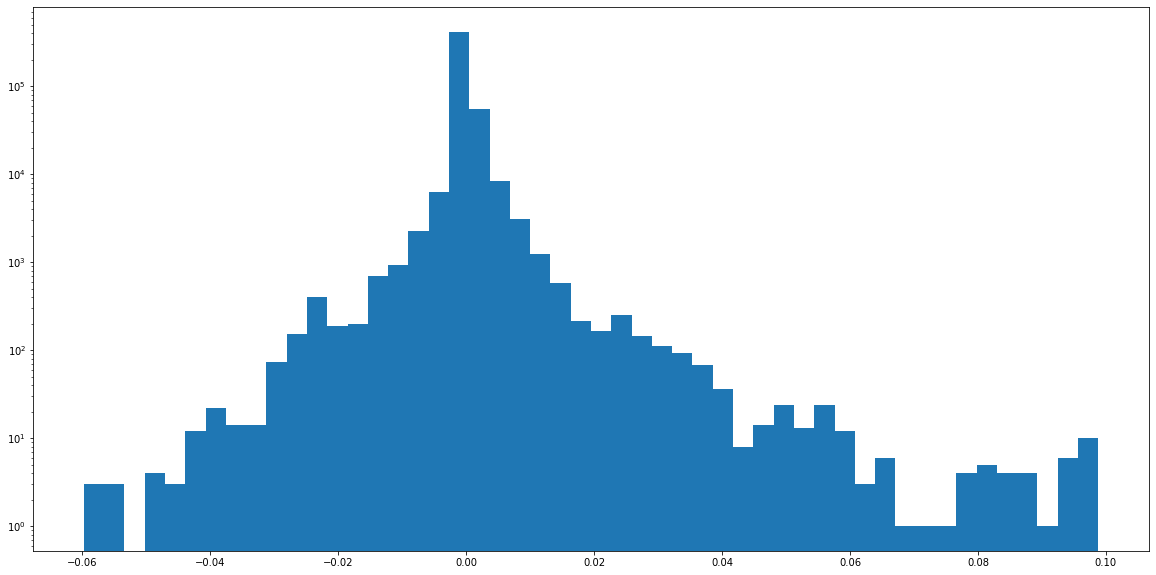

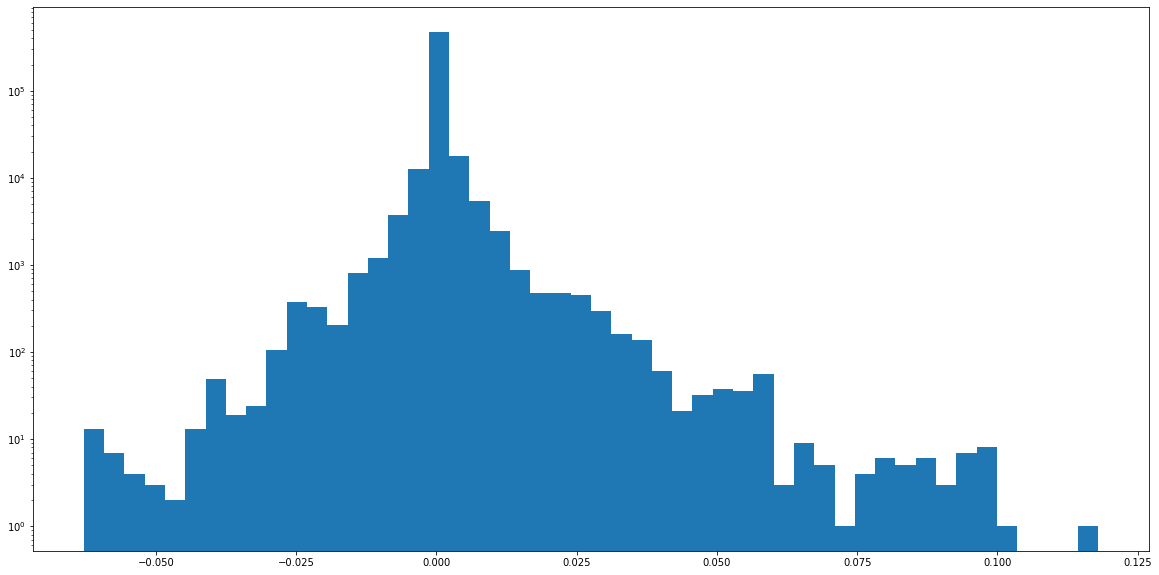

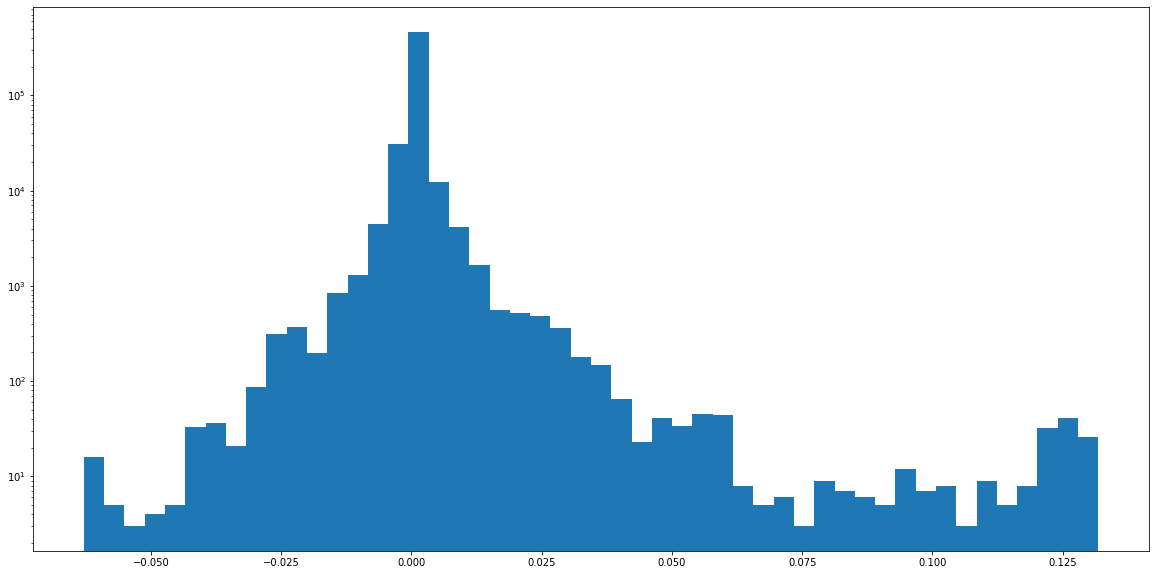

In [219]:
reload(epi_figs)
new_link = os.path.join(SARS_DIR, 'link-test.npy')
linked = np.load(os.path.join(SARS_DIR, old_date, 'linked-sites.npy'), allow_pickle=True)
linked = [[linked[i][j][:-2] for j in range(len(linked[i]))] for i in range(len(linked))]
np.save(new_link, linked)

null = epi_figs.find_null_distribution_ind_old(
    os.path.join(INF_DIR, 'infer-2021-01-31-tv.npz'), 
    new_link,
    os.path.join(SARS_DIR, 'old-data', '2021-01-31', 'individual-regions', 'inference'),
    neutral_tol=0.01,
    old=True
)
fig, axes = plt.subplots(1,1, figsize=[20,10])
axes.hist(null, log=True, bins=50)
print(f'max null distribution = {np.amax(null)}')

f = open(os.path.join(SARS_DIR, 'null-distribution-old-1pct.csv'), mode='w')
for i in range(len(null)):
    f.write('%.8f\n' % null[i])
f.close()

null = epi_figs.find_null_distribution_ind_old(
    os.path.join(INF_DIR, 'infer-2021-01-31-tv.npz'), 
    new_link,
    os.path.join(SARS_DIR, 'old-data', '2021-01-31', 'individual-regions', 'inference'),
    neutral_tol=0.05,
    old=True
)
fig, axes = plt.subplots(1,1, figsize=[20,10])
axes.hist(null, log=True, bins=50)
print(f'max null distribution = {np.amax(null)}')

f = open(os.path.join(SARS_DIR, 'null-distribution-old-5pct.csv'), mode='w')
for i in range(len(null)):
    f.write('%.8f\n' % null[i])
f.close()

null = epi_figs.find_null_distribution_ind_old(
    os.path.join(INF_DIR, 'infer-2021-01-31-tv.npz'), 
    new_link,
    os.path.join(SARS_DIR, 'old-data', '2021-01-31', 'individual-regions', 'inference'),
    neutral_tol=0.1,
    old=True
)
fig, axes = plt.subplots(1,1, figsize=[20,10])
axes.hist(null, log=True, bins=50)
print(f'max null distribution = {np.amax(null)}')

f = open(os.path.join(SARS_DIR, 'null-distribution-old-10pct.csv'), mode='w')
for i in range(len(null)):
    f.write('%.8f\n' % null[i])
f.close()

In [4]:
reload(dp)

cutoff     = np.amax(np.genfromtxt(os.path.join(DATA_DIR, 'null-distribution-old-10pct.csv')))
link_file  = os.path.join(DATA_DIR, 'linked-sites.npy')
inf_dir    = os.path.join(DATA_DIR, f'infer-tv2')
start_date = (dt.date(2021, 2, 1) - dt.date(2020, 1, 1)).days
for file in os.listdir(inf_dir):
    path = os.path.join(inf_dir, file)
    if '---' in file:
        os.remove(path)
    elif os.path.isdir(path):
        os.rmdir(path)
        
locs, sites, s = dp.calculate_selection(inf_dir, link_file, start_date=start_date, cutoff=cutoff)

In [289]:
variant_sites = ['S-614-1-G', 'S-681-1-A', 'S-681-1-G', 'S-796-0-T', 'S-211-1--', 'S-496-0-A', 'S-213-1-G', 'S-26-1--',
                 'N-31-1--','S-138-0-T', 'S-570-1-A', 'S-69-2--', 'NSP6-107-1--', 'S-157-2--', 'S-75-1-T', 'NSP6-106-0--',
                 'S-80-1-C', 'S-575-2-C', 'N-220-1-T', 'N-67-0-T', 'S-142-1-A', 'ORF3a-57-2-T', 'N-234-2-A',
                 'S-704-1-T', 'S-478-1-A', 'S-1234-0-A', 'S-144-1-C', 'S-346-1-A', 'S-253-1-C',
                 'N-401-0-T', 'M-81-0-T', 'NSP3-822-1-T', 'S-613-2-A', 'ORF8-11-1-T', 'S-1237-1-C', 'S-251-1-T',
                 'S-1116-2-C', 'N-18-0-A', 'ORF3a-109-1-G', 'S-570-0-T']   

# S-681-1-A: Alpha/Omicron, S-681-1-G: Delta, S-796-0-T: Omicron, S-211-1--: BA.1, S-496-0-A: BA.1, S-213-1-G: BA.2, S-26-1--: BA.2, N-31-1--: Omicron
# S-138-0-T: Gamma, S-570-1-A: Alpha, S-69-2--: Alpha/BA.1/Eta, NSP6-107-1--: Alpha/Beta/Gamma/Omicron, S-157-2--: Delta, S-75-1-T: Lambda
# NSP6-106-0-- Alpha/Beta/Gamma, S-80-1-C: Beta, S-575-2-C: B.1.1.318, N-220-1-T: EU1, N-67-0-T: B.1.2, NSP1-141-0--: AY.63, S-142-1-A: BA.2
# ORF3a-57-2-T: Beta/Iota, N-234-2-A: Iota, S-704-1-T: BA.2.12.1, S-253-1-C: AY.68 maybe, S-478-1-A: Delta & Omicron, S-1234-0-A: AY.23.1
# S-144-1-C: Mu, S-214n-2-G: Omicron, S-1259-0-T: AY.4.5, S-346-1-A: Mu, N-401-0-T: BA.1.438.1, M-81-0-T: AY.27, NSP3-822-1-T: AY.9, 
# S-613-2-A: D.2, ORF8-11-1-T: B.1.526, S-1237-1-C: L.1, S-251-1-T: AY.98.1, S-1116-2-C: B.1.258.22, N-18-0-A: B.1.618, S-570-0-T: AY.122 sublineage,
# ORF3a-109-1-G: B.1.279, NSP4-358-1-A: unnamed variant in croatia

data = np.load(os.path.join(DATA_DIR, 'synonymous-prot.npz'), allow_pickle=True)
#print([i for i in data])
#nucs  = data['nuc_index']
muts  = list(data['locations'])
aas   = data['aa_changes']
types = data['types']

for i in range(len(sites)):
    if np.any(np.isin(variant_sites, sites[i])):
        continue
    if isinstance(sites[i], list):
        test_site = sites[i][0]
    else:
        test_site = sites[i]
    test_split = test_site.split('-')
    if test_split[0]=='NC':
        if int(test_split[1])<150 or int(test_split[1])>29690:
            continue
    if not isinstance(sites[i], list):
        aa_changes = aas[muts.index(sites[i])]
    else:
        aa_changes = []
        for j in range(len(sites[i])):
            if sites[i][j] in muts:
                aa_changes.append(aas[muts.index(sites[i][j])])
    print(s[i], sites[i], locs[i], aa_changes)

0.1334278399528735 S-166-1-C europe-estonia C>S
0.14131358154755472 S-166-1-T europe-estonia C>F
0.15717854513152293 S-166-1-C europe-bulgaria C>S
0.15951068557632017 ['S-214n-2-G', 'S-214o-2-A', 'S-214p-2-G', 'S-214r-2-C', 'S-214t-2-G'] asia-india-tamil nadu []
0.17068969814375912 ['NSP13-220-0-G', 'NSP2-523-1-A', 'NSP3-587-1-G', 'ORF3a-260-0-G', 'ORF8-1-1-A'] asia-indonesia ['N>D', 'L>*', 'K>R', 'M>V', 'M>Q']
0.23312868867137226 ['ORF3a-265-2-C', 'N-216-2-C'] oceania-australia ['D>D', 'D>D']
0.359623273030459 ['NSP5-29-0-T', 'NC-151-T', 'NC-164-T', 'NC-245-T', 'NSP1-10-0-T', 'NSP1-14-0-T', 'NSP1-24-1-T', 'NSP1-25-0-T', 'NSP1-26-0-T', 'NSP1-28-0-T', 'NSP1-29-1-T', 'NSP1-35-0-T', 'NSP1-43-1-T', 'NSP1-60-0-T', 'NSP1-73-1-T', 'NSP1-77-1-T', 'NSP1-93-0-T', 'NSP1-98-0-T', 'NSP1-99-1-T', 'NSP1-113-0-T', 'NSP1-119-1-T', 'NSP1-124-1-T', 'NSP1-127-0-T', 'NSP1-137-0-T', 'NSP1-138-0-T', 'NSP1-139-0-T', 'NSP1-147-0-T', 'NSP1-148-0-T', 'NSP1-171-1-T', 'NSP1-175-1-T', 'NSP1-179-0-T', 'NSP2-4-1-T', 

In [272]:
"""
leftover = [
    #['S-217-2-C', 'S-1234-0-A'], # S-217 synonymous, S:L1234I
    #['S-166-1-C'], # S:C166S, NOT OBSERVED!!
    #['NSP2-153-1-T'], # NSP2:T153M (orf1a:T333M)
    #['NSP6-175-2-T', 'NSP4-324-2-T', 'NSP12-185-0-T', 'NSP12-776-0-T', 'NSP13-218-1-G', 'NSP13-261-2-T', 'M-118-2-C', 'N-234-2-C', 'N-376-0-A', 'NSP3-970-2-T'], # M-118 synonmyous, N:A376T
    #['NSP6-149-1-C', 'NSP3-822-1-T', 'NSP4-446-1-T', 'NSP6-181-1-T', 'NSP3-955-2-G', 'NSP9-112-0-T'], # NSP9-112 synonymous, NSP6:V149A (orf1a:V3718A), NSP3:P822L/ORF1a:P1640L
    #['S-251-1-T', 'NSP2-571-2-T', 'NSP3-906-2-T', 'NSP3-1683-2-T'], # S:P251L
    #['NSP2-120-0-T', 'NSP3-1607-2-C', 'NSP13-137-2-T', 'S-613-2-A'], # S-613 synonymous, NSP2:I120F (orf1a:I300F)
    #['S-142-1-A'], # S:G142D
    #['ORF3a-42-1-T', 'NSP4-438-1-C', 'ORF8-11-1-T', 'N-234-2-A'], # ORF3a:P42L
    #['NSP2-85-1-T', 'ORF3a-57-2-T'], # ORF3a:Q57H
    #['NSP9-101-2-T', 'NSP12-720-0-A', 'NSP13-598-0-T', 'S-1116-2-C', 'M-150-2-C', 'ORF7b-15-1-A'] # M-150, S-1116 synonymous, ORF7b-15 (synonymous probably), NSP12:V720I (orf1b-711), NSP13:A598S (ORF1b-1521)
]

ay231_a = ['S-217-2-C', 'S-1234-0-A'] # AY.23.1
b1160   = ['NSP6-175-2-T', 'NSP4-324-2-T', 'NSP12-185-0-T', 'NSP12-776-0-T', 'NSP13-218-1-G', 'NSP13-261-2-T', 'M-118-2-C', 'N-234-2-C', 'N-376-0-A', 'NSP3-970-2-T'] # B.1.160
ay981   = ['S-251-1-T', 'NSP2-571-2-T', 'NSP3-906-2-T', 'NSP3-1683-2-T'] # AY.98.1
b125822 = ['NSP9-101-2-T', 'NSP12-720-0-A', 'NSP13-598-0-T', 'S-1116-2-C', 'M-150-2-C', 'ORF7b-15-1-A'] # B.1.258.22
ay231_b = ['NSP2-153-1-T'] # AY.23.1
d2      = ['NSP2-120-0-T', 'NSP3-1607-2-C', 'NSP13-137-2-T', 'S-613-2-A'] # D.2
ay9     = ['NSP6-149-1-C', 'NSP3-822-1-T', 'NSP4-446-1-T', 'NSP6-181-1-T', 'NSP3-955-2-G', 'NSP9-112-0-T'] # AY.9 (THIS ONLY ACCOUNTS FOR ABOUT HALF OF ITS FREQUENCY IN THE UK)
ay68    = ['NSP12-308-0-T', 'NSP3-192-1-T', 'S-253-1-C', 'S-979-2-A', 'ORF3a-130-2-T', 'M-123-2-G', 'ORF7b-41-2-C'] # maybe AY.68?
ay27    = ['NSP7-32-2-C', 'NSP2-532-2-A', 'NSP12-345-2-G', 'NSP13-34-2-T', 'M-81-0-T', 'N-412-0-C']    # AY.27


b16401  = ['NSP2-272-1-G', 'NSP1-112-2-T', 'NSP3-1301-2-T', 'NSP4-386-1-T', 'NSP4-401-1-A', 'NSP13-211-2-T', 'S-96-0-C', 
           'S-210-1-C', 'S-346-2-C', 'S-394-1-G', 'S-449-0-A', 'S-490-0-C', 'S-490-1-G', 'S-936-0-C', 'ORF3a-32-1-T', 
           'N-22-0-T', 'N-368-2-C', 'NC-29737-G', 'NC-29752-C', 'NC-29757-G']    # S:F490R, B.1.640.1
AY122    = ['S-570-0-T', 'NSP3-509-2-T', 'NSP3-1463-2-T', 'N-152-0-T', 'N-244-2-T'] # S:A570S (may be wrong, alpha sublineage?), N:A152S, N:Q244H, SUBLINEAGE OF AY.122
b1429    = ['NSP9-65-0-G', 'NSP2-530-2-T', 'NSP2-598-0-C', 'NSP4-131-2-T', 'S-929-2-C', 'NC-27889-T'] # B.1.429
unknown1 = ['S-554-0-C', 'NSP3-1-0-A'] # S:E554Q
mu       = ['S-346-1-A', 'NSP2-555-2-T'] # S:R346k
AY125    = ['NSP12-168-2-T', 'NSP14-289-1-A', 'M-88-2-G', 'NSP12-822-2-T', 'NSP1-160-2-T', 'NSP3-1337-2-T', 'ORF3a-27-0-T'] # ORF3a:D27Y, AY.125
AY45     = ['NSP12-481-1-C', 'S-1259-0-T'] # S:D1259Y, AY.4.5
B1526    = ['ORF3a-42-1-T', 'NSP4-438-1-C', 'ORF8-11-1-T']  # B.1.526
L1       = ['NSP8-43-0-C', 'NSP3-1403-0-T', 'S-1237-1-C']    # L.1
B1618    = ['NSP13-277-1-G', 'NSP3-371-0-G', 'NSP3-697-1-T', 'NSP3-848-2-C', 'S-1174-2-C', 'M-129-2-T', 'ORF7b-33-0-T', 'N-18-0-A', 'N-367-0-C'] # B.1.618
unknown2 = ['NSP10-137-1-A', 'NSP3-1868-1-C', 'NSP4-358-1-A', 'NSP10-138-1-G', 'NSP14-128-2-G']  # orf1a:S3121Y, orf1a:R2686Y
b1279    = ['NSP2-370-0-T', 'NSP2-575-0-A', 'ORF3a-109-1-G'] # B.1.279

# Check frequencies of the below
unknown3 = ['S-943-0-C', 'S-943-1-C'] # S:S943P
unknown4 = ['ORF3a-265-2-C', 'N-216-2-C'] # both synonymous
unknown5 = ['S-212-0-G', 'S-212-2-G', 'S-213-0-C', 'S-213-2-A', 'S-214-0-G', 'S-214-2-A']   # S:L212V, S:V213L, S:R214G
unknown6 = ['NSP13-220-0-G', 'NSP2-523-1-A', 'NSP3-587-1-G', 'ORF3a-260-0-G', 'ORF8-1-1-A']    # the third mutation is a stop codon and the last two don't seem to appear in data
unknown7 = ['NSP6-278-0-A', 'NSP4-399-0-G', 'S-80-1-G', 'S-157-1-C', 'S-950-0-C', 'ORF8-51-0-T']    # seems like these mutations are incorrect or dont appear
unnamed1 = ['NSP10-137-1-A', 'NSP3-1868-1-C', 'NSP4-358-1-A', 'NSP10-138-1-G', 'NSP14-128-2-G'] # ORF1a:M4390K, ORF1a:R2686P, ORF1a:S3121Y, ORF1a:L4391R, ORF1b:P1652P

b14381   = ['NSP2-117-0-G', 'NSP3-1811-2-T', 'NSP8-10-2-G', 'ORF3a-95-2-T', 'NC-28271-G', 'N-401-0-T']    # N:D401Y, B.1.438.1
"""

In [ ]:
# TO CHECK
check = [
    ['S-214n-2-G', 'S-214o-2-A', 'S-214p-2-G', 'S-214r-2-C', 'S-214t-2-G']    # remove from idaho
]

concern = [
    ['NSP13-220-0-G', 'NSP2-523-1-A', 'NSP3-587-1-G', 'ORF3a-260-0-G', 'ORF8-1-1-A'],    # the third mutation is a stop codon and the last two don't seem to appear in data
    ['S-166-1-C'],       # doesn't appear in data according to outbreak.info 
    ['NSP6-200-2-T'],    # synonymous
    ['S-212-0-G', 'S-212-2-G', 'S-213-0-C', 'S-213-2-A', 'S-214-0-G', 'S-214-2-A'],   # I believe this is BA.1.1, there is a deletion in this variant and 212, as well as a mutation at 211. 
    # due to the insertion in Omicron, I think this is an alignment error. Indeed, 212-214 encode the insertion EPE
    ['NSP13-220-0-G', 'NSP2-523-1-A', 'NSP3-587-1-G', 'ORF3a-260-0-G', 'ORF8-1-1-A'],    # the third mutation is a stop codon and the last two don't seem to appear in data
]

In [6]:
counts = {
    'S-478-1-A'     : ['Delta Omicron',   0],    # this is in Delta and Omicron
    'S-681-1-A'     : ['Alpha Omicron',   0],
    'S-704-1-T'     : ['BA.2.12.1',       0],
    'S-614-1-G'     : ['B.1',             0],
    'S-681-1-G'     : ['Delta',           0],
    'S-796-0-T'     : ['Omicron',         0],
    'S-211-1--'     : ['BA.1',            0],
    'S-496-0-A'     : ['BA.1',            0],
    'NSP6-106-0--'  : ['Alpha Beta Gamma BA.1 BA.2 BA.2.12.1 BA.4 BA.5 Eta Iota Lambda', 0],
    'NSP6-107-1--'  : ['Alpha Beta Gamma BA.2 BA.2.12.1 BA.4 BA.5 Eta Iota Lambda', 0],
    'S-69-2--'      : ['Alpha Eta BA.1, BA.4 BA.5', 0],
    'S-213-1-G'     : ['BA.2 BA.4 BA.5 BA.2.12.1', 0],
    'S-26-1--'      : ['BA.2 BA.4 BA.5 BA.2.12.1', 0],
    'S-142-1-A'     : ['BA.2 BA.4 BA.5 BA.2.12.1', 0],
    'N-31-1--'      : ['Omicron',         0],
    'S-138-0-T'     : ['Gamma',           0],
    'S-76-1-T'      : ['Lambda',          0],
    'S-570-1-A'     : ['Alpha',           0],
    'S-157-2--'     : ['Delta',           0],
    #'S-75-1-T'      : ['Lambda',          0],
    'S-144-1-C'     : ['Mu',              0],
    #'S-346-1-A'     : ['Mu',              0],
    'S-80-1-C'      : ['Beta',            0],
    'S-575-2-C'     : ['B.1.1.318',       0],
    'N-220-1-T'     : ['EU1',             0],
    'N-67-0-T'      : ['B.1.2',           0],
    #'ORF3a-57-2-T'  : ['Beta & Iota',     0],
    #'N-234-2-A'     : ['Iota',            0],
    #'S-217-2-C'     : ['AY.23.1',         0],
    #'N-376-0-A'     : ['B.1.160',         0],
    #'ORF8-11-1-T'   : ['B.1.526',         0],
    #'S-251-1-T'     : ['AY.98.1',         0],
    'NSP3-822-1-T'  : ['AY.9',            0],
    #'S-929-2-C'     : ['B.1.429',         0],
    'N-401-0-T'     : ['B.1.438.1',       0],
    'S-1259-0-T'    : ['AY.4.5',          0],
    'M-81-0-T'      : ['AY.27',           0],
    #'NSP1-141-0--'  : ['AY.63',           0],    # this is also BA.4
    #'S-613-2-A'     : ['D.2',             0],
    'S-1237-1-C'    : ['L.1',             0],
    #'S-251-1-T'     : ['AY.98.1',         0],
    'S-1116-2-C'    : ['B.1.258.22',      0],
    #'N-18-0-A'      : ['B.1.618',         0],
    'S-253-1-C'     : ['AY.68',           0],
    #'S-570-0-T'     : ['AY.122',          0],    # sublineage of AY.122
    'ORF3a-109-1-G' : ['B.1.279',         0],
    'NSP12-694-1-A' : ['AY.4',            0],
    #'S-80-1-G'      : ['B.1.637',         0],
    #'NSP12-198-0-G' : ['Alpha sublineage',0],    # sublineage of Alpha (not named)
    'NSP4-358-1-A'  : ['AY.4.5',          0],    # sublineage of AY.4.5
    #'S-181-1-T'     : ['AY.122.6',        0],    # AY.122.6 doesn't appear in Bulgaria though
    'NC-28270--'    : ['Delta',           0],    # NC:A28270T is an Omicron mutation
    #'NSP3-1511-2-T' : ['AY.43 AY.122',    0],    # Sublineage of either AY.43 or AY.122
    #'NSP6-108-2-G'  : ['BA.2.10',         0],    # Sublineage of BA.2.10
    #'NSP2-153-1-T'  : ['AY.23.1',         0],
    #'S-943-0-C'     : ['AY.112',          0],    # Sublineage of AY.112 (doesn't account for all of the sequences)
    'S-166-1-C'     : ['unknown',         0],    # IS THIS A SEQUENCING ISSUE OR SOMETHING?
    #'NSP6-200-2-T'  : ['synonymous',      0],     # Synonymous
    'N-216-2-C'     : ['synonymous',      0]
    #'S-214n-2-G'    : ['Omicron group 3', 0],   Potentially a sequencing/alignment error?
}

# SNVs to ignore because they are an alternate nucleotide in a site that belongs to one of the main variants'S-142-1-C'
ignore = ['NC-28270-G', 'NC-28270-A', 'NC-28270-C', 
          'S-142-1-C', 'S-142-1-G', 'S-142-1-T', 
          'S-166-1-G', 'S-166-1-A', 'S-166-1-T', 'S-166-1-C', 'S-166-1--',
          'ORF8-120-2-A', 'ORF8-120-2-T',
          'NSP6-77-0--', 'NSP6-77-0-C', 'NSP6-77-0-T',
          'S-214n-2-G',    # omicron insertion probably aligned or sequenced incorrectly (in Idaho), but only inferred large in India subregions
         ]

keys = [i for i in counts]
mut_groups = [[] for i in range(len(keys))]

for group in sites:
    if isinstance(group, list):
        test_site = group[0]
    else:
        test_site = group
    test_split = test_site.split('-')
    if test_split[0]=='NC':
        if int(test_split[1])<150 or int(test_split[1])>29690:
            continue
    listed = False
    for key in keys:
        if key in group:
            counts[key][-1] += 1
            mut_groups[keys.index(key)] = group
            listed = True
            break
    if not listed:
        if isinstance(group, list):
            if not any(np.isin(group, ignore)):
                print(group)
        else:
            if not group in ignore:
                print(group)
        
values     = [counts[i] for i in keys]
labels     = [i[0] for i in values]
detections = [i[1] for i in values]
mutations  = []

syn_file = np.load(os.path.join(DATA_DIR, 'synonymous-prot.npz'), allow_pickle=True)
syn_locs = syn_file['locations']
aas      = syn_file['aa_changes']
initial_aa = [i[0] for i in aas]
final_aa   = [i[-1] for i in aas]
new_muts   = []
for group in mut_groups:
    if isinstance(group, list):
        new_group = []
        for mut in group: 
            if mut not in syn_locs:
                print(f'{mut} not in synonymous sites file')
                continue
            idx = list(syn_locs).index(mut)
            new_label = mut.split('-')
            if new_label[0] == 'NC':
                new_label = f'NC:{new_label[1]}'
            else:
                new_label = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
            if new_label not in new_group:
                new_group.append(new_label)
    else:
        idx = list(syn_locs).index(group)
        new_label = group.split('-')
        if new_label[0] == 'NC':
            new_group = f'NC:{new_label[1]}'
        else:
            new_group = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
        #new_group = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
    new_muts.append(new_group)

for group in new_muts:
    if isinstance(group, list):
        mutations.append(' '.join(group))
    else:
        mutations.append(group)
        
# Find the ultimate selection coefficient inferred for each group
inf_data  = np.load(os.path.join(DATA_DIR, f'sensitivity-data', f'infer-{DATA_DATE}-observed-g-10.npz'), allow_pickle=True)
alleles   = [dp.get_label_new(i) for i in inf_data['allele_number']]
selection = inf_data['selection']

s_groups = np.zeros(len(mut_groups))
for i in range(len(mut_groups)):
    if not isinstance(mut_groups[i], list):
        s_groups[i] = selection[alleles.index(mut_groups[i])]
        continue
    for j in range(len(mut_groups[i])):
        if mut_groups[i][j] not in alleles:
            print(mut_groups[i][j])
            continue
        s_groups[i] += selection[alleles.index(mut_groups[i][j])]        

detect_dic = {'Variants' : labels, 'Number of detections' : detections, 'Mutations' : mutations, 'Selection' : s_groups}
df         = pd.DataFrame.from_dict(detect_dic)
df         = df.sort_values(by=['Number of detections'], ascending=False)
#df['Rank'] = np.arange(1, len(df)+1)
df.to_csv(os.path.join(DATA_DIR, 'early-detection-sel.csv'), index=False)
display(df)
del df['Selection']
df.to_csv(os.path.join(DATA_DIR, 'early-detection.csv'), index=False)

['NSP5-29-0-T', 'NC-151-T', 'NC-164-T', 'NC-245-T', 'NSP1-10-0-T', 'NSP1-14-0-T', 'NSP1-24-1-T', 'NSP1-25-0-T', 'NSP1-26-0-T', 'NSP1-28-0-T', 'NSP1-29-1-T', 'NSP1-35-0-T', 'NSP1-43-1-T', 'NSP1-60-0-T', 'NSP1-73-1-T', 'NSP1-77-1-T', 'NSP1-93-0-T', 'NSP1-98-0-T', 'NSP1-99-1-T', 'NSP1-113-0-T', 'NSP1-119-1-T', 'NSP1-124-1-T', 'NSP1-127-0-T', 'NSP1-137-0-T', 'NSP1-138-0-T', 'NSP1-139-0-T', 'NSP1-147-0-T', 'NSP1-148-0-T', 'NSP1-171-1-T', 'NSP1-175-1-T', 'NSP1-179-0-T', 'NSP2-4-1-T', 'NSP2-7-0-T', 'NSP2-27-1-T', 'NSP2-37-0-T', 'NSP2-52-1-T', 'NSP2-62-2-T', 'NSP2-64-1-T', 'NSP2-121-1-T', 'NSP2-127-2-T', 'NSP2-153-2-T', 'NSP2-155-0-T', 'NSP2-162-0-T', 'NSP2-206-0-T', 'NSP2-218-1-T', 'NSP2-222-1-T', 'NSP2-246-1-T', 'NSP2-249-0-T', 'NSP2-264-0-T', 'NSP2-365-1-T', 'NSP2-370-1-T', 'NSP2-380-1-T', 'NSP2-386-0-T', 'NSP2-430-2-T', 'NSP2-465-0-T', 'NSP2-481-0-T', 'NSP2-531-2-T', 'NSP2-607-0-T', 'NSP2-612-0-T', 'NSP2-638-0-T', 'NSP3-47-0-T', 'NSP3-54-0-T', 'NSP3-175-0-T', 'NSP3-289-0-T', 'NSP3-301-0-T'

,Variants,Number of detections,Mutations,Selection
5,Omicron,100,NSP5:P132H NSP14:I42V S:G339D S:S371F S:S373P ...,1.365548
4,Delta,92,NSP6:T77A NC:209 NSP3:A488S NSP3:P1228L NSP3:P...,0.455085
7,BA.1,91,NSP6:I189V NSP3:K38R NSP3:A889A NSP3:A1892T NS...,-0.263008
6,BA.1,88,NSP6:S104- NSP3:S1265- NSP3:L1266- NSP6:L105- ...,0.085201
11,BA.2 BA.4 BA.5 BA.2.12.1,83,NSP5:D48D NSP1:S135R NSP3:T24I NSP3:G489S NSP3...,0.311589
14,Omicron,83,N:G30- N:E31- N:R32- N:S33-,0.163238
18,Delta,81,S:E156- S:F157- S:R158G ORF8:D119- ORF8:F120-,0.093914
12,BA.2 BA.4 BA.5 BA.2.12.1,57,S:L24- S:P25- S:P26- S:A27S,0.019667
15,Gamma,36,NSP9:Y31Y NSP1:D156D NSP3:D10D NSP3:S370L NSP3...,0.031859
17,Alpha,35,NSP12:P412P NSP2:S36S NSP3:T183I NSP3:A890D NS...,0.006829


In [304]:
major_var = np.sum([100, 92, 91, 88, 83, 81, 57, 44, 36, 30, 24, 9, 8, 7, 6, 2, 2, 1, 1])
minor     = np.sum([4, 2, 1])    # B.1, EU1, B.1.1.318
unknown   = np.sum([2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1])
total     = major_var + minor + unknown
print(f'Total detections of major variants is {major_var}')
print('')
print(f'major variant are {major_var / total} percentage of early detections')
print(f'likely true predictions are {(major_var + minor) / total} percentage of early detections')

Total detections of major variants is 762

major variant are 0.9707006369426752 percentage of early detections
likely true predictions are 0.9796178343949045 percentage of early detections


In [13]:
# with various different cutoffs for the final inferred coefficient

start_date = (dt.date(2021, 2, 1) - dt.date(2020, 1, 1)).days
inf_dir    = os.path.join(DATA_DIR, f'infer-tv2')
link_file  = os.path.join(DATA_DIR, 'linked-sites.npy')
#cutoff     = np.amax(np.genfromtxt(os.path.join(SARS_DIR, 'null-distribution-old-5pct.csv')))
cutoff = 0.0988
locs, sites, s = dp.calculate_selection(
    inf_dir,
    link_file,
    cutoff=cutoff,
    start_date=start_date
)

counts = {
    'S-478-1-A'     : ['Delta Omicron',             0, 0, 0],    # this is in Delta and Omicron
    'S-681-1-A'     : ['Alpha Omicron',             0, 0, 0],
    'S-704-1-T'     : ['BA.2.12.1',                 0, 0, 0],
    #'S-614-1-G'     : ['B.1',                       0, 0, 0],
    'S-681-1-G'     : ['Delta',                     0, 0, 0],
    'S-796-0-T'     : ['Omicron',                   0, 0, 0],
    'S-211-1--'     : ['BA.1',                      0, 0, 0],
    'S-496-0-A'     : ['BA.1',                      0, 0, 0],
    'S-213-1-G'     : ['BA.2 BA.4 BA.5 BA.2.12.1',  0, 0, 0],
    'S-26-1--'      : ['BA.2 BA.4 BA.5 BA.2.12.1',  0, 0, 0],
    'N-31-1--'      : ['Omicron',                   0, 0, 0],
    'S-138-0-T'     : ['Gamma',                     0, 0, 0],
    'S-76-1-T'      : ['Lambda',                    0, 0, 0],
    'S-570-1-A'     : ['Alpha',                     0, 0, 0],
    'S-69-2--'      : ['Alpha Eta BA.1, BA.4 BA.5', 0, 0, 0],
    'NSP6-107-1--'  : ['Alpha Beta Gamma BA.2 BA.2.12.1 BA.4 BA.5 Eta Iota Lambda', 0, 0, 0],
    'S-157-2--'     : ['Delta',                     0, 0, 0],
    'S-144-1-C'     : ['Mu',                        0, 0, 0],
    'S-346-1-A'     : ['Mu',                        0, 0, 0],
    'NSP6-106-0--'  : ['Alpha Beta Gamma BA.1 BA.2 BA.2.12.1 BA.4 BA.5 Eta Iota Lambda', 0, 0, 0],
    'S-80-1-C'      : ['Beta',                      0, 0, 0],
    'S-575-2-C'     : ['B.1.1.318',                 0, 0, 0],
    #'N-220-1-T'     : ['EU1',                       0, 0, 0],
    #'N-67-0-T'      : ['B.1.2',                     0, 0, 0],
    'S-142-1-A'     : ['BA.2',                      0, 0, 0],
    'S-217-2-C'     : ['AY.23.1',                   0, 0, 0],
    'NSP3-822-1-T'  : ['AY.9',                      0, 0, 0],
    #'N-401-0-T'     : ['B.1.438.1',                 0, 0, 0],
    'S-1259-0-T'    : ['AY.4.5',                    0, 0, 0],
    'M-81-0-T'      : ['AY.27',                     0, 0, 0],
    'NSP1-141-0--'  : ['AY.63',                     0, 0, 0],    # this is also BA.4
    #'S-1237-1-C'    : ['L.1',                       0, 0, 0],
    'S-251-1-T'     : ['AY.98.1',                   0, 0, 0],
    'S-1116-2-C'    : ['B.1.258.22',                0, 0, 0],
    'S-253-1-C'     : ['AY.68',                     0, 0, 0],
    #'ORF3a-109-1-G' : ['B.1.279',                   0, 0, 0],
    'NSP12-694-1-A' : ['AY.4',                      0, 0, 0],
    'NSP4-358-1-A'  : ['AY.4.5',                    0, 0, 0],    # sublineage of AY.4.5
    'NC-28270--'    : ['Delta',                     0, 0, 0],    # NC:A28270T is an Omicron mutation
    'S-166-1-C'     : ['unknown',                   0, 0, 0],
    'N-216-2-C'     : ['synonymous',                0, 0, 0],
    'N-18-0-A'      : ['B.1.618',                   0, 0, 0],
    #'NSP15-132-0-T' : ['B.1.279',                   0, 0, 0],
    'S-292-0-T'     : ['Alpha sublineage',          0, 0, 0]
    #'NSP6-200-2-T'  : ['synonymous',      0, 0, 0],     # Synonymous
    #'S-75-1-T'      : ['Lambda',          0, 0, 0],
    #'NSP3-1511-2-T' : ['AY.43 AY.122',    0, 0, 0],    # Sublineage of either AY.43 or AY.122
    #'NSP6-108-2-G'  : ['BA.2.10',         0, 0, 0],    # Sublineage of BA.2.10
    #'NSP2-153-1-T'  : ['AY.23.1',         0, 0, 0],
    #'S-80-1-G'      : ['B.1.637',         0, 0, 0],
    #'S-613-2-A'     : ['D.2',             0, 0, 0],
    #'S-929-2-C'     : ['B.1.429',         0, 0, 0],
    #'N-376-0-A'     : ['B.1.160',         0, 0, 0],
    #'ORF8-11-1-T'   : ['B.1.526',         0, 0, 0],
    #'S-251-1-T'     : ['AY.98.1',         0, 0, 0],
    #'ORF3a-57-2-T'  : ['Beta & Iota',     0, 0, 0],
    #'N-234-2-A'     : ['Iota',            0, 0, 0],
    #'S-570-0-T'     : ['AY.122',          0, 0, 0],    # sublineage of AY.122
    #'NSP12-198-0-G' : ['Alpha sublineage',0, 0, 0],    # sublineage of Alpha (not named)
    #'S-181-1-T'     : ['AY.122.6',        0, 0, 0],    # AY.122.6 doesn't appear in Bulgaria though
    #'S-943-0-C'     : ['AY.112',          0, 0, 0],    # Sublineage of AY.112 (doesn't account for all of the sequences)
    #'S-214n-2-G'    : ['Omicron group 3', 0, 0, 0]     # Potentially a sequencing/alignment error?
}

keys = [i for i in counts]
mut_groups = [[] for i in range(len(keys))]

for group in sites:
    if isinstance(group, list):
        test_site = group[0]
    else:
        test_site = group
    test_split = test_site.split('-')
    if test_split[0]=='NC':
        if int(test_split[1])<150 or int(test_split[1])>29690:
            continue
    listed = False
    for key in keys:
        if key in group:
            counts[key][1] += 1
            mut_groups[keys.index(key)] = group
            listed = True
            break
    if not listed:
        print(group)
        print(locs[list(sites).index(group)])

cutoff = np.amax(np.genfromtxt(os.path.join(DATA_DIR, 'null-distribution-old-10pct.csv')))
locs, sites, s = dp.calculate_selection(
    inf_dir,
    link_file,
    cutoff=cutoff,
    start_date=start_date
)

for group in sites:
    if isinstance(group, list):
        test_site = group[0]
    else:
        test_site = group
    test_split = test_site.split('-')
    if test_split[0]=='NC':
        if int(test_split[1])<150 or int(test_split[1])>29690:
            continue
    listed = False
    for key in keys:
        if key in group:
            counts[key][2] += 1
            mut_groups[keys.index(key)] = group
            listed = True
            break
    #if not listed:
    #    print(group)
    #    print(locs[list(sites).index(group)])
        
#cutoff = np.amax(np.genfromtxt(os.path.join(SARS_DIR, 'null-distribution-old-12pct.csv')))
cutoff = 0.1180
locs, sites, s = dp.calculate_selection(
    inf_dir,
    link_file,
    cutoff=cutoff,
    start_date=start_date
)

for group in sites:
    if isinstance(group, list):
        test_site = group[0]
    else:
        test_site = group
    test_split = test_site.split('-')
    if test_split[0]=='NC':
        if int(test_split[1])<150 or int(test_split[1])>29690:
            continue
    listed = False
    for key in keys:
        if key in group:
            counts[key][3] += 1
            mut_groups[keys.index(key)] = group
            listed = True
            break
    #if not listed:
    #    print(group)
    #    print(locs[list(sites).index(group)])
        
values     = [counts[i] for i in keys]
labels     = [i[0] for i in values]
detections5  = [i[1] for i in values]
detections10 = [i[2] for i in values]
detections12 = [i[3] for i in values]
mutations    = []

syn_file = np.load(os.path.join(DATA_DIR, 'synonymous-prot.npz'), allow_pickle=True)
syn_locs = syn_file['locations']
aas      = syn_file['aa_changes']
initial_aa = [i[0] for i in aas]
final_aa   = [i[-1] for i in aas]
new_muts   = []
for group in mut_groups:
    if isinstance(group, list):
        new_group = []
        for mut in group:
            if mut not in syn_locs:
                continue
            idx = list(syn_locs).index(mut)
            new_label = mut.split('-')
            if new_label[0] == 'NC':
                new_label = f'NC:{new_label[1]}'
            else:
                new_label = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
            if new_label not in new_group:
                new_group.append(new_label)
    else:
        idx = list(syn_locs).index(group)
        new_label = group.split('-')
        if new_label[0] == 'NC':
            new_group = f'NC:{new_label[1]}'
        else:
            new_group = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
        #new_group = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
    new_muts.append(new_group)

for group in new_muts:
    if isinstance(group, list):
        mutations.append(' '.join(group))
    else:
        mutations.append(group)
        
# Find the ultimate selection coefficient inferred for each group
inf_data  = np.load(os.path.join(DATA_DIR, f'sensitivity-data', f'infer-{DATA_DATE}-observed-g-10.npz'), allow_pickle=True)
alleles   = [dp.get_label_new(i) for i in inf_data['allele_number']]
selection = inf_data['selection']

s_groups = np.zeros(len(mut_groups))
for i in range(len(mut_groups)):
    if not isinstance(mut_groups[i], list):
        s_groups[i] = selection[alleles.index(mut_groups[i])]
        continue
    for j in range(len(mut_groups[i])):
        if mut_groups[i][j] not in alleles:
            print(mut_groups[i][j])
            continue
        s_groups[i] += selection[alleles.index(mut_groups[i][j])]

# Make dataframe
detect_dic = {'Variant' : labels, 
              'Regions Detected, 5% threshold' : detections5, 
              'Regions Detected, 10% threshold' : detections10, 
              'Regions Detected, 12% threshold' : detections12, 
              #'Final inferred coefficient (%)' : s_groups,
              'Mutations' : mutations}
df         = pd.DataFrame.from_dict(detect_dic)
df_temp    = df.sort_values(by=['Regions Detected, 10% threshold'], ascending=False)
#df['Rank'] = np.arange(1, len(df)+1)
df_temp.to_csv(os.path.join(DATA_DIR, 'early-detection-full.csv'), index=False)
df['Final inferred coefficient (%)'] = s_groups
df = df.sort_values(by=['Regions Detected, 10% threshold'], ascending=False)
df.to_csv(os.path.join(DATA_DIR, 'early-detection-full-sel.csv'), index=False)
display(df)

['S-943-0-C', 'S-943-1-C']
asia-india-andhra pradesh
ORF8-120-2-A
asia-india-andhra pradesh
['NSP5-29-0-T', 'NC-151-T', 'NC-164-T', 'NC-245-T', 'NSP1-10-0-T', 'NSP1-14-0-T', 'NSP1-24-1-T', 'NSP1-25-0-T', 'NSP1-26-0-T', 'NSP1-28-0-T', 'NSP1-29-1-T', 'NSP1-35-0-T', 'NSP1-43-1-T', 'NSP1-60-0-T', 'NSP1-73-1-T', 'NSP1-77-1-T', 'NSP1-93-0-T', 'NSP1-98-0-T', 'NSP1-99-1-T', 'NSP1-113-0-T', 'NSP1-119-1-T', 'NSP1-124-1-T', 'NSP1-127-0-T', 'NSP1-137-0-T', 'NSP1-138-0-T', 'NSP1-139-0-T', 'NSP1-147-0-T', 'NSP1-148-0-T', 'NSP1-171-1-T', 'NSP1-175-1-T', 'NSP1-179-0-T', 'NSP2-4-1-T', 'NSP2-7-0-T', 'NSP2-27-1-T', 'NSP2-37-0-T', 'NSP2-52-1-T', 'NSP2-62-2-T', 'NSP2-64-1-T', 'NSP2-121-1-T', 'NSP2-127-2-T', 'NSP2-153-2-T', 'NSP2-155-0-T', 'NSP2-162-0-T', 'NSP2-206-0-T', 'NSP2-218-1-T', 'NSP2-222-1-T', 'NSP2-246-1-T', 'NSP2-249-0-T', 'NSP2-264-0-T', 'NSP2-365-1-T', 'NSP2-370-1-T', 'NSP2-380-1-T', 'NSP2-386-0-T', 'NSP2-430-2-T', 'NSP2-465-0-T', 'NSP2-481-0-T', 'NSP2-531-2-T', 'NSP2-607-0-T', 'NSP2-612-0-T', 

,Variant,"Regions Detected, 5% threshold","Regions Detected, 10% threshold","Regions Detected, 12% threshold",Mutations,Final inferred coefficient (%)
4,Omicron,101,100,100,NSP5:P132H NSP14:I42V S:G339D S:S371F S:S373P ...,1.365548
3,Delta,99,92,97,NSP6:T77A NC:209 NSP3:A488S NSP3:P1228L NSP3:P...,0.455085
6,BA.1,92,91,91,NSP6:I189V NSP3:K38R NSP3:A889A NSP3:A1892T NS...,-0.263008
5,BA.1,92,88,89,NSP6:S104- NSP3:S1265- NSP3:L1266- NSP6:L105- ...,0.085201
7,BA.2 BA.4 BA.5 BA.2.12.1,85,83,83,NSP5:D48D NSP1:S135R NSP3:T24I NSP3:G489S NSP3...,0.311589
9,Omicron,90,83,85,N:G30- N:E31- N:R32- N:S33-,0.163238
15,Delta,88,81,83,S:E156- S:F157- S:R158G ORF8:D119- ORF8:F120-,0.093914
8,BA.2 BA.4 BA.5 BA.2.12.1,70,57,64,S:L24- S:P25- S:P26- S:A27S,0.019667
10,Gamma,46,36,42,NSP9:Y31Y NSP1:D156D NSP3:D10D NSP3:S370L NSP3...,0.031859
12,Alpha,50,35,44,NSP12:P412P NSP2:S36S NSP3:T183I NSP3:A890D NS...,0.006829


In [16]:
major = 100 + 92 + 91 + 88 + 83 + 83 + 81 + 57 + 36 + 35 + 30 + 23 + 9 + 8 + 7 + 6 + 2 + 1 + 1 + 1
unknown = 2 + 2 + 2 + 2 + 1 + 1 + 1 + 1 + 1 + 1
print(major / (major + unknown))

0.9834905660377359


In [307]:
cwd = os.getcwd()
os.chdir(INF_DIR)
import epi_figs
reload(epi_figs)
os.chdir(cwd)

intervals = [0, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1]
for i in range(len(intervals) - 1):
    args = {
        'file' : os.path.join(DATA_DIR, f'infer-{DATA_DATE}', f'infer-g-10.npz'),
        'link_file' : os.path.join(SARS_DIR, DATA_DATE, 'linked-sites.npy'),
        'inf_dir' : os.path.join(SARS_DIR, DATA_DATE, f'infer-tv2'),
        'traj_dir' : os.path.join(SARS_DIR, DATA_DATE, f'trajectories-new'),
        'neutral_tol' : intervals[i+1],
        'lower_cutoff' : intervals[i]
    }
    null = epi_figs.find_null_distribution_ind(**args)
    
    f = open(os.path.join(SARS_DIR, f'null-distribution-{DATA_DATE}-{int(intervals[i]*100)}-{int(intervals[i+1]*100)}.csv'), mode='w')
    for i in range(len(null)):
        f.write('%.8f\n' % null[i])
    f.close()

0.202452058605859 europe-czech republic.npz ['NSP12-308-0-T', 'NSP3-192-1-T', 'S-253-1-C', 'S-979-2-A', 'ORF3a-130-2-T', 'M-123-2-G', 'ORF7b-41-2-C']
-0.2069789114745827 north america-usa-iowa.npz ['NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-570-1-A', 'S-716-1-T', 'S-982-0-G', 'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T']
0.22715036364901364 north america-usa-new mexico.npz ['NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-570-1-A', 'S-716-1-T', 'S-982-0-G', 'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T']
0.22585020536788533 europe-switzerland.npz ['NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-570-1-A', 'S-716-

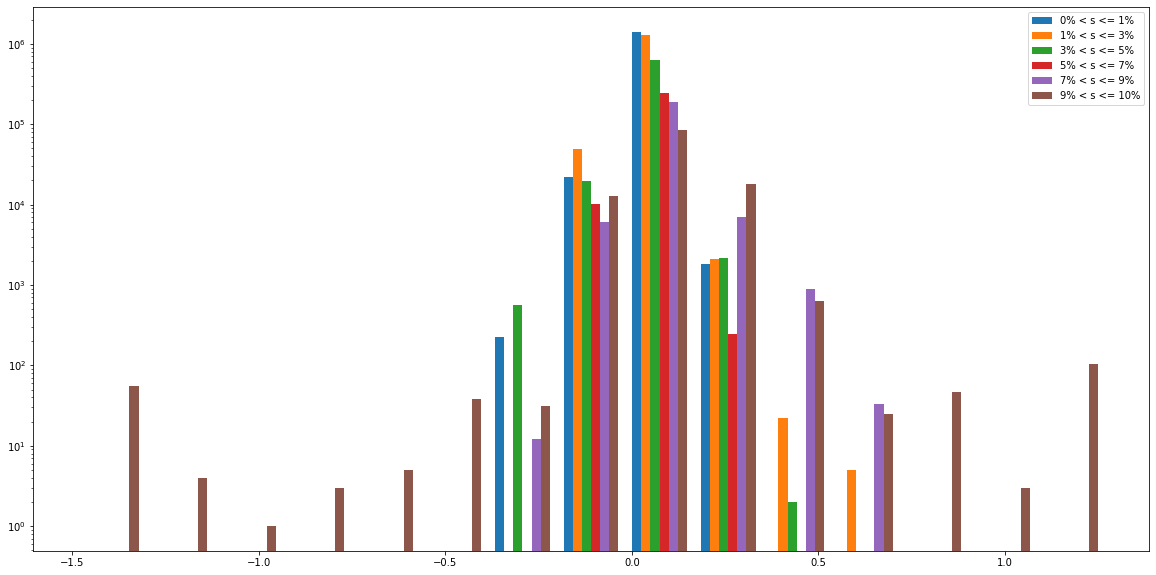

In [308]:
null_full = []
labels = []
for i in range(len(intervals) - 1):
    null = np.genfromtxt(os.path.join(SARS_DIR, f'null-distribution-{DATA_DATE}-{int(intervals[i]*100)}-{int(intervals[i+1]*100)}.csv'), 
                         delimiter=',')
    null_full.append(null)
    labels.append(str(int(intervals[i]*100)) + ' < s <= ' + str(int(intervals[i+1]*100)))
labels = []
for i in range(len(intervals) - 1):
    labels.append(str(int(intervals[i]*100)) + '% < s <= ' + str(int(intervals[i+1]*100)) + '%')
fig, axes = plt.subplots(1,1, figsize=[20,10])
axes.hist(null_full, histtype='bar', log=True, bins=15, label=labels)
axes.legend()
fig.savefig(os.path.join(DATA_DIR, f'null-distributions-{DATA_DATE}.pdf'), dpi=1500)

__Test india early detection__

In [720]:
regions = [
    'asia-india-west bengal.npz',
    'asia-india-maharashtra.npz',
    'asia-india-kerala.npz',
    'asia-india-karnataka.npz',
    'asia-india-telangana.npz', 
    'asia-india-maharashtra.npz',
    'asia-india-gujurat.npz',
    'asia-india-andhra pradesh.npz',
    'asia-india-haryana.npz',
]

locs     = regions
inf_dir  = os.path.join(DATA_DIR, DATA_DATE, f'infer-tv2')
traj_dir = os.path.join(DATA_DIR, 'trajectories')

for loc in locs:
    inf_data      = np.load(os.path.join(inf_dir, loc + '.npz'), allow_pickle=True)
    t_infer       = inf_data['time_infer']
    selection     = inf_data['selection']
    allele_number = inf_data['allele_number']
    mutant_sites  = []
    traj          = []
    times         = []
    if t_infer[-1] < 670:
        continue
    for file in os.listdir(traj_dir):
        if loc in file:
            df = pd.read_csv(os.path.join(traj_dir, file))
            traj.append(df.to_numpy()[:, 1:])
            mutant_sites.append(list(df.columns)[1:])
            times.append(list(df['time']))
    np.savez_compressed(
        os.path.join(DATA_DIR, f'infer-tv-{loc}.npz'),
        times=times,
        mutant_sites=mutant_sites,
        allele_number=allele_number,
        selection=selection,
        times_inf=t_infer,
        traj=traj
    )

In [730]:
delta = ['NSP12-671-0-A', 'NC-209-T', 'NSP13-77-1-T', 'S-19-1-G', 'S-156-1--', 'S-156-2--', 'S-157-0--', 'S-157-1--', 'S-157-2--', 
         'S-158-0--', 'S-478-1-A', 'S-950-0-A', 'ORF3a-26-1-T', 'M-82-1-C', 'ORF7a-82-1-C', 'ORF7a-120-1-T', 
         'ORF8-119-0--', 'ORF8-119-1--', 'ORF8-119-2--', 'ORF8-120-0--', 'ORF8-120-1--', 'ORF8-120-2--', 'N-63-1-G', 
         'N-377-0-T', 'S-452-1-G', 'S-681-1-G'] 
for loc in locs:
    infile  = os.path.join(DATA_DIR, 'infer-tv-' + loc + '.npz')
    outfile = os.path.join(DATA_DIR, loc + '-traj-selection')
    dp.save_traj_selection(infile, group=delta, traj_site='S-19-1-G', out_file=outfile)

/Users/brianlee/SARS-CoV-2-Data/2022-05-10/infer-tv-asia-india-karnataka.npz
/Users/brianlee/SARS-CoV-2-Data/2022-05-10/infer-tv-asia-india-kerala.npz
/Users/brianlee/SARS-CoV-2-Data/2022-05-10/infer-tv-asia-india-maharashtra.npz
/Users/brianlee/SARS-CoV-2-Data/2022-05-10/infer-tv-asia-india-west bengal.npz


ValueError: 'NSP12-671-0-A' is not in list

<a id='submission_date'></a>
# Trimming by Submission Date

__London__

In [75]:
# extracting only the data in the United Kingdom in London
identifier_uk = f'europe-united kingdom-lond'

selected_uk   =  [['europe', 'united kingdom', 'england', 'lond', None, None]]

f = open(os.path.join(SARS_DIR, identifier_uk + '.npy'), mode='w+b')
np.save(f, selected_uk)
f.close()

# Processing with multiple lightning mapped databases storing the sequences
data_module   = 'data_processing.py'
data_mod_path = os.path.join(SCRIPT_DIR, data_module)
out_folder    = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'msa-reg-uk')
input_file    = 'metadata-full-subdate.csv'
script_file   = 'extract-seqs.py'
region_dir    = os.path.join(SSH_DATA, f'regions-{DATA_DATE}-lond')
lmdb_dir      = os.path.join(SSH_DATA, f'lmdb-{DATA_DATE}')

# run on cluster
print(f'ls {region_dir} | wc -l')
num_regions = 1

job_file      = 'job-extract-lond.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/genome-lond-error
#SBATCH -o ./MPL/out/genome-lond-out
#SBATCH -p batch

module unload miniconda2 
module load miniconda3
conda activate sars-env

regions=({region_dir}/*)
region=${{regions[0]}}
python {script_file} --input_file {os.path.join(SSH_DATA, input_file)} -o {out_folder} --regions \"$region\"  --lmdb {lmdb_dir}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

print(f'scp {os.path.join(SARS_DIR, identifier_uk + ".npy")} {SSH_HOME}{region_dir} &&')
print('scp %s/%s %s. &&' % (SCRIPT_DIR, script_file, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, data_module, SSH_HOME))
#print('scp %s/%s %s. &&' % (SARS_DIR, identifier + '.npy', SSH_HOME))
print('scp %s/%s %s.'    % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s &&' % (SSH_HOME, out_folder, SARS_DIR))
print('scp -r %s%s %s' % (SSH_HOME, REF_TAG + '.fasta', SARS_DIR))

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/regions-2022-02-20-lond | wc -l
scp /Users/brianlee/SARS-CoV-2-Data/regions-2022-02-20-lond.npy blee098@secure.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/regions-2022-02-20-lond &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/extract-seqs.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-extract-lond.sh blee098@secure.hpcc.ucr.edu:.

sbatch job-extract-lond.sh

scp -r blee098@secure.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-02-20-lond/msa-reg-uk /Users/brianlee/SARS-CoV-2-Data &&
scp -r blee098@secure.hpcc.ucr.edu:EPI_ISL_402125.fasta /Users/brianlee/SARS-CoV-2-Data


In [95]:
# Processing with multiple lightning mapped databases storing the sequences
data_module   = 'data_processing.py'
data_mod_path = os.path.join(SCRIPT_DIR, data_module)
out_folder    = os.path.join(SSH_DATA, DATA_DATE + '-lond')
input_dir     = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'msa-reg-uk')
script_file   = 'process-subdate.py'

# run on cluster
print(f'ls {region_dir} | wc -l')
num_regions = 1

job_file      = 'job-process-lond.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=400G
#SBATCH --time=2-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/genome-subdate-error-%a
#SBATCH -o ./MPL/out/genome-subdate-out-%a
#SBATCH --array=0-{num_regions - 1}
#SBATCH -p highmem

module unload miniconda2 
module load miniconda3
conda activate sars-env

files=({input_dir}/*)
file=${{files[$SLURM_ARRAY_TASK_ID]}}
python {script_file} --input_file \"$file\" -o {out_folder} 
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

print(f'scp {SARS_DIR}/processing-new/{script_file} {SSH_HOME}')
print('scp %s/%s %s. &&' % (SCRIPT_DIR, data_module, SSH_HOME))
#print('scp %s/%s %s. &&' % (SARS_DIR, identifier + '.npy', SSH_HOME))
print('scp %s/%s %s.'    % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/regions-2022-02-20-lond | wc -l
scp /Users/brianlee/SARS-CoV-2-Data/processing-new/process_subdate.py blee098@secure.hpcc.ucr.edu:
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-process-lond.sh blee098@secure.hpcc.ucr.edu:.

sbatch job-process-lond.sh

scp -r blee098@secure.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-02-20-lond /Users/brianlee/SARS-CoV-2-Data &&
scp -r blee098@secure.hpcc.ucr.edu:EPI_ISL_402125.fasta /Users/brianlee/SARS-CoV-2-Data


In [22]:
# Finding time series with good sampling

input_dir     = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'genome-data')
output_dir    = os.path.join(SSH_DATA, DATA_DATE + '-lond')
data_module   = 'data_processing.py'
script_file   = 'trim-intervals-sd.py'

print(f'ls {input_dir} | wc -l')
print('')
num_files = 1

job_file      = 'job-trim-intervals-lond.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=250G
#SBATCH --time=20:00:00
#SBATCH -e ./MPL/out/trim-lond-error-%a
#SBATCH -o ./MPL/out/trim-lond-out-%a
#SBATCH --array=0-{num_files-1}

module unload miniconda2 
module load miniconda3
conda activate sars-env

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
file=${{files[$SLURM_ARRAY_TASK_ID]}}

python {script_file} --input \"$file\" -o {output_dir} --trimDir genome-trimmed
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', script_file)
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s. &&'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('scp %s/%s %s. &&' % (SCRIPT_DIR, data_module, SSH_HOME))
print('')

print('sbatch %s' % job_file)
print('')

print('scp -r %s%s %s' % (SSH_HOME, output_dir, SARS_DIR))

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-02-20-lond/genome-data | wc -l

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/trim-intervals-sd.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-trim-intervals-lond.sh blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@secure.hpcc.ucr.edu:. &&

sbatch job-trim-intervals-lond.sh

scp -r blee098@secure.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-02-20-lond /Users/brianlee/SARS-CoV-2-Data


In [271]:
# Finding maximum frequencies in each region

input_dir     = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'genome-trimmed')
output_dir    = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'max-freqs')
script_file   = 'find-max-frequencies.py'

# run on cluster to find number of files
print(f'ls {input_dir} | wc -l')    # in order to find the number of files in the input directory
print('')

num_files     = 5   # the number of data files 

job_file      = 'job-max-freqs-lond.sh'
job_str       = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=50G
#SBATCH --time=2-00:00:00
#SBATCH --mail-user={USER_NAME}{EMAIL_EXT}
#SBATCH --mail-type=ALL
#SBATCH -e ./MPL/out/freqs-lond-error-%a
#SBATCH -o ./MPL/out/freqs-lond-out-%a
#SBATCH --array=0-{num_files - 1}
#SBATCH -p batch

IFS=$'\\n'
files=($(find {input_dir} ! -name "*sites*"))
unset IFS

module unload miniconda2
module load miniconda3
conda activate sars-env

file=${{files[$SLURM_ARRAY_TASK_ID + 1]}}
python {script_file} --input_file \"$file\" -o {output_dir}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', script_file)
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-02-20-lond/genome-trimmed | wc -l

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/find-max-frequencies.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-max-freqs-lond.sh blee098@secure.hpcc.ucr.edu:.

sbatch job-max-freqs-lond.sh


In [252]:
# eliminate sites from a time-series if there are less than min_seqs total mutations at this site in all sequences in the time-series
min_seqs  = 5
min_freq  = 0.01
max_dir   = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'max-freqs')
out_dir   = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'genome-filtered')
input_dir = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'genome-trimmed')
script    = 'filter-low-counts.py'

job_file  = 'job-filter-counts-lond.sh'
job_str   = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=3-00:00:00
#SBATCH -e ./MPL/out/filter-counts-error
#SBATCH -o ./MPL/out/filter-counts-out
#SBATCH -p batch

module unload miniconda2 
module load miniconda3
conda activate sars-env

python {script} --input_dir {input_dir} -o {out_dir} --max_dir {max_dir} --min_count {min_seqs}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file), 'w')
f.write('%s\n' % job_str)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', script)
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file, SSH_HOME))
print('')

print('sbatch %s' % job_file)

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/filter-low-counts.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-filter-counts-lond.sh blee098@secure.hpcc.ucr.edu:.

sbatch job-filter-counts-lond.sh


In [261]:
# infering the selection coefficients using a cutoff frequency of 5%
input_dir      = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'genome-filtered-alpha')
freq_script    = 'epi-covar-sd.py'
inf_script     = 'epi-inf-parallel-sd.py'
archive_loc    = os.path.join(INF_DIR, 'Archive-vector')
temp_dir       = os.path.join(SSH_DATA, DATA_DATE + '-lond', 'freqs2')
out_file       = os.path.join(SSH_DATA, f'infer-{DATA_DATE}-lond')

# run on cluster
print(f'ls {input_dir} | wc -l')    # in order to find the number of files in the input directory
print('')

end_line  = '\\n'
num_files = 5    # the number of data files that must be read from the directory

job_file1 = 'job-freqs-sd-lond.sh'
job_str1  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-sd-lond-error-%a
#SBATCH -o ./MPL/out/freq-sd-lond-out-%a
#SBATCH --array=0-{num_files - 1}
#SBATCH -p highmem

module unload miniconda2
module load miniconda3
conda activate sars-env

cd ./Archive-vector
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
echo "$file"
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2 = 'job-infer-sd-lond.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/inf-lond-error
#SBATCH -o ./MPL/out/inf-lond-out

module unload miniconda2 
module load miniconda3
conda activate sars-env

outfile={out_file}
python {inf_script} --data {temp_dir} --timed 1 -o $outfile -q 5 --g1 10 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
freq_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
print('scp %s %s. &&'   % (freq_path, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file2)
print('mkdir %s &&'  % os.path.join(SSH_DATA, f'inf-{DATA_DATE}-lond'))
print('mv %s %s'     % (os.path.join(SSH_DATA, f'infer-{DATA_DATE}-lond-*'), os.path.join(SSH_DATA, f'inf-{DATA_DATE}-lond')))
print('')

# transfer files from cluster
print('scp -r %s%s/%s %s' % (SSH_HOME, SSH_DATA, f'inf-{DATA_DATE}-lond', INF_DIR))
#for r in regularization:
#    print('scp %s%s %s &&' % (SSH_HOME, out_file +  f'-g-{r}.npz', INF_DIR))

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-02-20-lond/genome-filtered-alpha | wc -l

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-covar-sd.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/Python/MPL/epi-inf-parallel-sd.py blee098@secure.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-vector blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-freqs-sd-lond.sh blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer-sd-lond.sh blee098@secure.hpcc.ucr.edu:.

sbatch job-freqs-sd-lond.sh &&
sbatch job-infer-sd-lond.sh &&
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/inf-2022-02-20-lond &&
mv /rhome/blee098/bigdata/SARS-CoV-2-Data/infer-2022-02-20-lond-* /rhome/blee098/bigdata/SARS-CoV-2-Data/inf-2022-02-20-lond

scp -r blee098@secure.hpcc.ucr.edu:/rhome/ble

2020-11-30


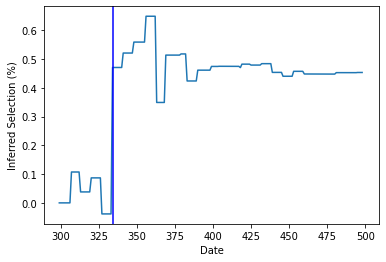

In [292]:
# combine inference files from different times
#inf_dir   = os.path.join(INF_DIR, f'inf-{DATA_DATE}-lond')
#selection = []
#times     = []
#sites     = []
#for file in sorted(os.listdir(inf_dir)):
#    #print(file)
#    filepath = os.path.join(inf_dir, file)
#    times.append(int(file[-7:-4]))
#    data = np.load(filepath, allow_pickle=True)
#    selection.append(data['selection'])
#    sites.append(data['allele_number'])
    
#f = open(os.path.join(INF_DIR, f'inf-{DATA_DATE}-tv-london.npz'), mode='wb')
#np.savez_compressed(f, selection=selection, sites=sites[0], times=times)
#f.close()
    
data      = np.load(os.path.join(INF_DIR, f'inf-2022-02-20-tv-london.npz'), allow_pickle=True)    
sites     = data['sites']
selection = data['selection']
times     = data['times']
alpha = ['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',
         'NSP6-108-1--', 'NSP6-108-2--', 'S-501-0-T', 'NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 
         'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
         'S-69-2--', 'S-70-0--', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-570-1-A', 'S-681-1-A', 'S-716-1-T', 'S-982-0-G', 
         'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T']

f = open(os.path.join(DATA_DIR, 'alpha-sites-exclusive.npy'), mode='wb')
np.save(f, alpha)
f.close()

#alleles    = [dp.get_label_new(i) for i in sites[0]]
#print(len(alleles), np.shape(selection))
#print(alleles)
alleles    = [dp.get_label_new(i) for i in sites]
idxs_alpha = [alleles.index(i) for i in alpha]
s_alpha    = np.sum(np.array(selection)[:, idxs_alpha], axis=1)
x_detect   = np.array(times)[s_alpha>0.13183][0]

out_file = os.path.join(DATA_DIR, 'alpha-subdate-early-detection.csv')
f = open(out_file, mode='w')
f.write('time,selection\n')
for i in range(len(times)):
    f.write(f'{times[i]},{s_alpha[i]:.5f}\n')
f.close()

fig, ax = plt.subplots(1,1)
ax.plot(times[:200], s_alpha[:200])
ax.set_xlim(times[0]-10, times[200]+10)
ax.set_ylabel('Inferred Selection (%)')
ax.set_xlabel('Date')
ax.axvline(x=x_detect, color='b')
print(dt.date(2020,1,1) + dt.timedelta(int(x_detect)))

__Great Britain__

In [365]:
# infering the selection coefficients using a cutoff frequency of 5%
input_old      = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
input_dir      = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-uk')
freq_script    = 'epi-covar-sd.py'
inf_script     = 'epi-inf-parallel-sd.py'
archive_loc    = os.path.join(INF_DIR, 'Archive-vector')
temp_dir       = os.path.join(SSH_DATA, DATA_DATE,'freqs-uk-sd')
out_file       = os.path.join(SSH_DATA, f'infer-{DATA_DATE}-uk', 'inf')

# run on cluster
print(f'mkdir {input_dir}')
print(f"""mv {input_old}/*england* {input_dir}""")
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print('')

num_files = 6    # the number of data files that must be read from the directory

job_file1 = 'job-freqs-sd-uk.sh'
job_str1  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2-00:00:00
#SBATCH -e ./MPL/out/freq-sd-uk-error-%a
#SBATCH -o ./MPL/out/freq-sd-uk-out-%a
#SBATCH --array=1-{num_files - 1}
#SBATCH -p highmem

module unload miniconda2
module load miniconda3
conda activate sars-env

cd ./Archive-vector
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
echo "$file"
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2 = 'job-infer-sd-uk.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=200G
#SBATCH --time=12-00:00:00
#SBATCH -e ./MPL/out/inf-uk-error
#SBATCH -o ./MPL/out/inf-uk-out
#SBATCH -p highmem

module unload miniconda2 
module load miniconda3
conda activate sars-env

outfile={out_file}
python {inf_script} --data {temp_dir} --timed 1 -o $outfile -q 5 --g1 10 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
freq_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
print('scp %s %s. &&'   % (freq_path, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file2)
print('mkdir %s &&'  % os.path.join(SSH_DATA, f'inf-{DATA_DATE}-uk'))
print('mv %s %s'     % (os.path.join(SSH_DATA, f'infer-{DATA_DATE}-uk-*'), os.path.join(SSH_DATA, f'inf-{DATA_DATE}-uk')))
print('')

# transfer files from cluster
print('scp -r %s%s/%s %s' % (SSH_HOME, SSH_DATA, f'infer-{DATA_DATE}-uk', INF_DIR))
#for r in regularization:
#    print('scp %s%s %s &&' % (SSH_HOME, out_file +  f'-g-{r}.npz', INF_DIR))

ls /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-02-20-uk/genome-filtered | wc -l

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-covar-sd.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/Python/MPL/epi-inf-parallel-sd.py blee098@secure.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-vector blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-freqs-sd-uk.sh blee098@secure.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer-sd-uk.sh blee098@secure.hpcc.ucr.edu:.

sbatch job-freqs-sd-uk.sh &&
sbatch job-infer-sd-uk.sh &&
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/inf-2022-02-20-uk &&
mv /rhome/blee098/bigdata/SARS-CoV-2-Data/infer-2022-02-20-uk-* /rhome/blee098/bigdata/SARS-CoV-2-Data/inf-2022-02-20-lond

scp -r blee098@secure.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-Co

2021-05-03


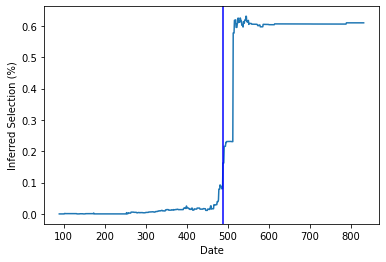

In [326]:
data = np.load(os.path.join(DATA_DIR, 'infer-2022-05-10-uk-sd2', 'inf.npz'), allow_pickle=True)
selection = data['selection']
sites     = data['allele_number']
times     = data['times']
    
f = open(os.path.join(INF_DIR, f'infer-2022-05-10-uk-sd.npz'), mode='wb')
np.savez_compressed(f, selection=selection, sites=sites, times=times)
f.close()
    
delta = ['NSP12-671-0-A', 'NC-209-T', 'NSP13-77-1-T', 'S-19-1-G', 'S-156-1--', 'S-156-2--', 'S-157-0--', 'S-157-1--', 'S-157-2--', 
         'S-158-0--', 'S-478-1-A', 'S-950-0-A', 'ORF3a-26-1-T', 'M-82-1-C', 'ORF7a-82-1-C', 'ORF7a-120-1-T', 
         'ORF8-119-0--', 'ORF8-119-1--', 'ORF8-119-2--', 'ORF8-120-0--', 'ORF8-120-1--', 'ORF8-120-2--', 'N-63-1-G', 
         'N-377-0-T', 'S-452-1-G', 'S-681-1-G']  

f = open(os.path.join(DATA_DIR, 'delta-sites-exclusive.npy'), mode='wb')
np.save(f, delta)
f.close()

alleles    = [dp.get_label_new(i) for i in sites]
#print(len(alleles), np.shape(selection))
#print(alleles)
idxs_delta = [alleles.index(i) for i in delta]
s_delta    = np.sum(np.array(selection)[:, idxs_delta], axis=1)
x_detect   = np.array(times)[s_delta>0.13183][0]

out_file = os.path.join(DATA_DIR, 'delta-subdate-early-detection.csv')
f = open(out_file, mode='w')
f.write('time,selection\n')
for i in range(len(times)):
    f.write(f'{times[i]},{s_delta[i]:.5f}\n')
f.close()

fig, ax = plt.subplots(1,1)
ax.plot(times, s_delta)
#ax.set_xlim(times[0]-10, times[200]+10)
ax.set_ylabel('Inferred Selection (%)')
ax.set_xlabel('Date')
ax.axvline(x=x_detect, color='b')
print(dt.date(2020,1,1) + dt.timedelta(int(x_detect)))

__South Africa__

In [109]:
# infering the selection coefficients using a cutoff frequency of 5%
input_old      = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
input_dir      = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-sa')
freq_script    = 'epi-covar-sd.py'
inf_script     = 'epi-inf-parallel-sd.py'
archive_loc    = os.path.join(INF_DIR, 'Archive-vector')
temp_dir       = os.path.join(SSH_DATA, DATA_DATE, 'freqs-south-africa-sd')
out_file       = os.path.join(SSH_DATA, f'infer-{DATA_DATE}-south-africa', 'inf')

# run on cluster
print(f'mkdir {input_dir}')
print(f"""mv {input_old}/africa-south* {input_dir}""")
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print(f'mkdir {temp_dir}')
print('')

num_files = 3    # the number of data files that must be read from the directory

job_file1 = 'job-freqs-sd-sa.sh'
job_str1  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=1-00:00:00
#SBATCH -e ./MPL/out/freq-sd-sa-error-%a
#SBATCH -o ./MPL/out/freq-sd-sa-out-%a
#SBATCH --array=1-{num_files - 1}

module unload miniconda2
module load miniconda3
conda activate sars-env

cd ./Archive-vector
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
echo "$file"
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --delta_t 15
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2 = 'job-infer-sd-sa.sh'

job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=1-00:00:00
#SBATCH -e ./MPL/out/inf-sa-error
#SBATCH -o ./MPL/out/inf-sa-out

module unload miniconda2 
module load miniconda3
conda activate sars-env
outfile={out_file}
python {inf_script} --data {temp_dir} --timed 1 -o $outfile -q 5 --g1 10 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
freq_path = os.path.join(SARS_DIR, 'processing-new', freq_script)
print('scp %s %s. &&'   % (freq_path, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file2)
print('mkdir %s &&'  % os.path.join(SSH_DATA, f'inf-{DATA_DATE}-uk'))
print('mv %s %s'     % (os.path.join(SSH_DATA, f'infer-{DATA_DATE}-uk-*'), os.path.join(SSH_DATA, f'inf-{DATA_DATE}-uk')))
print('')

# transfer files from cluster
print('scp -r %s%s/%s %s' % (SSH_HOME, SSH_DATA, f'infer-{DATA_DATE}-uk', INF_DIR))
#for r in regularization:
#    print('scp %s%s %s &&' % (SSH_HOME, out_file +  f'-g-{r}.npz', INF_DIR))

mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered-sa
mv /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered/africa-south* /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered-sa
readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered-sa ! -name "*sites*" -print0)
echo ${#files[*]}
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/freqs-south-africa-sd

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-covar-sd.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/Python/MPL/epi-inf-parallel-sd.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-vector blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-freqs-sd-sa.sh blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Proce

2021-12-07


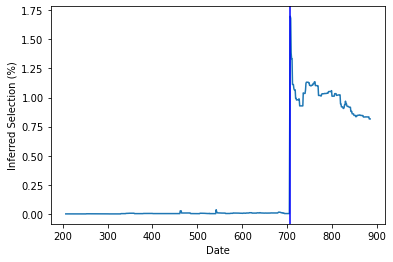

In [294]:
# combine inference files from different times
#inf_dir   = os.path.join(INF_DIR, f'infer-{DATA_DATE}-uk')
#selection = []
#times     = []
#sites     = []
#for file in sorted(os.listdir(inf_dir)):
    #print(file)
    #filepath = os.path.join(inf_dir, file)
    #times.append(int(file.split('---')[-1][:-4]))
    #data = np.load(filepath, allow_pickle=True)
    #selection.append(data['selection'])
    #sites.append(data['allele_number'])
    
#times = np.arange(np.amin(times), np.amax(times) + 1)
#for i in range(len(times))
data = np.load(os.path.join(SARS_DIR, DATA_DATE, f'infer-{DATA_DATE}-south-africa2', 'inf.npz'), allow_pickle=True)
selection = data['selection']
sites     = data['allele_number']
times     = data['times']
    
f = open(os.path.join(INF_DIR, f'infer-{DATA_DATE}-tv-sd-south-africa.npz'), mode='wb')
np.savez_compressed(f, selection=selection, sites=sites, times=times)
f.close()
    
omicron = ['NSP3-38-1-G', 'NSP3-889-2-G', 'NSP3-1265-1--', 'NSP3-1265-2--', 'NSP3-1266-0--', 
           'NSP3-1892-0-A', 'NSP5-132-1-A', 'NSP6-189-0-G', 'NSP10-57-2-C', 'NSP14-42-0-G', 
           'S-211-1--', 'S-211-2--', 'S-212-0--', 'S-446-0-A', 'S-547-1-A', 
           'S-856-2-A', 'S-954-2-T', 'S-969-2-A', 'S-981-0-T', 'ORF3a-64-2-T', 
           'E-9-1-T', 'M-19-0-G', 'M-63-0-A', 'ORF6-20-0-C', 'ORF7b-18-0-T', 
           'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 
           'N-32-1--', 'N-32-2--', 'N-33-0--', 'S-484-1-C', 'S-375-1-T', 'S-493-1-G', 
           'S-496-0-A', 'S-498-1-G', 'S-505-0-C', 'S-547-1-A']

f = open(os.path.join(DATA_DIR, 'omicron-sites-exclusive.npy'), mode='wb')
np.save(f, omicron)
f.close()

alleles    = [dp.get_label_new(i) for i in sites]
#print(len(alleles), np.shape(selection))
#print(alleles)
idxs_omicron = [alleles.index(i) for i in omicron]
s_omicron    = np.sum(np.array(selection)[:, idxs_omicron], axis=1)
x_detect   = np.array(times)[s_omicron>0.13183][0]

out_file = os.path.join(DATA_DIR, 'omicron-subdate-early-detection.csv')
f = open(out_file, mode='w')
f.write('time,selection\n')
for i in range(len(times)):
    f.write(f'{times[i]},{s_omicron[i]:.5f}\n')
f.close()

fig, ax = plt.subplots(1,1)
ax.plot(times, s_omicron)
#ax.set_xlim(times[0]-10, times[200]+10)
ax.set_ylabel('Inferred Selection (%)')
ax.set_xlabel('Date')
ax.axvline(x=x_detect, color='b')
print(dt.date(2020,1,1) + dt.timedelta(int(x_detect)))

<a id='bootstrap'></a>
# Bootstraping sequence data

In [130]:
# infering the selection coefficients using a cutoff frequency of 5%
input_dir      = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
freq_script    = 'epi-covar-bootstrap.py'
inf_script     = 'epi-inf-parallel.py'
archive_loc    = os.path.join(INF_DIR, 'Archive-test')
temp_dir       = os.path.join(SSH_DATA, DATA_DATE, 'freqs-bootstrap')
out_file       = os.path.join(SSH_DATA, DATA_DATE, f'infer-bs')
nruns  = 100
sample = 20

# run on cluster
print(f"""readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)""")    # in order to find the number of files in the input directory
print('echo ${#files[*]}')
print('cd Archive-test')
print('g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11')
print('')

num_files     = 518    # the number of data files that must be read from the directory

job_file1     = 'job-find-freqs-bs.sh'
job_str1      = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=3-00:00:00
#SBATCH -e ./MPL/out/freq-bs-error-%a
#SBATCH -o ./MPL/out/freq-bs-out-%a
#SBATCH --array=1-{num_files - 1}
#SBATCH -p highmem

readarray -d '' files < <(find {input_dir} ! -name "*sites*" -print0)
module unload miniconda2
module load miniconda3
conda activate sars-env

cd ./Archive-test
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11
pwd

file=${{files[$SLURM_ARRAY_TASK_ID]}}
tempout={temp_dir}
echo "$file"
python ../{freq_script} --data \"$file\" -o $tempout -q 5 --pop_size 10000 -k 0.1 -R 2 --scratch {SCRATCH} --timed 1 --nruns {nruns} --bsSample {sample}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file1), 'w')
f.write('%s\n' % job_str1)
f.close()

job_file2 = 'job-infer-bs.sh'
job_str2  = f"""#!/bin/bash -l 

#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=75G
#SBATCH --time=3-00:00:00
#SBATCH -e ./MPL/out/inf-error-%a
#SBATCH -o ./MPL/out/inf-out-%a
#SBATCH -p highmem
#SBATCH --array=0-{nruns-1}

module unload miniconda2 
module load miniconda3
conda activate sars-env

dirs=({temp_dir}/*)
dir=${{dirs[$SLURM_ARRAY_TASK_ID]}}
outfile={out_file}/$SLURM_ARRAY_TASK_ID
python {inf_script} --data $dir --timed 1 -o $outfile -q 5 --g1 40 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

# transfer files to cluster
script_path = os.path.join(SARS_DIR, 'processing-new', 'epi-covar-bootstrap.py')
print('scp %s %s. &&'      % (script_path, SSH_HOME))
print('scp %s/%s %s. &&'   % (INF_SCRIPTS, inf_script, SSH_HOME))
print('scp -r %s %s. &&'   % (archive_loc, SSH_HOME))
print('scp %s %s. &&'      % (os.path.join(SCRIPT_DIR, 'data_processing.py'), SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file1, SSH_HOME))
print('scp %s/%s %s.'      % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file1)
print('sbatch %s &&' % job_file2)
print(f'mkdir {out_file}')
print(f'mv {out_file}*.npz {out_file}')
print('')

# transfer files from cluster
print('scp -r %s%s/%s %s' % (SSH_HOME, SSH_DATA, out_file, INF_DIR))
#for r in regularization:
#    print('scp %s%s %s &&' % (SSH_HOME, out_file +  f'-g-{r}.npz', INF_DIR))

readarray -d '' files < <(find /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/genome-filtered ! -name "*sites*" -print0)
echo ${#files[*]}
cd Archive-test
g++ src/main.cpp src/inf.cpp src/io.cpp -O3 -march=native -lgslcblas -lgsl -o bin/mpl -std=c++11

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-covar-bootstrap.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/Python/MPL/epi-inf-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp -r /Users/brianlee/Python/MPL/6-29-20-epidemiological/Archive-test blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/data_processing.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-find-freqs-bs.sh blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer-bs.sh blee098@cluster.hpcc.ucr.edu:.

sbatch job-find-freqs-bs.sh &&
sbatch job-infer-bs.sh &&
mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/infer-bs
mv /rhome

In [255]:
data_dir = os.path.join(DATA_DIR, f'infer-bs')
for file in os.listdir(data_dir):
    if 'covar' in file or '.csv' in file:
        os.remove(os.path.join(data_dir, file))
#data1 = np.load(os.path.join(SARS_DIR, data_date, f'infer-subsample', 'infer-subsample-0.npz'))
data2 = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}.npz'))
#muts1 = data1['allele_number']
muts2 = data2['allele_number']
#s1    = data1['selection']
s2    = data2['selection']
muts  = []
for file in os.listdir(data_dir):
    muts.append(np.load(os.path.join(data_dir, file), allow_pickle=True)['allele_number'])
muts_all = [muts[i][j] for i in range(len(muts)) for j in range(len(muts[i]))]
muts_new = [i for i in muts2 if i in muts_all]

out_file = os.path.join(SARS_DIR, DATA_DATE, 'bootstrap-stats')
data = {'directory'    : data_dir,
        'out_file'     : out_file,
        'mutant_sites' : muts_new}
dp.find_bootstrap_stats(**data)
df = pd.read_csv(out_file + '.csv')
errors = list(df['standard_deviation'])

var_out   = os.path.join(SARS_DIR, DATA_DATE, 'variant-bootstrap-stats')
var_names = ['Alpha', 'Gamma', 'Delta', 'B.1',   '20E-EU1', 'Beta',   'Lambda', 'Epsilon', 'BA.4', 'BA.5', 'BA.2',  'BA.1', 'BA.2.12.1', 'Mu']
linked    = [  alpha,   gamma,   delta, D614G, twentyE_EU1,   beta, lambda_new,   epsilon,    ba4,    ba5,    ba2, omicron,      ba2121,   mu]
var_data  = {
    'directory'     : data_dir,
    'out_file'      : var_out,
    'linked_sites'  : linked,
    'variant_names' : var_names}
dp.bootstrap_variant_stats(**var_data)

#sorter = np.argsort(errors)[::-1]
#muts   = np.array(muts_new)[sorter]
#print(muts[:100])

#sorter = np.argsort(s2)
#s2     = s2[sorter]
#errors = np.array(errors)[sorter]

#mask   = np.absolute(s2)>0.01
#s2     = s2[mask]
#errors = errors[mask]

#fig, ax = plt.subplots(1,1, figsize=[20,10])
#ax.errorbar(np.arange(len(s2)), s2, yerr=errors, lw=0, marker='.', elinewidth=1)
"""
mask1 = np.isin(muts1, muts2)
muts1 = muts1[mask1]
s1    = s1[mask1]
mask2 = np.isin(muts2, muts1)
muts2 = muts2[mask2]
s2    = s2[mask2]

data = {'directory' : bs_dir,
        'out_file'  : out_file}
dp.find_bootstrap_stats(**data)

fig, ax = plt.subplots(1,1, figsize=[10,10])
ax.set_xlim(-0.04, 0.08)
ax.set_ylim(-0.04, 0.08)
ax.scatter(s1, s2, marker='.')
ax.plot(np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100), np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100))
ax.set_xlabel('Subsampled data')
ax.set_ylabel('Full data')
"""

"\nmask1 = np.isin(muts1, muts2)\nmuts1 = muts1[mask1]\ns1    = s1[mask1]\nmask2 = np.isin(muts2, muts1)\nmuts2 = muts2[mask2]\ns2    = s2[mask2]\n\ndata = {'directory' : bs_dir,\n        'out_file'  : out_file}\ndp.find_bootstrap_stats(**data)\n\nfig, ax = plt.subplots(1,1, figsize=[10,10])\nax.set_xlim(-0.04, 0.08)\nax.set_ylim(-0.04, 0.08)\nax.scatter(s1, s2, marker='.')\nax.plot(np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100), np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100))\nax.set_xlabel('Subsampled data')\nax.set_ylabel('Full data')\n"

In [254]:
# regular selection for old data
ref_file = os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
dp.website_file2(os.path.join(INF_DIR, f'inf-data-nonsynonymous-{DATA_DATE}.npz'),
                 os.path.join(DATA_DIR, 'synonymous-prot.npz'),
                 os.path.join(DATA_DIR, 'linked-sites.npy'), 
                 os.path.join(DATA_DIR, f'selection-nonsyn-bootstrap.csv'),
                 ref_file=ref_file,
                 bootstrap_file=os.path.join(DATA_DIR, 'bootstrap-stats.csv'))

all fields calculated, putting data into dataframe...
index 1259
nucleotide number 1259
protein 1259
amino acid number in protein 1259
amino acid number in reading frame 1259
synonymous 1259
amino acid mutation 1259
nucleotide 1259
reference nucleotide 1259
selection coefficient 1259
standard deviation 1259
error 1259
independent model coefficient 1259
linked sites 1259
type of linked group 1259
total coefficient for linked group 1259
error for linked group 1259


In [266]:
data = pd.read_csv(os.path.join(SARS_DIR, DATA_DATE, f'selection-nonsyn-bootstrap.csv'))
#print(data.columns)
mean_s  = data['selection coefficient']
std_dev = data['standard deviation']
print(np.mean(np.absolute(std_dev)))

0.0014867985746752613


<a id=‘regional_subsampling’></a>
# Subsampling regions

In [61]:
# infering the selection coefficients using a cutoff frequency of 5%
inf_script = 'epi-inf-parallel.py'
temp_dir   = os.path.join(SSH_DATA, DATA_DATE, 'freqs')
out_dir    = os.path.join(SSH_DATA, DATA_DATE, f'infer-subsample')


job_file2 = 'job-infer-subsample.sh'
job_str2  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=75G
#SBATCH --time=24:00:00
#SBATCH -e ./MPL/out/inf-subsample-error-%a
#SBATCH -o ./MPL/out/inf-subsample-out-%a
#SBATCH --array=0-100
#SBATCH -p batch

module unload miniconda2 
module load miniconda3
conda activate sars-env

outfile={out_dir}/$SLURM_ARRAY_TASK_ID
python {inf_script} --data {temp_dir} --timed 1 -o $outfile -q 5 --g1 40 --regPCT 80 --refFile {REF_FILE + '.csv'}
"""

f = open(os.path.join(SCRIPT_DIR, job_file2), 'w')
f.write('%s\n' % job_str2)
f.close()

script_path = os.path.join(SARS_DIR, 'processing-new', inf_script)
# transfer files to cluster
print('scp %s %s. &&'   % (script_path, SSH_HOME))
print('scp %s/%s %s.'   % (SCRIPT_DIR, job_file2, SSH_HOME))
print('')

# run on cluster
print(f'mkdir {out_dir} &&')
print('sbatch %s' % job_file2)
print('')

# transfer files from cluster
print(f'scp -r {SSH_HOME}{out_dir} {INF_DIR}')

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/epi-inf-parallel.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-infer-subsample.sh blee098@cluster.hpcc.ucr.edu:.

mkdir /rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/infer-subsample &&
sbatch job-infer-subsample.sh

scp -r blee098@cluster.hpcc.ucr.edu:/rhome/blee098/bigdata/SARS-CoV-2-Data/2022-06-09/infer-subsample /Users/brianlee/Python/MPL/6-29-20-epidemiological


In [126]:
data_dir = os.path.join(DATA_DIR, f'infer-subsample')
for file in os.listdir(data_dir):
    if 'covar' in file or '.csv' in file:
        os.remove(os.path.join(data_dir, file))
#data1 = np.load(os.path.join(SARS_DIR, data_date, f'infer-subsample', 'infer-subsample-0.npz'))
data2 = np.load(os.path.join(INF_DIR, f'infer-{DATA_DATE}.npz'))
#muts1 = data1['allele_number']
muts2 = data2['allele_number']
#s1    = data1['selection']
s2    = data2['selection']
muts  = []
for file in os.listdir(data_dir):
    muts.append(np.load(os.path.join(data_dir, file), allow_pickle=True)['allele_number'])
muts_all = [muts[i][j] for i in range(len(muts)) for j in range(len(muts[i]))]
muts_new = [i for i in muts2 if i in muts_all]

out_file = os.path.join(DATA_DIR, 'subsample-stats')
data = {'directory'    : data_dir,
        'out_file'     : out_file,
        'mutant_sites' : muts_new}
dp.find_bootstrap_stats(**data)
df = pd.read_csv(out_file + '.csv')
errors = list(df['standard_deviation'])

var_out   = os.path.join(SARS_DIR, DATA_DATE, 'variant-subsample-stats')
var_names = ['Alpha', 'Gamma', 'Delta', 'B.1',   '20E-EU1', 'Beta',   'Lambda', 'Epsilon', 'BA.4', 'BA.5', 'BA.2',  'BA.1', 'BA.2.12.1']
linked    = [  alpha,   gamma,   delta, D614G, twentyE_EU1,   beta, lambda_new,   epsilon,    ba4,    ba5,    ba2, omicron,      ba2121]
var_data  = {
    'directory'     : data_dir,
    'out_file'      : var_out,
    'linked_sites'  : linked,
    'variant_names' : var_names}
dp.bootstrap_variant_stats(**var_data)

#sorter = np.argsort(errors)[::-1]
#muts   = np.array(muts_new)[sorter]
#print(muts[:100])

#sorter = np.argsort(s2)
#s2     = s2[sorter]
#errors = np.array(errors)[sorter]

#mask   = np.absolute(s2)>0.01
#s2     = s2[mask]
#errors = errors[mask]


#fig, ax = plt.subplots(1,1, figsize=[20,10])
#ax.errorbar(np.arange(len(s2)), s2, yerr=errors, lw=0, marker='.', elinewidth=1)
"""
mask1 = np.isin(muts1, muts2)
muts1 = muts1[mask1]
s1    = s1[mask1]
mask2 = np.isin(muts2, muts1)
muts2 = muts2[mask2]
s2    = s2[mask2]

data = {'directory' : bs_dir,
        'out_file'  : out_file}
dp.find_bootstrap_stats(**data)

fig, ax = plt.subplots(1,1, figsize=[10,10])
ax.set_xlim(-0.04, 0.08)
ax.set_ylim(-0.04, 0.08)
ax.scatter(s1, s2, marker='.')
ax.plot(np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100), np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100))
ax.set_xlabel('Subsampled data')
ax.set_ylabel('Full data')
"""

"\nmask1 = np.isin(muts1, muts2)\nmuts1 = muts1[mask1]\ns1    = s1[mask1]\nmask2 = np.isin(muts2, muts1)\nmuts2 = muts2[mask2]\ns2    = s2[mask2]\n\ndata = {'directory' : bs_dir,\n        'out_file'  : out_file}\ndp.find_bootstrap_stats(**data)\n\nfig, ax = plt.subplots(1,1, figsize=[10,10])\nax.set_xlim(-0.04, 0.08)\nax.set_ylim(-0.04, 0.08)\nax.scatter(s1, s2, marker='.')\nax.plot(np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100), np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100))\nax.set_xlabel('Subsampled data')\nax.set_ylabel('Full data')\n"

In [735]:
data1 = np.load(os.path.join(SARS_DIR, data_date, f'infer-{data_date}-subsample.npz'))
data2 = np.load(os.path.join(INF_DIR, f'infer-{data_date}-g-40-observed.npz'))
muts1 = data1['allele_number']
muts2 = data2['allele_number']
s1    = data1['selection']
s2    = data2['selection']
print(len(muts1), len(muts2))

mask1 = np.isin(muts1, muts2)
muts1 = muts1[mask1]
s1    = s1[mask1]
mask2 = np.isin(muts2, muts1)
muts2 = muts2[mask2]
s2    = s2[mask2]

fig, ax = plt.subplots(1,1, figsize=[10,10])
ax.set_xlim(-0.04, 0.08)
ax.set_ylim(-0.04, 0.08)
ax.scatter(s1, s2, marker='.')
ax.plot(np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100), np.linspace(np.amin(np.append(s1, s2)), np.amax(np.append(s1, s2)), 100))
ax.set_xlabel('Subsampled data')
ax.set_ylabel('Full data')

NameError: name 'data_date' is not defined

In [128]:
os.chdir(SCRIPT_DIR)
import data_processing as dp
reload(dp)
os.chdir(SARS_DIR)

In [130]:
# regular selection for old data
ref_file = os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
dp.website_file2(os.path.join(INF_DIR, f'inf-data-nonsynonymous-{DATA_DATE}.npz'),
                 os.path.join(DATA_DIR, 'synonymous-prot.npz'),
                 os.path.join(DATA_DIR, 'linked-sites.npy'), 
                 os.path.join(DATA_DIR, f'selection-nonsyn-subsample.csv'),
                 ref_file=ref_file,
                 bootstrap_file=os.path.join(DATA_DIR, 'subsample-stats.csv'))

all fields calculated, putting data into dataframe...
index 1259
nucleotide number 1259
protein 1259
amino acid number in protein 1259
amino acid number in reading frame 1259
synonymous 1259
amino acid mutation 1259
nucleotide 1259
reference nucleotide 1259
selection coefficient 1259
standard deviation 1259
error 1259
independent model coefficient 1259
linked sites 1259
type of linked group 1259
total coefficient for linked group 1259
error for linked group 1259


In [138]:
# Find mutations that are in the same codon and strongly linked to one another and sum their selection coefficients
data  = np.load(os.path.join(SARS_DIR, DATA_DATE, 'linked-sites.npy'), allow_pickle=True)
nucs  = [np.array([data[i][j][-1] for j in range(len(data[i]))]) for i in range(len(data))]
idxs  = []
for i in range(len(data)):
    if len(np.array(nucs[i])[nucs[i]=='-']) != len(nucs[i]):
        idxs.append(i)
data = data[idxs]
#for i in data:
    #print(np.sort(i))
split = [[data[i][j].split('-') for j in range(len(data[i]))] for i in range(len(data))]
cods  = [[split[i][j][1] for j in range(len(split[i]))] for i in range(len(split))]
prots = [[split[i][j][0] for j in range(len(split[i]))] for i in range(len(split))]
    
#linked_same_codon = []
linked_groups     = []
for i in range(len(data)):
    group   = data[i]
    #g_nucs  = nucs[i]
    g_cods  = cods[i]
    g_prots = prots[i]
    prot_unique = np.unique(g_prots)
    for j in range(len(prot_unique)):
        temp_cods   = np.array(g_cods)[np.array(g_prots)==prot_unique[j]]
        temp_labs   = np.array(group)[np.array(g_prots)==prot_unique[j]]
        cods_unique = np.unique(temp_cods)
        for k in range(len(cods_unique)):
            labs_same_cod = temp_labs[temp_cods==cods_unique[k]]
            if len(labs_same_cod)>1:
                linked_groups.append(labs_same_cod)
                #for l in labs_same_cod:
                    #linked_same_codon.append(l)
#linked_same_codon = [i for i in linked_same_codon if i[-1]!='-']
linked_groups     = [[linked_groups[i][j] for j in range(len(linked_groups[i])) if linked_groups[i][j][-1]!='-'] for i in range(len(linked_groups))]
linked_groups     = [i for i in linked_groups if len(i)!=0]
linked_all        = [linked_groups[i][j] for i in range(len(linked_groups)) for j in range(len(linked_groups[i]))]


# collapse identical mutations and sum contributions
df_sel = pd.read_csv(os.path.join(SARS_DIR, DATA_DATE, f'selection-nonsyn-subsample.csv'), memory_map=True)

f = open(os.path.join(SARS_DIR, DATA_DATE, f'selection-nonsyn-subsample-collapsed.csv'), 'w')

headers = list(df_sel.columns)
f.write('%s\n' % ','.join(headers))

print('name\tn dupes\ttotal s')

dup_names = []
for iter, entry in df_sel.iterrows():
    if entry['protein']=='NC':
        continue
    loc      = str(entry['amino acid number in protein'])
    anc      = entry['amino acid mutation'][0]
    mut      = entry['amino acid mutation'][-1]
    var_name = str(entry['protein']) + '-' + anc + loc + mut
    label    = dp.get_label_new(str(entry['nucleotide number']) + '-' + entry['nucleotide'])
    if var_name in dup_names:
        continue
    
    df_same = df_sel[(df_sel['protein']==entry['protein']) 
                     & (df_sel['amino acid number in protein']==entry['amino acid number in protein'])
                     & (df_sel['amino acid mutation']==entry['amino acid mutation'])]
    
    s = entry['selection coefficient']
    if len(df_same)>1:
        s = np.sum(df_same['selection coefficient'])
        if var_name[-1]!='-' and label not in linked_all:
            s = np.max(df_same['selection coefficient'])
        dup_names.append(var_name)
        if np.fabs(s)>0.03:
            print('%s\t%d\t%.3f' % (var_name, len(df_same), s))
        
    for i in range(len(headers)):
        if headers[i]=='selection coefficient':
            f.write('%s' % str(s))
        elif headers[i]=='linked sites':
            f.write('"%s"' % str(entry[headers[i]]))
#         elif headers[i]=='nucleotide number':
#             f.write('%s' % entry[headers[i]][:-2])
        else:
            f.write('%s' % str(entry[headers[i]]))
        if i!=len(headers)-1:
            f.write(',')
    f.write('\n')

f.close()

# Change nucleotide indices to be indexed starting with 1 instead of 0 for publishing
df = pd.read_csv(os.path.join(SARS_DIR, DATA_DATE, f'selection-nonsyn-subsample-collapsed.csv'), index_col=False)
nucs = list(df['nucleotide number'])
new_nucs = []
for i in nucs:
    num, letters = dp.separate_label_idx(str(i))
    if letters=='':
        new_nucs.append(str(int(num) + 1))
    else:
        new_nucs.append(str(int(num) + 1) + letters)
nucs = new_nucs
df['nucleotide number'] = nucs
df.to_csv(os.path.join(SARS_DIR, DATA_DATE, f'selection-nonsyn-subsample-corrected.csv'), index=False)

name	n dupes	total s
NSP6-L105-	3	-0.097
NSP6-S106-	3	0.150
S-P25-	3	0.040
S-G142-	2	0.135
S-G142D	2	0.064
S-V143-	3	0.087
S-Y144-	3	-0.052
S-F157-	3	0.036
S-N440K	2	0.078
S-N679K	2	0.049
ORF6-D61L	3	-0.052
ORF8-F120-	3	0.044
N-D3L	3	0.084
N-E31-	3	0.073
N-R32-	3	0.072
N-R203K	2	0.047


In [236]:
ef.selection_table(os.path.join(SARS_DIR, data_date, f'selection-g40-1pct-nonsyn-collapsed-paper-new.csv'),
                   out = os.path.join(INF_SCRIPTS, 'figures', 'selection-table'))

\setlength{\tabcolsep}{12pt}
\begin{table}
\centering
\begin{tabular}{lllllll}
\toprule
 Rank   & Protein   & Mutation (nt)   & Mutation (aa)   & Selection (\%)   & Location   & Phenotypic effect   \\
\midrule
 1      & S         & T22917G         & L452R           & 7.5 $\pm$ 0.3   &            &                     \\
 2      & M         & T26767C         & I82T            & 7.5 $\pm$ 0.4   &            &                     \\
 3      & S         & C23604G         & P681R           & 7.2 $\pm$ 0.3   &            &                     \\
 4      & S         & C23604A         & P681H           & 6.5 $\pm$ 0.4   &            &                     \\
 5      & N         & G28280C         & D3L             & 6.0 $\pm$ 0.3   &            &                     \\
 6      & N         & G28280-         & D3-             & 5.7 $\pm$ 0.2   &            &                     \\
 7      & NSP13     & C16466T         & P77L            & 5.5 $\pm$ 0.4   &            &                     \\
 8    

In [247]:
# Variant coefficients 
args = {
    'infer_file'    : os.path.join(INF_DIR, f'infer-{DATA_DATE}-observed-g-40.npz'),
    'link_file'     : os.path.join(DATA_DIR, 'linked-sites.npy'),
    'syn_prot_file' : os.path.join(DATA_DIR, 'synonymous-prot.npz'),
    'variant_file'  : os.path.join(SARS_DIR, 'variants.npy'),
    'bootstrap_dir' : os.path.join(DATA_DIR, f'infer-subsample'),
    'out_file'      : os.path.join(DATA_DIR, 'linked-coefficients-new.csv'),
    'ref_file'      : os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
}

dp.linked_analysis_alt(**args)

# Make a csv file containing the frequency trajectories for the different variants in different regions
#dp.linked_traj_csv(os.path.join(SARS_DIR, data_date, 'linked-coefficients-g-40-1pct.csv'), 
#                   os.path.join(SARS_DIR, data_date, 'trajectories-1pct.npz'), 
#                   os.path.join(SARS_DIR, data_date, 'linked-trajectories-1pct'))

NSP5-8-1-A
NSP2-78-2-C
NSP13-574-0-C
NSP13-574-1-T
NSP6-20-2-A
S-532-0-C
NSP3-210-0-C
NSP8-134-2-G
NSP4-320-0-G
NSP14-376-1-C
NSP3-1181-2-G
NSP14-313-1-T
NSP2-367-2-A
NSP3-1451-1-C
S-234-2-G
S-235-0-C
S-235-1-A
S-236-1-T
S-236-2-A
NSP2-487-0-G
M-118-2-A
ORF8-3-1-A
N-209-0-G
NSP3-332-0-A
NSP3-332-1-A
NSP3-570-1-C
NSP3-614-2-C
NSP3-616-0-T
NSP3-616-1-C
NSP3-623-0-G
NSP3-623-1-C
NSP3-624-2-A
NSP3-627-1-G
NSP3-628-1-A
NSP3-628-2-A
NSP3-629-0-T
NSP3-629-1-T


In [248]:
df = pd.read_csv(os.path.join(DATA_DIR, 'linked-coefficients-new.csv'), index_col=False)
nucs = list(df['nucleotides'])
nucs = [i.split('/') for i in nucs]
nucs_new = []
for i in nucs:
    nucs_temp = []
    for j in i:
        num, letters = dp.separate_label_idx(str(j))
        if j=='not_present':
            nucs_temp.append(j)
        elif letters=='':
            nucs_temp.append(str(int(num) + 1))
        else:
            nucs_temp.append(str(int(num) + 1) + letters)
    nucs_new.append(nucs_temp)
nucs = ['/'.join(i) for i in nucs_new]
df['nucleotides'] = nucs
df = df.rename(columns={'standard deviation' : 'standard_deviation'})
df.to_csv(os.path.join(DATA_DIR, 'linked-coefficients-new-paper.csv'), index=False)

In [245]:
# Make a csv file containing the frequency trajectories for the different variants in different regions
delta_file  = os.path.join(DATA_DIR, 'delta-traj.csv')
ba2_file    = os.path.join(DATA_DIR, 'ba2-traj.csv')
lambda_file = os.path.join(DATA_DIR, 'lambda-traj.csv')
dp.linked_traj_csv(os.path.join(DATA_DIR, 'linked-coefficients-new.csv'), 
                   os.path.join(DATA_DIR, 'trajectories15'), 
                   os.path.join(DATA_DIR, 'linked-trajectories-new'),
                   delta_file=delta_file,
                   ba2_file=ba2_file,
                   lambda_file=lambda_file)

In [311]:
# Variant coefficients for all named variants
args = {
    'infer_file'    : os.path.join(INF_DIR, f'infer-{DATA_DATE}-observed.npz'),
    'link_file'     : os.path.join(DATA_DIR, 'linked-sites.npy'),
    'syn_prot_file' : os.path.join(DATA_DIR, 'synonymous-prot.npz'),
    'variant_file'  : os.path.join(SARS_DIR, 'variants-all.npy'),
    'bootstrap_dir' : os.path.join(DATA_DIR, f'infer-subsample'),
    'out_file'      : os.path.join(DATA_DIR, 'linked-coefficients-all.csv'),
    'ref_file'      : os.path.join(DATA_DIR, f'ref-index-{DATA_DATE}.csv')
}

dp.linked_analysis_alt(**args)

# Make a csv file containing the frequency trajectories for the different variants in different regions
#dp.linked_traj_csv(os.path.join(SARS_DIR, data_date, 'linked-coefficients-g-40-1pct.csv'), 
#                   os.path.join(SARS_DIR, data_date, 'trajectories-1pct.npz'), 
#                   os.path.join(SARS_DIR, data_date, 'linked-trajectories-1pct'))

NSP5-8-1-A
NSP2-78-2-C
NSP13-574-0-C
NSP13-574-1-T
NSP6-20-2-A
S-532-0-C
NSP3-210-0-C
NSP8-134-2-G
NSP4-320-0-G
NSP14-376-1-C
NSP3-1181-2-G
NSP14-313-1-T
NSP2-367-2-A
NSP3-1451-1-C
S-234-2-G
S-235-0-C
S-235-1-A
S-236-1-T
S-236-2-A
NSP2-487-0-G
M-118-2-A
ORF8-3-1-A
N-209-0-G
NSP3-332-0-A
NSP3-332-1-A
NSP3-570-1-C
NSP3-614-2-C
NSP3-616-0-T
NSP3-616-1-C
NSP3-623-0-G
NSP3-623-1-C
NSP3-624-2-A
NSP3-627-1-G
NSP3-628-1-A
NSP3-628-2-A
NSP3-629-0-T
NSP3-629-1-T
N-2-1--
N-2-2--
N-3-0--
ORF6-2-0--
ORF6-2-1--
ORF6-2-2--
S-1062-2-C
N-232-2-A


In [232]:
# Make a csv file containing the frequency trajectories for the different variants in different regions
delta_file = os.path.join(DATA_DIR, 'delta-traj.csv')
ba2_file   = os.path.join(DATA_DIR, 'ba2-traj.csv')
lambda_file = os.path.join(DATA_DIR, 'lambda-traj.csv')
dp.linked_traj_csv(os.path.join(DATA_DIR, 'linked-coefficients-all.csv'), 
                   os.path.join(DATA_DIR, 'trajectories15'), 
                   os.path.join(DATA_DIR, 'linked-trajectories-all'),
                   delta_file=delta_file,
                   ba2_file=ba2_file,
                   lambda_file=lambda_file)

In [265]:
data = pd.read_csv(os.path.join(SARS_DIR, DATA_DATE, f'selection-nonsyn-subsample-corrected.csv'))
#print(data.columns)
mean_s  = data['selection coefficient']
std_dev = data['standard deviation']
print(np.mean(np.absolute(std_dev)))

0.0033658332187274996
1.19157055674524


<a id=‘variant_detection_table’></a>
# Variant early detection table

In [227]:
epsilon        = np.unique(['NSP13-260-0-T', 'S-13-1-T', 'S-152-2-T', 'NC-28271-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 
                  'S-452-1-G', 'N-205-1-T', 'ORF3a-57-2-T', 'NSP9-65-0-G']) # Done

alpha          = np.unique(['NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',
                  'NSP6-108-1--', 'NSP6-108-2--', 'S-501-0-T', 'NSP12-412-2-T', 'NSP2-36-2-T', 'NSP3-183-1-T', 'NSP3-890-1-A', 
                  'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP12-613-2-T', 'NSP12-912-2-C', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
                  'S-69-2--', 'S-70-0--', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-570-1-A', 'S-681-1-A', 'S-716-1-T', 'S-982-0-G', 
                  'S-1118-0-C', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'N-235-1-T',
                  'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G'])    # Done

# NEED TO ADD S:D138Y
gamma          = np.unique(['NSP9-31-2-T', 'NSP1-156-2-C', 'NSP3-10-2-T', 'NSP3-370-1-T', 'NSP3-977-0-C', 'NSP3-1200-2-G', 'NSP3-1298-2-G', 
                  'NSP12-140-2-T', 'NSP13-341-2-T', 'S-20-1-A', 'S-417-1-C', 'S-1027-1-T', 'ORF3a-253-0-C', 'ORF8-92-0-A', 'N-80-1-G', 
                  'S-190-2-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-501-0-T', 'NSP6-106-0--', 'NSP6-106-1--', 
                  'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--',
                  'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'N-202-0-T', 'N-202-1-C', 'S-18-0-T', 'S-26-0-T', 'S-655-0-T',
                  'S-1176-0-T'])    # Done

twentyE_EU1    = np.unique(['NSP16-199-2-C', 'NSP1-60-2-C', 'NSP3-1189-2-T', 'M-93-2-G', 'N-220-1-T', 'ORF10-30-0-T', 'S-222-1-T',
                  'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G'])    # Done
# This is Pango lineage B.1.177

delta          = np.unique(['NSP12-671-0-A', 'NC-209-T', 'NSP13-77-1-T', 'S-19-1-G', 'S-156-1--', 'S-156-2--', 'S-157-0--', 'S-157-1--', 'S-157-2--', 
                  'S-158-0--', 'S-478-1-A', 'S-681-1-G', 'S-950-0-A', 'ORF3a-26-1-T', 'M-82-1-C', 'ORF7a-82-1-C', 'ORF7a-120-1-T', 
                  'ORF8-119-0--', 'ORF8-119-1--', 'ORF8-119-2--', 'ORF8-120-0--', 'ORF8-120-1--', 'ORF8-120-2--', 'N-63-1-G', 'N-203-1-T', 
                  'N-377-0-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-452-1-G', 'NC-28270--', 'NSP4-492-1-T'])    # Done

beta           = np.unique(['S-80-1-C', 'NSP3-837-2-T', 'S-215-1-G', 'E-71-1-T', 'S-240-2--', 'S-241-0--', 'S-242-1--', 'S-242-2--', 'S-243-0--', 
                  'S-240-1--', 'S-241-1--', 'S-241-2--', 'S-242-0--', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-501-0-T',
                  'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 
                  'NSP6-108-1--', 'NSP6-108-2--', 'S-417-2-T', 'S-484-0-A', 'S-701-1-T', 'ORF3a-57-2-T', 'NSP2-85-1-T', 'NSP5-90-1-G',
                  'N-205-1-T', 'NC-173-T', 'ORF8-120-2-T'])    # Done

lambda_new     = np.unique(['S-246-2--', 'NSP3-1569-0-G', 'S-247-0--', 'S-247-1--', 'S-247-2--', 'S-248-0--', 'S-248-1--', 'S-248-2--', 'S-249-0--', 
                  'S-249-1--', 'S-249-2--', 'S-250-0--', 'S-250-1--', 'S-250-2--', 'S-251-0--', 'S-251-1--', 'S-251-2--', 'S-252-0--', 
                  'S-246-1--', 'S-252-1--', 'S-252-2--', 'S-253-0--', 'N-214-0-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 
                  'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 
                  'NSP6-108-1--', 'NSP6-108-2--', 'S-75-1-T', 'S-76-1-T', 'S-452-1-A', 'S-490-1-C', 'S-859-1-A', 'NSP3-428-1-T',
                  'NSP3-1469-0-T', 'NSP4-438-1-C', 'NSP4-492-1-T', 'NSP5-15-0-A']) # Done

iota           = np.unique(['N-234-2-A', 'S-5-0-T', 'S-95-1-T', 'S-253-1-G', 'S-484-0-A', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G',
                 'S-701-1-T', 'NSP13-88-2-C', 'ORF3a-42-1-T', 'ORF3a-67-2-T', 'NSP2-85-1-T', 'NSP4-438-1-C', 'NSP6-106-0--', 'NSP6-106-1--', 
                 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',  'NSP6-108-1--', 'NSP6-108-2--', 'N-199-1-T',
                 'N-232-2-A', 'ORF8-11-1-T', 'NSP15-214-2-G', 'NC-28270--'])

D614G          = ['NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G']    # Done

B1_1_318       = np.unique(['NSP15-320-0-A', 'S-575-2-C', 'S-1238-2-A', 'ORF7b-44-2--', 'NC-27887--', 'NC-27888--', 'NC-27889--', 'NC-27890--', 
                  'NC-27891--', 'NC-27892--', 'ORF8-1-0--', 'ORF8-1-1--', 'ORF8-1-2--', 'NSP4-173-1-T', 'S-796-0-C', 'ORF8-2-0--', 
                  'ORF8-2-1--', 'ORF8-2-2--', 'ORF8-3-0--', 'ORF8-3-1--', 'NC-28270-G', 'N-208-2--', 'N-209-0--', 'N-208-1--',
                  'NSP3-378-1-T', 'NSP3-1693-2-T', 'NSP5-21-1-T', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 
                  'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--', 'S-95-1-T', 'S-143-2--', 'S-144-0--', 
                  'S-144-1--', 'S-484-0-A', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-681-1-A', 'M-82-1-C',
                  'N-203-1-A', 'N-203-2-A', 'N-204-0-C']) # Add N-234-2-T, Many others

# need to add orf1b-314, 3037
omicron        = np.unique(['NC-240-T', 'NSP3-38-1-G', 'NSP3-106-2-T', 'NSP3-889-2-G', 'NSP3-1265-1--', 'NSP3-1265-2--', 'NSP3-1266-0--', 
                  'NSP3-1892-0-A', 'NSP4-492-1-T', 'NSP5-132-1-A', 'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 
                  'NSP6-105-2--', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-189-0-G', 'NSP10-57-2-C', 
                  'NSP12-323-1-T', 'NSP12-600-2-T', 'S-67-1-T', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
                  'S-69-2--', 'S-70-0--', 'S-95-1-T', 'S-142-1--', 'S-142-2--', 'S-143-0--', 'S-143-1--', 'S-143-2--', 'S-144-0--', 
                  'S-144-1--', 'S-144-2--', 'S-145-0--', 'S-211-1--', 'S-211-2--', 'S-212-0--', 'S-339-1-A', 'S-371-0-C', 
                  'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-446-0-A', 'S-547-1-A', 'S-614-1-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-856-2-A', 'S-954-2-T', 'S-969-2-A', 'S-981-0-T', 
                  'S-1146-2-T', 'ORF3a-64-2-T', 'E-9-1-T', 'M-3-1-G', 'M-19-0-G', 'M-63-0-A', 'ORF6-20-0-C', 
                  'NC-28270-T', 'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 'N-32-1--', 
                  'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'S-375-1-T', 'S-477-1-A', 'S-478-1-A', 
                  'S-484-1-C', 'S-493-1-G', 'S-496-0-A', 'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NSP14-42-0-G',
                  'ORF7b-18-0-T', 'S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 'S-214q-2-A', 'S-214r-2-A', 
                  'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A'])  

# 3037
ba2            = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 'N-32-1--', 
                  'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'NSP4-492-1-T', 'NSP5-132-1-A', 
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'E-9-1-T', 'ORF3a-223-1-T',
                  'M-19-0-G', 'M-63-0-A', 'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C', 'S-493-1-G', 
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'N-413-0-C', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP15-112-1-T', 'ORF6-61-0-C', 'ORF6-61-1-T', 'ORF6-61-2-C', 'S-1146-2-T',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-64-2-T', 'M-112-2-T', 'ORF6-20-0-C', 'ORF7b-18-0-T', 'NC-28270-T', 
                  'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-405-0-A', 'S-214m-2-G', 
                  'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 
                  'S-214t-2-A', 'S-214u-2-A', 'NSP1-135-2-G', 'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 
                  'NSP4-327-1-T'])

# deletion after 29734
ba4            = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--', 'S-452-1-G',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C',
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 
                  'S-614-1-G', 'S-405-0-A', 'S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 
                  'S-214p-2-C', 'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A',
                  'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'NSP1-135-2-G',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 
                  'N-32-1--', 'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C',
                  'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 'NSP4-492-1-T', 'NSP4-327-1-T',
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP5-132-1-A', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP15-145-2-G', 'ORF3a-223-1-T', 'M-19-0-G', 'M-63-0-A', 'E-9-1-T',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-64-2-T', 'M-112-2-T', 'ORF6-20-0-C', 'ORF7b-18-0-T', 'NC-28270-T',
                  'S-1146-2-T', 'ORF7b-11-2-T', 'S-486-0-G', 'NSP8-23-2-A', 'N-151-0-T',
                  'NSP1-141-0--', 'NSP1-141-1--', 'NSP1-141-2--', 'NSP1-142-0--', 'NSP1-142-1--',
                  'NSP1-142-2--', 'NSP1-143-0--', 'NSP1-143-1--', 'NSP1-143-2--', 'N-413-0-C',
                  'ORF6-61-0-C', 'ORF6-61-1-T', 'ORF6-61-2-C'])

# deletion after 29734
ba5            = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--', 'S-452-1-G',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C',
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 
                  'S-614-1-G', 'S-405-0-A','S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 
                  'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A',
                  'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'NSP1-135-2-G',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 
                  'N-32-1--', 'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C',
                  'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 'NSP4-492-1-T', 'NSP4-327-1-T',
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP5-132-1-A', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-223-1-T', 'M-19-0-G', 'M-63-0-A', 'E-9-1-T', 'M-3-0-A', 'S-486-0-G',
                  'NSP8-23-2-A', 'N-413-0-C', 'S-1146-2-T', 'NC-28270-T', 'ORF3a-64-2-T', 'ORF7b-18-0-T'])

ba2121         = np.unique(['S-339-1-A', 'S-371-1-T', 'S-373-0-C', 'S-417-2-T', 'S-440-2-G', 'S-655-0-T', 
                  'S-679-2-G', 'S-681-1-A', 'S-764-2-A', 'S-796-0-T', 'S-954-2-T', 'S-969-2-A',
                  'S-19-1-T', 'S-24-1--', 'S-24-2--', 'S-25-0--', 'S-25-1--', 'S-25-2--', 'S-452-1-G',
                  'S-26-0--', 'S-26-1--', 'S-26-2--', 'S-27-0--', 'S-142-1-A', 'S-213-1-G', 
                  'S-375-1-T', 'S-376-0-G', 'S-408-2-C', 'S-477-1-A', 'S-478-1-A', 'S-484-1-C',
                  'S-498-1-G', 'S-501-0-T', 'S-505-0-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 
                  'S-614-1-G', 'S-405-0-A', 'S-214m-2-G', 'S-214n-2-A', 'S-214o-2-G', 'S-214p-2-C', 
                  'S-214q-2-A', 'S-214r-2-A', 'S-214s-2-G', 'S-214t-2-A', 'S-214u-2-A',
                  'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'S-452-1-A',
                  'N-13-1-T', 'N-30-1--', 'N-30-2--', 'N-31-0--', 'N-31-1--', 'N-31-2--', 'N-32-0--', 'N-32-1--', 
                  'N-32-2--', 'N-33-0--', 'N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'NSP4-492-1-T', 'NSP5-132-1-A', 
                  'NSP6-104-1--', 'NSP6-104-2--', 'NSP6-105-0--', 'NSP6-105-1--', 'NSP6-105-2--', 'NSP6-106-0--', 
                  'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-189-0-G', 'E-9-1-T', 'ORF3a-223-1-T',
                  'M-19-0-G', 'M-63-0-A', 'N-413-0-C', 'NSP13-392-0-T', 'NSP14-42-0-G',
                  'NSP15-112-1-T', 'ORF6-61-0-C', 'ORF6-61-1-T', 'ORF6-61-2-C', 'S-1146-2-T',
                  'NSP3-534-2-T', 'NSP4-290-2-G', 'NSP5-48-2-T', 'NSP5-131-2-A', 'NSP9-65-2-T', 'NSP12-758-2-T',
                  'NSP15-145-2-G', 'ORF3a-64-2-T', 'M-112-2-T', 'ORF6-20-0-C', 'ORF7b-18-0-T', 'NC-28270-T',
                  'NSP1-135-2-G', 'NSP3-24-1-T', 'NSP3-489-0-A', 'NSP4-264-0-T', 'NSP4-327-1-T', 
                  'S-704-1-T', 'S-452-1-A'])
 
# synonymous: 9593T
eta            = np.unique(['NSP2-231-2-T', 'NSP2-334-2-G', 'NSP2-618-2-A', 'NSP4-13-2-C', 'NSP16-22-2-G',
                  'S-888-0-C', 'ORF6-2-0--', 'ORF6-2-1--', 'ORF6-2-2--', 'N-2-1--', 'N-2-2--',
                  'N-3-0--', 'N-12-1-G', 'N-142-2-G', 'S-68-1--', 'S-68-2--', 'S-69-0--', 'S-69-1--', 
                  'S-69-2--', 'S-70-0--', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G',
                  'M-82-1-C', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 
                  'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--',  'NSP6-108-1--', 'NSP6-108-2--',
                  'S-52-1-G', 'S-67-1-T', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-484-0-A', 
                  'S-677-2-C', 'N-205-1-T', 'E-21-0-T', 'NSP3-1189-1-T',
                  'NSP14-44-2-T', 'S-1062-2-C', 'N-142-2-G', 'NC-29542-T'])

# confused about orf1a-T1567I
kappa           = np.unique(['NSP12-323-1-T', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G',
                   'S-154-0-A', 'S-1071-2-T', 'S-681-1-G', 'S-484-0-C', 'S-452-1-G', 'NSP13-206-0-T',
                   'NSP13-429-2-T', 'NSP15-259-1-G', 'NSP15-261-0-G', 'N-203-1-T', 'N-377-0-T',
                   'M-82-1-G', 'ORF3a-26-1-T', 'NSP3-749-1-T', 'NSP6-77-0-G', 'ORF7a-82-1-C',
                   'NC-209-T', 'NSP3-246-2-T', 'M-53-2-T', 'NC-28270--'])

# maybe S-144-0-A, S-144-1-C, S-144-2-C, S-145-0-A (actually there is an insertion here)
# not positive about 'NSP3-237-0-G'
mu              = np.unique(['S-346-2-C', 'NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G', 'S-95-1-T',
                   'S-484-1-C', 'S-501-0-T', 'S-681-1-A', 'S-950-0-A', 'NSP3-237-0-G', 'NSP3-720-1-T',
                   'NSP4-492-1-T', 'NSP6-160-1-G', 'NSP12-323-1-T', 'NSP13-419-0-T', 'N-205-1-T',
                   'ORF3a-57-2-T', 'ORF3a-256-0--', 'ORF3a-256-1--', 'ORF3a-256-2--', 'ORF3a-257-0--',
                   'ORF3a-257-2-C', 'ORF8-11-1-T', 'ORF8-38-0-T', 'ORF8-67-1-T',
                   'NSP3-1106-2-T', 'NSP10-11-2-T', 'NSP14-280-0-T', 'NSP15-176-2-T', 'NC-26491-T',
                   'NC-28271-T'])

group_order   = ['B.1', 'Alpha', 'Beta', 'Epsilon', 'Gamma', 'Eta', 'Iota', 'Kappa', 'Lambda', 'Mu', 'Delta', 'BA.1', 'BA.2', 'BA.2.12.1', 'BA.4', 'BA.5']
variant_order = [[D614G], [alpha, beta, epsilon], [gamma, eta, iota, kappa, lambda_new], [mu], [delta], [omicron], [ba2], [ba2121, ba4, ba5]]

new_groups = []
old_muts   = []
for i in range(len(variant_order)):
    current_muts = []
    for group in variant_order[i]:
        new = [j for j in group if j not in old_muts]
        new_groups.append(new)
        for j in new:
            current_muts.append(j)
    for j in current_muts:
        if j not in old_muts:
            old_muts.append(j)
            
np.save(os.path.join(SARS_DIR, 'variants-exclusive.npy'), new_groups)

In [228]:
for i in range(len(new_groups)):
    print(i+1, new_groups[i])
    print('')

1 ['NC-240-T', 'NSP3-106-2-T', 'NSP12-323-1-T', 'S-614-1-G']

2 ['N-203-1-A', 'N-203-2-A', 'N-204-0-C', 'N-235-1-T', 'N-3-0-C', 'N-3-1-T', 'N-3-2-A', 'NSP12-412-2-T', 'NSP12-613-2-T', 'NSP12-912-2-C', 'NSP2-36-2-T', 'NSP3-1089-2-T', 'NSP3-1412-1-C', 'NSP3-183-1-T', 'NSP3-890-1-A', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--', 'ORF8-27-0-T', 'ORF8-52-1-T', 'ORF8-73-1-G', 'S-1118-0-C', 'S-143-2--', 'S-144-0--', 'S-144-1--', 'S-501-0-T', 'S-570-1-A', 'S-68-1--', 'S-68-2--', 'S-681-1-A', 'S-69-0--', 'S-69-1--', 'S-69-2--', 'S-70-0--', 'S-716-1-T', 'S-982-0-G']

3 ['E-71-1-T', 'N-205-1-T', 'NC-173-T', 'NSP2-85-1-T', 'NSP3-837-2-T', 'NSP5-90-1-G', 'NSP6-106-0--', 'NSP6-106-1--', 'NSP6-106-2--', 'NSP6-107-0--', 'NSP6-107-1--', 'NSP6-107-2--', 'NSP6-108-0--', 'NSP6-108-1--', 'NSP6-108-2--', 'ORF3a-57-2-T', 'ORF8-120-2-T', 'S-215-1-G', 'S-240-1--', 'S-240-2--', 'S-241-0--', 'S-241-1--', 'S-241-2--'

In [286]:
os.chdir(SCRIPT_DIR)
import data_processing as dp
reload(dp)
os.chdir(SARS_DIR)

cutoff     = np.amax(np.genfromtxt(os.path.join(SARS_DIR, 'null-distribution-old-10pct.csv')))
link_file  = os.path.join(SARS_DIR, 'variants-exclusive.npy')
inf_dir    = os.path.join(SARS_DIR, DATA_DATE, f'infer-tv2')
start_date = (dt.date(2021, 2, 1) - dt.date(2020, 1, 1)).days
for file in os.listdir(inf_dir):
    path = os.path.join(inf_dir, file)
    if '---' in file:
        os.remove(path)
    elif os.path.isdir(path):
        os.rmdir(path)
        
locs, sites, s = dp.calculate_selection(inf_dir, link_file, start_date=start_date, cutoff=cutoff)

In [287]:
counts = {
    'S-614-1-G'     : ['B.1',             0],
    'S-716-1-T'     : ['Alpha',           0],
    'S-80-1-C'      : ['Beta',            0],
    'S-13-1-T'      : ['Epsilon',         0],
    'S-20-1-A'      : ['Gamma',           0],
    'S-75-1-T'      : ['Lambda',          0],
    'S-52-1-G'      : ['Eta',             0],
    'S-5-0-T'       : ['Iota',            0],
    'S-154-0-A'     : ['Kappa',           0],
    'S-346-2-C'     : ['Mu',              0],
    'S-158-0--'     : ['Delta',           0],
    'S-981-0-T'     : ['BA.1',            0],
    'S-405-0-A'     : ['BA.2',            0],
    'N-151-0-T'     : ['BA.4',            0],
    'M-3-0-A'       : ['BA.5',            0],
    'S-704-1-T'     : ['BA.2.12.1',       0],
}
# NOTE: VERY IMPORTANT THAT VARIANTS BELOW ARE LISTED IN THE ORDER IN WHICH THEY APPEARED IN TIME

### USE THE VARIANT NAMES IN THE ABOVE CELL AND THE ACTUAL GROUPS OF MUTATIONS TO IDENTIFY DETECTIONS

keys = ['S-614-1-G', 'S-716-1-T', 'S-80-1-C', 'S-13-1-T', 'S-20-1-A', 'S-75-1-T',
        'S-52-1-G', 'S-5-0-T', 'S-154-0-A', 'S-346-2-C', 'S-158-0--', 'S-981-0-T', 
        'S-405-0-A', 'N-151-0-T', 'M-3-0-A', 'S-704-1-T']

count_dict = {name : 0 for name in group_order}

for group in sites:
    for i in range(len(new_groups)):
        if list(group)==new_groups[i]:
            count_dict[group_order[i]] += 1
            break

#mut_groups = [[] for i in range(len(keys))]

"""
for group in sites:
    if isinstance(group, list):
        test_site = group[0]
    else:
        test_site = group
    test_split = test_site.split('-')
    if test_split[0]=='NC':
        if int(test_split[1])<150 or int(test_split[1])>29690:
            continue
    listed = False
    for key in keys:
        if key in group:
            counts[key][-1] += 1
            mut_groups[keys.index(key)] = group
            listed = True
            break
    #if not listed:
    #    if isinstance(group, list):
    #        if not any(np.isin(group, ignore)):
    #            print(group)
    #    else:
    #        if not group in ignore:
    #            print(group)
"""
        
#values     = [counts[i] for i in keys]
#labels     = [i[0] for i in values]
#detections = [i[1] for i in values]
#mutations  = []

labels     = [i for i in count_dict]
detections = [count_dict[i] for i in labels]
mutations  = []
mut_groups = new_groups

syn_file = np.load(os.path.join(DATA_DIR, 'synonymous-prot.npz'), allow_pickle=True)
syn_locs = syn_file['locations']
aas      = syn_file['aa_changes']
initial_aa = [i[0] for i in aas]
final_aa   = [i[-1] for i in aas]
new_muts   = []
for group in mut_groups:
    if isinstance(group, list):
        new_group = []
        for mut in group: 
            if mut not in syn_locs:
                print(f'{mut} not in synonymous sites file')
                continue
            idx = list(syn_locs).index(mut)
            new_label = mut.split('-')
            if new_label[0] == 'NC':
                new_label = f'NC:{new_label[1]}'
            else:
                new_label = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
            if new_label not in new_group:
                new_group.append(new_label)
    else:
        idx = list(syn_locs).index(group)
        new_label = group.split('-')
        if new_label[0] == 'NC':
            new_group = f'NC:{new_label[1]}'
        else:
            new_group = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
        #new_group = new_label[0] + ':' + initial_aa[idx] + new_label[1] + final_aa[idx]
    new_muts.append(new_group)

for group in new_muts:
    if isinstance(group, list):
        mutations.append(' '.join(group))
    else:
        mutations.append(group)
        
detect_dic = {'Variant' : labels, 'Number of detections' : detections, 'Mutations' : mutations}
df         = pd.DataFrame.from_dict(detect_dic)
df         = df.sort_values(by=['Number of detections'], ascending=False, ignore_index=True)
df.to_csv(os.path.join(DATA_DIR, 'variant-early-detection.csv'), index=False)
display(df)

,Variant,Number of detections,Mutations
0,BA.1,105,E:T9I M:Q19E M:D3G M:A63T N:P13L N:G30- N:E31-...
1,Alpha,93,N:R203K N:G204R N:S235F N:D3L NSP12:P412P NSP1...
2,BA.2,89,M:F112F N:S413R NSP1:S135R NSP12:L758L NSP13:R...
3,Delta,87,N:D63G NSP12:G671S NSP13:P77L ORF7a:T120I ORF8...
4,Beta,83,E:P71L N:T205I NC:173 NSP2:T85I NSP3:K837N NSP...
5,Kappa,72,M:F53F M:I82S N:R203M N:D377Y NC:209 NC:28270 ...
6,Gamma,43,N:S202S N:P80R NSP1:D156D NSP12:D140D NSP13:E3...
7,Iota,24,N:P199L N:S232R N:M234I NC:28270 NSP13:Q88H NS...
8,Mu,19,NC:26491 NSP10:S11S NSP13:P419S NSP14:L280L NS...
9,Epsilon,5,N:T205I NC:28271 NSP13:D260Y NSP9:I65V ORF3a:Q...


### Remove problematic sequences

In [279]:
input_dir = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
out_dir   = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-new')
script    = 'remove-seqs.py'

file1 = os.path.join(input_dir, 'asia-indonesia-2020-02-12---2020-12-25-2022-4-15.csv')
site1 = 'ORF8-1-1-A'

file2 = os.path.join(input_dir, 'north america-usa-idaho-2020-05-31---2021-2-22-2022-2-28.csv')
site2 = 'S-214n-2-G'

file3 = os.path.join(input_dir, 'europe-ireland-2021-12-14-2022-05-31---2021-12-14-2022-3-3.csv')
site3 = 'S-214-2-A'

file4a = os.path.join(input_dir, 'asia-india-gujarat-2020-02-28---2021-11-27-2022-3-5.csv')
file4b = os.path.join(input_dir, 'asia-india-karnataka-2020-02-16---2021-10-7-2022-2-21.csv')
site4  = 'NSP8-57-1-T'

job_file3 = 'job-remove-seqs.sh'
job_str3  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2:00:00
#SBATCH -e ./MPL/out/remove-error
#SBATCH -o ./MPL/out/remove-out
#SBATCH -p batch

module unload miniconda2
module load miniconda3
conda activate sars-env

python ./{script} --input_file {file1}  -o {out_dir} --site {site1}
python ./{script} --input_file {file2}  -o {out_dir} --site {site2}
python ./{script} --input_file {file3}  -o {out_dir} --site {site3}
python ./{script} --input_file {file4a} -o {out_dir} --site {site4}
python ./{script} --input_file {file4b} -o {out_dir} --site {site4}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file3), 'w')
f.write('%s\n' % job_str3)
f.close()


# transfer files to cluster
print('scp %s/%s/%s %s. &&'   % (SARS_DIR, 'processing-new' , script, SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file3, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file3)
print('')

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/remove-seqs.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-remove-seqs.sh blee098@cluster.hpcc.ucr.edu:. &&

sbatch job-remove-seqs.sh &&



In [280]:
input_dir = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered')
out_dir   = os.path.join(SSH_DATA, DATA_DATE, 'genome-filtered-new')
script    = 'remove-seqs.py'

file1 = os.path.join(input_dir, 'asia-indonesia-2020-02-12---2020-12-25-2022-4-15.csv')
site1 = 'ORF8-1-1-A'

file2 = os.path.join(input_dir, 'north america-usa-idaho-2020-05-31---2021-2-22-2022-2-28.csv')
site2 = 'S-214n-2-G'

file3 = os.path.join(input_dir, 'europe-ireland-2021-12-14-2022-05-31---2021-12-14-2022-3-3.csv')
site3 = 'S-214-2-A'

file4a = os.path.join(input_dir, 'asia-india-gujarat-2020-02-28---2021-11-27-2022-3-5.csv')
file4b = os.path.join(input_dir, 'asia-india-karnataka-2020-02-16---2021-10-7-2022-2-21.csv')
site4  = 'NSP8-57-1-T'

job_file3 = 'job-remove-seqs.sh'
job_str3  = f"""#!/bin/bash -l 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=100G
#SBATCH --time=2:00:00
#SBATCH -e ./MPL/out/remove-error
#SBATCH -o ./MPL/out/remove-out
#SBATCH -p batch

module unload miniconda2
module load miniconda3
conda activate sars-env

python ./{script} --input_file {file2}  -o {out_dir} --site {site2}
python ./{script} --input_file {file3}  -o {out_dir} --site {site3}
python ./{script} --input_file {file4a} -o {out_dir} --site {site4}
python ./{script} --input_file {file4b} -o {out_dir} --site {site4}
""" 

f = open(os.path.join(SCRIPT_DIR, job_file3), 'w')
f.write('%s\n' % job_str3)
f.close()


# transfer files to cluster
print('scp %s/%s/%s %s. &&'   % (SARS_DIR, 'processing-new' , script, SSH_HOME))
print('scp %s/%s %s. &&'   % (SCRIPT_DIR, job_file3, SSH_HOME))
print('')

# run on cluster
print('sbatch %s &&' % job_file3)
print('')

scp /Users/brianlee/SARS-CoV-2-Data/processing-new/remove-seqs.py blee098@cluster.hpcc.ucr.edu:. &&
scp /Users/brianlee/SARS-CoV-2-Data/Processing-files/job-remove-seqs.sh blee098@cluster.hpcc.ucr.edu:. &&

sbatch job-remove-seqs.sh &&



# Streamlined

Combine separate job steps into single slurm jobs using the srun command